## Analysis of models robustness to JPG compression

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

# the name of the base dataset models trained on this data are tested using other datasets
# (e.g. "standard" for the standard dataset)
base_perturbed_name = "standard"

perturbed_paths = [
                   "data/features/synthbuster/standard",
                   "data/features/synthbuster_gauss/sigma_1",
                   "data/features/synthbuster_gauss/sigma_2",
                   "data/features/synthbuster_gauss/sigma_3",
                ]

perturbed_data = {}
for data_path in perturbed_paths:
    suffix = "features/extraction_params/train_test/features_RGB.csv"
    dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
    dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
    firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
    glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
    img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
    midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
    sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
    sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
    sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
    sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

    datasets_train = {
        "dalle2": dalle2,
        "dalle3": dalle3,
        "firefly": firefly,
        "glide": glide,
        "midjourney": midjourney,
        "sd_1_3": sd_1_3,
        "sd_1_4": sd_1_4,
        "sd_2": sd_2,
        "sd_xl": sd_xl,
    }
    
    for dataset_name, dataset in datasets_train.items():
        datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], img])
        
    perturbed_data[data_path.split("/")[-1]] = datasets_train

## Data preparation

In [4]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
        elif 'Image' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [5]:
# We drop only columns from train set
for key, datasets_train in perturbed_data.items():
    for key, df in datasets_train.items():
        preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [6]:
from sklearn.model_selection import train_test_split

perturbed_X_train = {}
perturbed_X_val = {}
perturbed_X_test = {}

perturbed_y_train = {}
perturbed_y_val = {}
perturbed_y_test = {}

for perturbed_name, datasets_train in perturbed_data.items():
    X_train = {}
    X_val = {}
    X_test = {}

    y_train = {}
    y_val = {}
    y_test = {}

    for key, df in datasets_train.items():
        X = df.drop('Category', axis=1)
        y = df['Category']
        
        # get train, val and test sets
        X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
        X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
        
    # create dataset combining all train sets
    X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
    y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

    # create dataset combining all val sets
    X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
    y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

    # create dataset combining all test sets
    X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
    y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

    X_train['combined'] = X_train_all
    y_train['combined'] = y_train_all

    X_val['combined'] = X_val_all
    y_val['combined'] = y_val_all

    X_test['combined'] = X_test_all
    y_test['combined'] = y_test_all
    
    perturbed_X_train[perturbed_name] = X_train
    perturbed_X_val[perturbed_name] = X_val
    perturbed_X_test[perturbed_name] = X_test
    
    perturbed_y_train[perturbed_name] = y_train
    perturbed_y_val[perturbed_name] = y_val
    perturbed_y_test[perturbed_name] = y_test
    

### Scale the data using loaded scaler

In [7]:
import joblib

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    # Load scaler (MinMaxScaler) the suffix with model name is redundant since scaler is fitted to the data and is not model specific
    scalers[key] = joblib.load(f"scalers/synthbuster/{base_perturbed_name}/{key}/{key}_HistGradientBoostingClassifier.joblib")
    X_train_scaled[key] = scalers[key].transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Loading trained models

In [8]:
models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_HistGradientBoostingClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearDiscriminantAnalysis.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_RandomForestClassifier.joblib"),
        joblib.load(f"models/synthbuster/{base_perturbed_name}/{dataset_name}/{dataset_name}_LinearSVC.joblib"),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        print(f"Loaded model: {name}")
        print(f"Train score: {model.score(X_train_scaled[dataset_name], y_train[dataset_name])}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Loaded model: HistGradientBoostingClassifier
Train score: 0.45390625
Loaded model: LinearDiscriminantAnalysis
Train score: 0.50625
Loaded model: RandomForestClassifier
Train score: 0.50546875
Loaded model: LinearSVC
Train score: 0.4765625


Training set: dalle3

Loaded model: HistGradientBoostingClassifier
Train score: 0.5171875
Loaded model: LinearDiscriminantAnalysis
Train score: 0.49453125
Loaded model: RandomForestClassifier
Train score: 0.58046875
Loaded model: LinearSVC
Train score: 0.5609375


Training set: firefly

Loaded model: HistGradientBoostingClassifier
Train score: 0.490625
Loaded model: LinearDiscriminantAnalysis
Train score: 0.4203125
Loaded model: RandomForestClassifier
Train score: 0.690625
Loaded model: LinearSVC
Train score: 0.55859375


Training set: glide

Loaded model: HistGradientBoostingClassifier
Train score: 0.4984375
Loaded model: LinearDiscriminantAnalysis
Train score: 0.5
Loaded model: RandomForestClassifier
Train score: 0.49765625

## Evaluation

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [10]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy", perturbed_name="standard"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric} - {perturbed_name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


## Validation data

In [11]:
perturbed_results = {}   

for perturbed_name, X_val, y_val in zip(perturbed_X_val.keys(), perturbed_X_val.values(), perturbed_y_val.values()):
    results = {}
    X_train = perturbed_X_train[base_perturbed_name]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for val_dataset_name in X_val.keys():
            print(f"\n\nValidation set: {val_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
                X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, val_dataset_name, model_name)] = model_results
    
    perturbed_results[perturbed_name] = results
            









 ################ Evaluating models trained on standard and tested on standard. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearDiscriminantAnalysis
Accuracy: 0.9094
F1: 0.9094
Precision: 0.9098
Recall: 0.9094
MCC: 0.8192

Model: RandomForestClassifier
Accuracy: 0.9938
F1: 0.9938
Precision: 0.9938
Recall: 0.9938
MCC: 0.9875

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7500
F1: 0.7356
Precision: 0.8291
Recall: 0.7500
MCC: 0.5761

Model: LinearDiscriminantAnalysis
Accuracy: 0.6219
F1: 0.5864
Precision: 0.6968
Recall: 0.6219
MCC: 0.3149

Model: RandomForestClassifier
Accuracy: 0.7937
F1: 0.7860
Precision: 0.8506
Recall: 0.7937
MCC: 0.6433

Model: LinearSVC
Accuracy: 0.8219
F1: 0.8167
Precision:

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5188
F1: 0.3870
Precision: 0.7108
Recall: 0.5188
MCC: 0.1509

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearDiscriminantAnalysis
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5219
F1: 0.3932
Precision: 0.7154
Recall: 0.5219
MCC: 0.1608



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3486
Precision: 0.6505
Recall: 0.5000
MCC: 0.0732

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5538
F1: 0.4533
Precision: 0.7435
Recall: 0.5538
MCC: 0.2435

Model: LinearDiscriminantAnalysis
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: RandomForestClassifier
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: LinearSVC
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9812
F1: 0.9812
Precision: 0.9819
Recall: 0.9812
MCC: 0.9631

Model: LinearDiscriminantAnalysis
Accuracy: 0.7781
F1: 0.7776
Precision: 0.7826
Recall: 0.7781
MCC: 0.5610

Model: RandomForestClassifier
Accuracy: 0.9469
F1: 0.9469
Precision: 0.9469
Recall: 0.9469
MCC: 0.8937

Model: LinearSVC
Accuracy: 0.9313
F1: 0.9311
Precision: 0.9382
R

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5062
F1: 0.3424
Precision: 0.2587
Recall: 0.5062
MCC: -0.0549

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3501
Precision: 0.3973
Recall: 0.5000
MCC: -0.0613

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3546
Precision: 0.5048
Recall: 0.5094
MCC: 0.0021

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3664
Precision: 0.5407
Recall: 0.5125
MCC: 0.0242


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3561
Precision: 0.5874
Recall: 0.5125
MCC: 0.0343

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3695
Precision: 0.6545
Recall: 0.5188
MCC: 0.0780


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5062
F1: 0.3424
Precision: 0.2587
Recall: 0.5062
MCC: -0.0549

Model: LinearDiscriminantAnalysis
Accuracy: 0.4719
F1: 0.3364
Precision: 0.3110
Recall: 0.4719
MCC: -0.1678

Model: RandomForestClassifier
Accuracy: 0.5062
F1: 0.3531
Precision: 0.4550
Recall: 0.5062
MCC: -0.0228

Model: LinearSVC
Accuracy: 0.4781
F1: 0.3489
Precision: 0.3603
Recall: 0.4781
MCC: -0.1311


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5087
F1: 0.3435
Precision: 0.2593
Recall: 0.5087
MCC: -0.0259

Model: LinearDiscriminantAnalysis
Accuracy: 0.5087
F1: 0.3543
Precision: 0.4917
Recall: 0.5087
MCC: -0.0039

Model: RandomForestClassifier
Accuracy: 0.5139
F1: 0.3568
Precision: 0.6446
Recall: 0.5139
MCC: 0.0524

Model: LinearSVC
Accuracy: 0.5156
F1: 0.3679
Precision: 0.5883
Recall: 0.5156
MCC: 0.0487




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5062
F1: 0.3424
Precision: 0.2587
Recall: 0.5062
MCC: -0.0549

Model: LinearDiscriminantAnalysis
Accuracy: 0.5375
F1: 0.4813

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5750
F1: 0.5089
Precision: 0.6446
Recall: 0.5750
MCC: 0.1998



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5281
F1: 0.3842
Precision: 0.7550
Recall: 0.5281
MCC: 0.1408


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5813
F1: 0.5135
Precision: 0.6641
Recall: 0.5813
MCC: 0.2223



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5219
F1: 0.3810
Precision: 0.6308
Recall: 0.5219
MCC: 0.0831


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4594
F1: 0.4232
Precision: 0.4403
Recall: 0.4594
MCC: -0.1047

Model: RandomForestClassifier
Accuracy: 0.5062
F1: 0.3424
Precision: 0.2587
Recall: 0.5062
MCC: -0.0549

Model: LinearSVC
Accuracy: 0.2719
F1: 0.2329
Precision: 0.2113
Recall: 0.2719
MCC: -0.5204


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5281
F1: 0.4744
Precision: 0.5370
Recall: 0.5281
MCC: 0.0575



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3826
Precision: 0.6842
Recall: 0.5250
MCC: 0.1096


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5781
F1: 0.5112
Precision: 0.6541
Recall: 0.5781
MCC: 0.2109



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5281
F1: 0.3842
Precision: 0.7550
Recall: 0.5281
MCC: 0.1408


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5875
F1: 0.5181
Precision: 0.6853
Recall: 0.5875
MCC: 0.2458



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3826
Precision: 0.6842
Recall: 0.5250
MCC: 0.1096


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4969
F1: 0.4513
Precision: 0.4876
Recall: 0.4969
MCC: -0.0208



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3826
Precision: 0.6842
Recall: 0.5250
MCC: 0.1096


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5250
F1: 0.4721
Precision: 0.5315
Recall: 0.5250
MCC: 0.0492



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5281
F1: 0.3842
Precision: 0.7550
Recall: 0.5281
MCC: 0.1408


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5090
F1: 0.3436
Precision: 0.2594
Recall: 0.5090
MCC: -0.0183

Model: LinearDiscriminantAnalysis
Accuracy: 0.5410
F1: 0.4839
Precision: 0.5614
Recall: 0.5410
MCC: 0.0929

Model: RandomForestClassifier
Accuracy: 0.5090
F1: 0.3436
Precision: 0.2594
Recall: 0.5090
MCC: -0.0183

Model: LinearSVC
Accuracy: 0.4965
F1: 0.3676
Precision: 0.4390
Recall: 0.4965
MCC: -0.0544




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5719
F1: 0.5719
Precision: 0.5721
Recall: 0.5719
MCC: 0.1438

Model: LinearDiscriminantAnalysis
Accuracy: 0.4688
F1: 0.3686
Precision: 0.3971
Recall: 0.4688
MCC: -0.1272

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.4451
Precis

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3561
Precision: 0.5874
Recall: 0.5125
MCC: 0.0343

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.3441
Precision: 0.3431
Recall: 0.4875
MCC: -0.1165

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5062
F1: 0.3424
Precision: 0.2587
Recall: 0.5062
MCC: -0.0549


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4969
F1: 0.3486
Precision: 0.3790
Recall: 0.4969
MCC: -0.0771

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.3531
Precision: 0.4550
Recall: 0.5062
MCC: -0.0228



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4344
F1: 0.3174
Precision: 0.2740
Recall: 0.4344
MCC: -0.2597



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3501
Precision: 0.3973
Recall: 0.5000
MCC: -0.0613



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5090
F1: 0.3436
Precision: 0.2594
Recall: 0.5090
MCC: -0.0183








 ################ Evaluating models trained on standard and tested on sigma_2. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.4781
F1: 0.3682
Precision: 0.4525
Recall: 0.4781
MCC: -0.0513

Model: LinearDiscriminantAnalysis
Accuracy: 0.4719
F1: 0.3685
Precision: 0.4389
Recall: 0.4719
MCC: -0.0704

Model: RandomForestClassifier
Accuracy: 0.5344
F1: 0.5333
Precision: 0.5359
Recall: 0.5344
MCC: 0.0710

Model: LinearSVC
Accuracy: 0.4875
F1: 0.4523
Precision: 0.4772
Recall: 0.4875
MCC: -0.0400


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5563
F1: 0.4985
Precision: 0.6186
Recall: 0.5563
MCC: 0.1712

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.4379
Precisio

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3561
Precision: 0.5874
Recall: 0.5125
MCC: 0.0343



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5062
F1: 0.3531
Precision: 0.4550
Recall: 0.5062
MCC: -0.0228



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5142
F1: 0.3569
Precision: 0.6622
Recall: 0.5142
MCC: 0.0575



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.5437
F1: 0.4952
Precision: 0.5610
Recall: 0.5437
MCC: 0.0966

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5406
F1: 0.4836
Precision: 0.5607
Recall: 0.5406
MCC: 0.0919


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.5344
F1: 0.4881
Precision: 0.5446
Recall: 0.5344
MCC: 0.0719

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6094
F1: 0.5343
Precision: 0.7789
Recall: 0.6094
MCC: 0.3396


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.5406
F1: 0.4928
Precision: 0.5554
Recall: 0.5406
MCC: 0.0883

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6000
F1: 0.5274
Precision: 0.7345
Recall: 0.6000
MCC: 0.2970


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5031
F1: 0.3464
Precision: 0.3806
Recall: 0.5031
MCC: -0.0542

Model: LinearDiscriminantAnalysis
Accuracy: 0.4719
F1: 0.4402
Precision: 0.4585
Recall: 0.4719
MCC: -0.0741

Model: RandomForestClassifier
Accuracy: 0.4969
F1: 0.3382
Precision: 0.2563
Recall: 0.4969
MCC: -0.1104

Model: LinearSVC
Accuracy: 0.3500
F1: 0.3369
Precision: 0.3353
Recall: 0.3500
MCC: -0.3182


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.4719
F1: 0.4402
Precision: 0.4585
Recall: 0.4719
MCC: -0.0741

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5906
F1: 0.5204
Precision: 0.6967
Recall: 0.5906
MCC: 0.2581


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.5312
F1: 0.4857
Precision: 0.5394
Recall: 0.5312
MCC: 0.0638

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6094
F1: 0.5343
Precision: 0.7789
Recall: 0.6094
MCC: 0.3396


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.4786
Precision: 0.5245
Recall: 0.5219
MCC: 0.0403

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6094
F1: 0.5343
Precision: 0.7789
Recall: 0.6094
MCC: 0.3396


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.4844
F1: 0.4499
Precision: 0.4733
Recall: 0.4844
MCC: -0.0469



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6062
F1: 0.5320
Precision: 0.7633
Recall: 0.6062
MCC: 0.3250


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570

Model: LinearDiscriminantAnalysis
Accuracy: 0.5281
F1: 0.4833
Precision: 0.5343
Recall: 0.5281
MCC: 0.0559



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6031
F1: 0.5297
Precision: 0.7485
Recall: 0.6031
MCC: 0.3107


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5115
F1: 0.3502
Precision: 0.6280
Recall: 0.5115
MCC: 0.0336

Model: LinearDiscriminantAnalysis
Accuracy: 0.5142
F1: 0.4728
Precision: 0.5131
Recall: 0.5142
MCC: 0.0217

Model: RandomForestClassifier
Accuracy: 0.5080
F1: 0.3432
Precision: 0.2591
Recall: 0.5080
MCC: -0.0366

Model: LinearSVC
Accuracy: 0.5687
F1: 0.5043
Precision: 0.6267
Recall: 0.5687
MCC: 0.1784




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.4917
Precision: 0.5028
Recall: 0.5000
MCC: 0.0050

Model: LinearDiscriminantAnalysis
Accuracy: 0.4531
F1: 0.3853
Precision: 0.4067
Recall: 0.4531
MCC: -0.1418

Model: RandomForestClassifier
Accuracy: 0.4969
F1: 0.4121
Precisio

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3679
Precision: 0.5883
Recall: 0.5156
MCC: 0.0487

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4969
F1: 0.3585
Precision: 0.4199
Recall: 0.4969
MCC: -0.0621

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5062
F1: 0.3478
Precision: 0.4222
Recall: 0.5062
MCC: -0.0306


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5188
F1: 0.3695
Precision: 0.6545
Recall: 0.5188
MCC: 0.0780



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5188
F1: 0.3695
Precision: 0.6545
Recall: 0.5188
MCC: 0.0780



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5188
F1: 0.3695
Precision: 0.6545
Recall: 0.5188
MCC: 0.0780



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5125
F1: 0.3507
Precision: 0.7509
Recall: 0.5125
MCC: 0.0570


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5174
F1: 0.3688
Precision: 0.6221
Recall: 0.5174
MCC: 0.0642



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5118
F1: 0.3504
Precision: 0.6615
Recall: 0.5118
MCC: 0.0406








 ################ Evaluating models trained on standard and tested on sigma_3. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.4111
Precision: 0.4947
Recall: 0.4906
MCC: -0.0073

Model: LinearDiscriminantAnalysis
Accuracy: 0.5250
F1: 0.4268
Precision: 0.6079
Recall: 0.5250
MCC: 0.1180

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.4861
Precision: 0.4887
Recall: 0.4906
MCC: -0.0227

Model: LinearSVC
Accuracy: 0.4813
F1: 0.4038
Precision: 0.4482
Recall: 0.4813
MCC: -0.0733


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5875
F1: 0.5548
Precision: 0.6330
Recall: 0.5875
MCC: 0.2207

Model: LinearDiscriminantAnalysis
Accuracy: 0.5031
F1: 0.3867
Precision

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5094
F1: 0.3648
Precision: 0.5049
Recall: 0.5094
MCC: 0.0030



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5188
F1: 0.3695
Precision: 0.6545
Recall: 0.5188
MCC: 0.0780



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5188
F1: 0.3695
Precision: 0.6545
Recall: 0.5188
MCC: 0.0780



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5125
F1: 0.3561
Precision: 0.5874
Recall: 0.5125
MCC: 0.0343

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3679
Precision: 0.5883
Recall: 0.5156
MCC: 0.0487



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5153
F1: 0.3574
Precision: 0.7258
Recall: 0.5153
MCC: 0.0745

Model: LinearDiscriminantAnalysis
Accuracy: 0.5191
F1: 0.3697
Precision: 0.6635
Recall: 0.5191
MCC: 0.0816



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5656
F1: 0.5366
Precision: 0.5807
Recall: 0.5656
MCC: 0.1408



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4969
F1: 0.4491
Precision: 0.4871
Recall: 0.4969
MCC: -0.0213


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5781
F1: 0.5468
Precision: 0.6002
Recall: 0.5781
MCC: 0.1720



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6062
F1: 0.5292
Precision: 0.7779
Recall: 0.6062
MCC: 0.3337


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5719
F1: 0.5417
Precision: 0.5903
Recall: 0.5719
MCC: 0.1562



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5844
F1: 0.5131
Precision: 0.6820
Recall: 0.5844
MCC: 0.2388


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.4824
Precision: 0.4962
Recall: 0.5000
MCC: -0.0074

Model: RandomForestClassifier
Accuracy: 0.5031
F1: 0.3410
Precision: 0.2579
Recall: 0.5031
MCC: -0.0778

Model: LinearSVC
Accuracy: 0.2969
F1: 0.2907
Precision: 0.2886
Recall: 0.2969
MCC: -0.4172


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.4875
F1: 0.4719
Precision: 0.4825
Recall: 0.4875
MCC: -0.0335



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5844
F1: 0.5131
Precision: 0.6820
Recall: 0.5844
MCC: 0.2388


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5625
F1: 0.5340
Precision: 0.5760
Recall: 0.5625
MCC: 0.1331



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6031
F1: 0.5269
Precision: 0.7618
Recall: 0.6031
MCC: 0.3188


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.4954
Precision: 0.5142
Recall: 0.5156
MCC: 0.0259



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6062
F1: 0.5292
Precision: 0.7779
Recall: 0.6062
MCC: 0.3337


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.4562
F1: 0.4453
Precision: 0.4501
Recall: 0.4562
MCC: -0.0967



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6000
F1: 0.5246
Precision: 0.7466
Recall: 0.6000
MCC: 0.3044


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5500
F1: 0.5238
Precision: 0.5581
Recall: 0.5500
MCC: 0.1033

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5813
F1: 0.5108
Precision: 0.6710
Recall: 0.5813
MCC: 0.2267


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5156
F1: 0.3576
Precision: 0.7517
Recall: 0.5156
MCC: 0.0808

Model: LinearDiscriminantAnalysis
Accuracy: 0.5319
F1: 0.5089
Precision: 0.5342
Recall: 0.5319
MCC: 0.0619

Model: RandomForestClassifier
Accuracy: 0.5087
F1: 0.3435
Precision: 0.2593
Recall: 0.5087
MCC: -0.0259

Model: LinearSVC
Accuracy: 0.5510
F1: 0.4888
Precision: 0.5854
Recall: 0.5510
MCC: 0.1240




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.6031
F1: 0.5981
Precision: 0.6115
Recall: 0.6031
MCC: 0.2160

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.4467
Precision: 0.4790
Recall: 0.4906
MCC: -0.0354

Model: RandomForestClassifier
Accuracy: 0.5156
F1: 0.4485
Precision: 0.5443
Recall: 0.5156
MCC: 0.0621

Model: LinearSVC
Accuracy: 0.4719
F1: 0.4689
Precision: 0.4728
Recall: 0.4719
MCC: -0.0541


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.8375
F1: 0.8351
P

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3679
Precision: 0.5883
Recall: 0.5156
MCC: 0.0487

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146

Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4813
F1: 0.3505
Precision: 0.3676
Recall: 0.4813
MCC: -0.1210



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3552
Precision: 0.4207
Recall: 0.5000
MCC: -0.0535


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3679
Precision: 0.5883
Recall: 0.5156
MCC: 0.0487



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5156
F1: 0.3679
Precision: 0.5883
Recall: 0.5156
MCC: 0.0487



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5094
F1: 0.3648
Precision: 0.5049
Recall: 0.5094
MCC: 0.0030



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5219
F1: 0.3711
Precision: 0.7534
Recall: 0.5219
MCC: 0.1146



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5188
F1: 0.3643
Precision: 0.7525
Recall: 0.5188
MCC: 0.0991


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5139
F1: 0.3671
Precision: 0.5601
Recall: 0.5139
MCC: 0.0346



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5094
F1: 0.3438
Precision: 0.2595
Recall: 0.5094
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5167
F1: 0.3633
Precision: 0.6628
Recall: 0.5167
MCC: 0.0705


### Accuracy - Validation

########################### Accuracy ###########################








 ################ Evaluating models trained on standard and tested on standard. ################


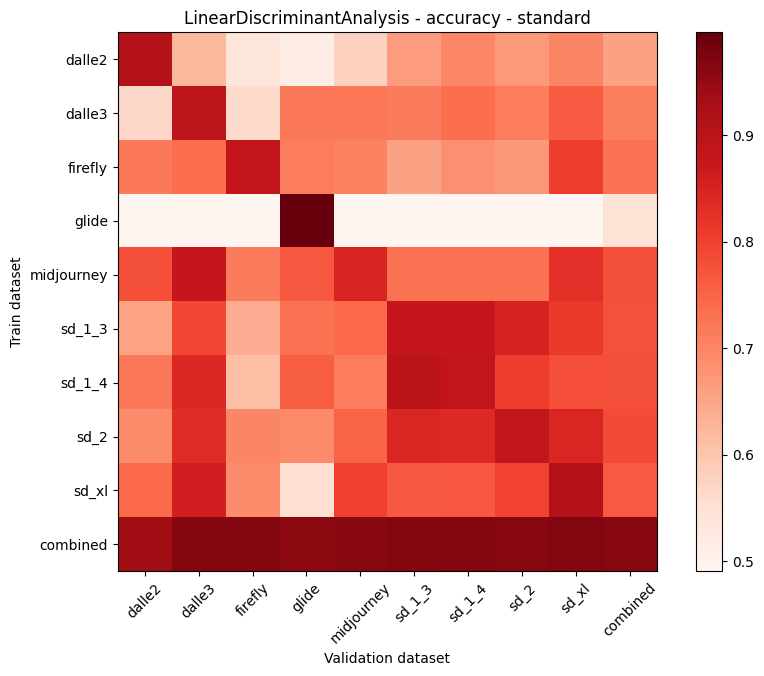

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.909375  0.621875  0.537500  0.515625    0.578125  0.665625   
dalle3         0.568750  0.893750  0.562500  0.718750    0.718750  0.715625   
firefly        0.718750  0.734375  0.884375  0.712500    0.706250  0.656250   
glide          0.493750  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.778125  0.881250  0.715625  0.765625    0.846875  0.731250   
sd_1_3         0.653125  0.790625  0.640625  0.731250    0.743750  0.881250   
sd_1_4         0.718750  0.840625  0.609375  0.759375    0.712500  0.896875   
sd_2           0.690625  0.834375  0.700000  0.690625    0.750000  0.843750   
sd_xl          0.740625  0.859375  0.690625  0.553125    0.800000  0.765625   
combined       0.937500  0.965625  0.965625  0.956250    0.962500  0.965625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.696875  0.668750  0.700000  0.654861  
dalle3         0.737500  0.712500  0.762500  0.710069  
firefly        0.684375  0.671875  0.803125  0.730208  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.731250  0.731250  0.828125  0.778819  
sd_1_3         0.881250  0.850000  0.812500  0.776042  
sd_1_4         0.884375  0.803125  0.781250  0.778472  
sd_2           0.837500  0.887500  0.843750  0.786458  
sd_xl          0.768750  0.796875  0.906250  0.764583  
combined       0.968750  0.962500  0.968750  0.961458

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.909375  0.621875  0.537500  0.515625    0.578125  0.665625   
dalle3         0.568750  0.893750  0.562500  0.718750    0.718750  0.715625   
firefly        0.718750  0.734375  0.884375  0.712500    0.706250  0.656250   
glide          0.493750  0.490625  0.490625  0.996875    0.490625  0.490625   
midjourney     0.778125  0.881250  0.715625  0.765625    0.846875  0.731250   
sd_1_3         0.653125  0.790625  0.640625  0.731250    0.743750  0.881250   
sd_1_4         0.718750  0.840625  0.609375  0.759375    0.712500  0.896875   
sd_2           0.690625  0.834375  0.700000  0.690625    0.750000  0.843750   
sd_xl          0.740625  0.859375  0.690625  0.553125    0.800000  0.765625   
combined       0.937500  0.965625  0.965625  0.956250    0.962500  0.965625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.696875  0.668750  0.700000  0.654861  
dalle3         0.737500  0.712500  0.762500  0.710069  
firefly        0.684375  0.671875  0.803125  0.730208  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.731250  0.731250  0.828125  0.778819  
sd_1_3         0.881250  0.850000  0.812500  0.776042  
sd_1_4         0.884375  0.803125  0.781250  0.778472  
sd_2           0.837500  0.887500  0.843750  0.786458  
sd_xl          0.768750  0.796875  0.906250  0.764583  
combined       0.968750  0.962500  0.968750  0.961458

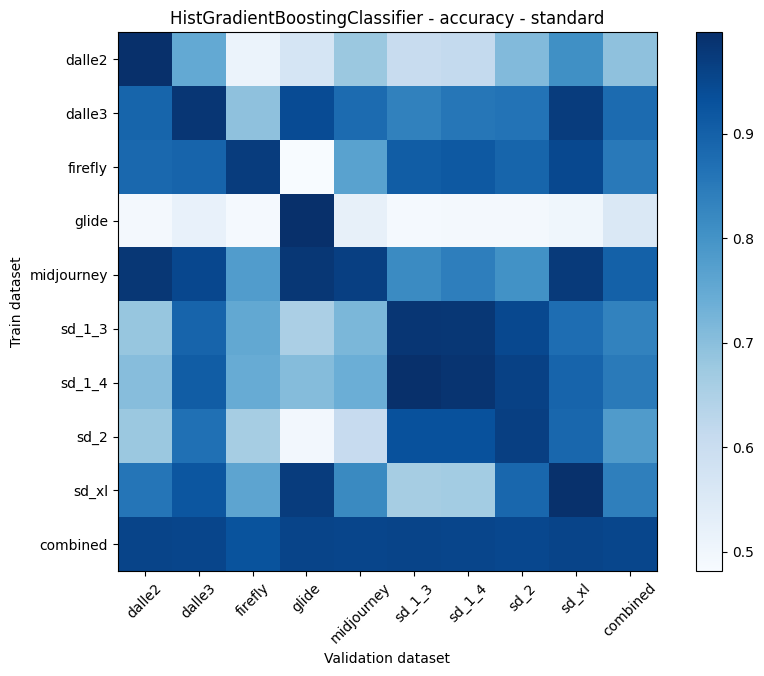

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.996875  0.750000  0.512500  0.568750    0.678125  0.603125   
dalle3         0.890625  0.984375  0.693750  0.940625    0.878125  0.834375   
firefly        0.884375  0.893750  0.971875  0.481250    0.765625  0.906250   
glide          0.490625  0.518750  0.487500  0.996875    0.521875  0.487500   
midjourney     0.981250  0.950000  0.778125  0.981250    0.965625  0.815625   
sd_1_3         0.684375  0.893750  0.753125  0.653125    0.718750  0.984375   
sd_1_4         0.703125  0.906250  0.743750  0.706250    0.737500  0.996875   
sd_2           0.678125  0.868750  0.662500  0.493750    0.606250  0.931250   
sd_xl          0.859375  0.921875  0.759375  0.971875    0.818750  0.662500   
combined       0.956250  0.953125  0.928125  0.956250    0.953125  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.612500  0.709375  0.806250  0.693056  
dalle3         0.856250  0.862500  0.971875  0.879167  
firefly        0.915625  0.890625  0.946875  0.850694  
glide          0.490625  0.490625  0.500000  0.553819  
midjourney     0.840625  0.803125  0.975000  0.898958  
sd_1_3         0.981250  0.946875  0.875000  0.832292  
sd_1_4         0.987500  0.962500  0.893750  0.848611  
sd_2           0.931250  0.965625  0.887500  0.780556  
sd_xl          0.665625  0.887500  0.993750  0.837847  
combined       0.953125  0.950000  0.956250  0.951389

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.996875  0.750000  0.512500  0.568750    0.678125  0.603125   
dalle3         0.890625  0.984375  0.693750  0.940625    0.878125  0.834375   
firefly        0.884375  0.893750  0.971875  0.481250    0.765625  0.906250   
glide          0.490625  0.518750  0.487500  0.996875    0.521875  0.487500   
midjourney     0.981250  0.950000  0.778125  0.981250    0.965625  0.815625   
sd_1_3         0.684375  0.893750  0.753125  0.653125    0.718750  0.984375   
sd_1_4         0.703125  0.906250  0.743750  0.706250    0.737500  0.996875   
sd_2           0.678125  0.868750  0.662500  0.493750    0.606250  0.931250   
sd_xl          0.859375  0.921875  0.759375  0.971875    0.818750  0.662500   
combined       0.956250  0.953125  0.928125  0.956250    0.953125  0.956250   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.612500  0.709375  0.806250  0.693056  
dalle3         0.856250  0.862500  0.971875  0.879167  
firefly        0.915625  0.890625  0.946875  0.850694  
glide          0.490625  0.490625  0.500000  0.553819  
midjourney     0.840625  0.803125  0.975000  0.898958  
sd_1_3         0.981250  0.946875  0.875000  0.832292  
sd_1_4         0.987500  0.962500  0.893750  0.848611  
sd_2           0.931250  0.965625  0.887500  0.780556  
sd_xl          0.665625  0.887500  0.993750  0.837847  
combined       0.953125  0.950000  0.956250  0.951389

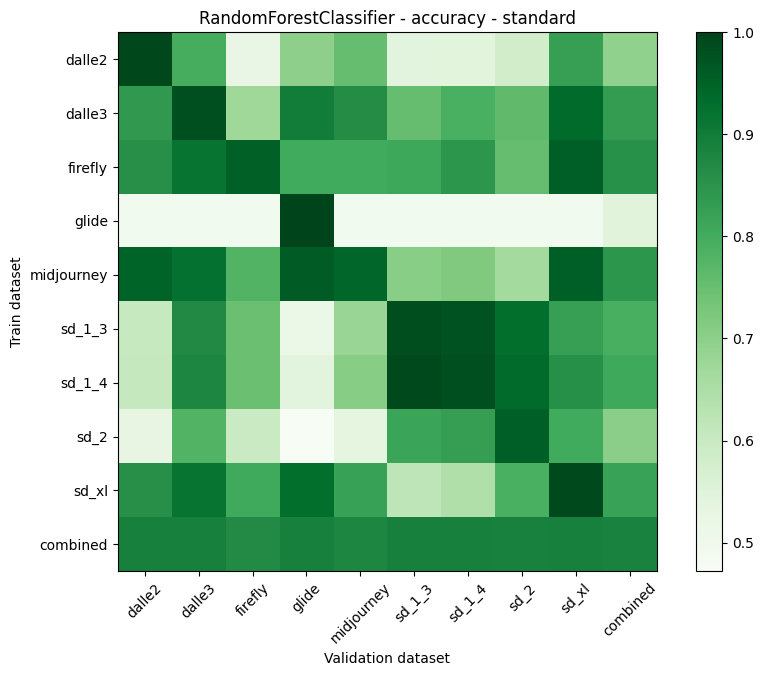

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.793750  0.521875  0.696875    0.753125  0.540625   
dalle3         0.837500  0.981250  0.671875  0.896875    0.865625  0.753125   
firefly        0.859375  0.915625  0.953125  0.800000    0.800000  0.809375   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.946875  0.921875  0.778125  0.962500    0.943750  0.703125   
sd_1_3         0.603125  0.871875  0.746875  0.515625    0.681250  0.984375   
sd_1_4         0.606250  0.878125  0.746875  0.540625    0.706250  0.990625   
sd_2           0.531250  0.778125  0.596875  0.471875    0.537500  0.815625   
sd_xl          0.859375  0.915625  0.803125  0.928125    0.821875  0.618750   
combined       0.890625  0.890625  0.868750  0.890625    0.878125  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.543750  0.581250  0.825000  0.694444  
dalle3         0.790625  0.759375  0.934375  0.832292  
firefly        0.843750  0.753125  0.956250  0.854514  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.718750  0.662500  0.956250  0.843750  
sd_1_3         0.975000  0.928125  0.825000  0.792361  
sd_1_4         0.981250  0.934375  0.856250  0.804514  
sd_2           0.828125  0.956250  0.800000  0.701736  
sd_xl          0.643750  0.790625  0.990625  0.819097  
combined       0.890625  0.887500  0.890625  0.886458

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993750  0.793750  0.521875  0.696875    0.753125  0.540625   
dalle3         0.837500  0.981250  0.671875  0.896875    0.865625  0.753125   
firefly        0.859375  0.915625  0.953125  0.800000    0.800000  0.809375   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.946875  0.921875  0.778125  0.962500    0.943750  0.703125   
sd_1_3         0.603125  0.871875  0.746875  0.515625    0.681250  0.984375   
sd_1_4         0.606250  0.878125  0.746875  0.540625    0.706250  0.990625   
sd_2           0.531250  0.778125  0.596875  0.471875    0.537500  0.815625   
sd_xl          0.859375  0.915625  0.803125  0.928125    0.821875  0.618750   
combined       0.890625  0.890625  0.868750  0.890625    0.878125  0.890625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.543750  0.581250  0.825000  0.694444  
dalle3         0.790625  0.759375  0.934375  0.832292  
firefly        0.843750  0.753125  0.956250  0.854514  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.718750  0.662500  0.956250  0.843750  
sd_1_3         0.975000  0.928125  0.825000  0.792361  
sd_1_4         0.981250  0.934375  0.856250  0.804514  
sd_2           0.828125  0.956250  0.800000  0.701736  
sd_xl          0.643750  0.790625  0.990625  0.819097  
combined       0.890625  0.887500  0.890625  0.886458

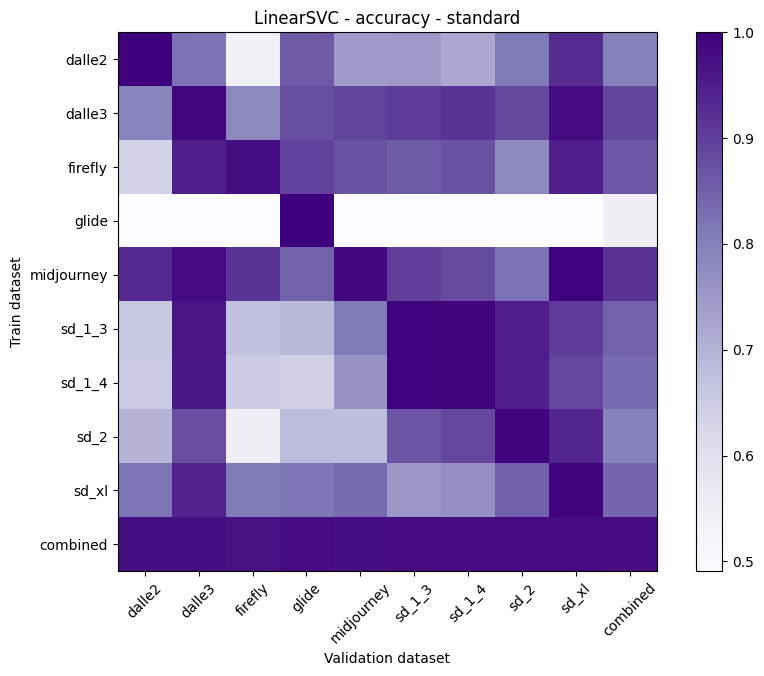

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.821875  0.540625  0.859375    0.743750  0.746875   
dalle3         0.790625  0.987500  0.781250  0.875000    0.890625  0.903125   
firefly        0.634375  0.950000  0.975000  0.893750    0.868750  0.856250   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.931250  0.981250  0.912500  0.846875    0.984375  0.900000   
sd_1_3         0.659375  0.965625  0.671875  0.687500    0.809375  0.996875   
sd_1_4         0.650000  0.962500  0.650000  0.637500    0.762500  0.996875   
sd_2           0.696875  0.878125  0.550000  0.681250    0.678125  0.865625   
sd_xl          0.818750  0.940625  0.809375  0.815625    0.834375  0.750000   
combined       0.975000  0.975000  0.971875  0.981250    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.715625  0.809375  0.928125  0.796181  
dalle3         0.915625  0.884375  0.981250  0.889931  
firefly        0.868750  0.781250  0.950000  0.864236  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.881250  0.821875  0.996875  0.917361  
sd_1_3         0.990625  0.950000  0.903125  0.848264  
sd_1_4         0.990625  0.950000  0.887500  0.831944  
sd_2           0.887500  0.990625  0.937500  0.796181  
sd_xl          0.765625  0.850000  0.990625  0.841667  
combined       0.981250  0.981250  0.981250  0.977778

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.821875  0.540625  0.859375    0.743750  0.746875   
dalle3         0.790625  0.987500  0.781250  0.875000    0.890625  0.903125   
firefly        0.634375  0.950000  0.975000  0.893750    0.868750  0.856250   
glide          0.490625  0.490625  0.490625  1.000000    0.490625  0.490625   
midjourney     0.931250  0.981250  0.912500  0.846875    0.984375  0.900000   
sd_1_3         0.659375  0.965625  0.671875  0.687500    0.809375  0.996875   
sd_1_4         0.650000  0.962500  0.650000  0.637500    0.762500  0.996875   
sd_2           0.696875  0.878125  0.550000  0.681250    0.678125  0.865625   
sd_xl          0.818750  0.940625  0.809375  0.815625    0.834375  0.750000   
combined       0.975000  0.975000  0.971875  0.981250    0.975000  0.978125   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.715625  0.809375  0.928125  0.796181  
dalle3         0.915625  0.884375  0.981250  0.889931  
firefly        0.868750  0.781250  0.950000  0.864236  
glide          0.490625  0.490625  0.490625  0.547222  
midjourney     0.881250  0.821875  0.996875  0.917361  
sd_1_3         0.990625  0.950000  0.903125  0.848264  
sd_1_4         0.990625  0.950000  0.887500  0.831944  
sd_2           0.887500  0.990625  0.937500  0.796181  
sd_xl          0.765625  0.850000  0.990625  0.841667  
combined       0.981250  0.981250  0.981250  0.977778









 ################ Evaluating models trained on standard and tested on sigma_1. ################


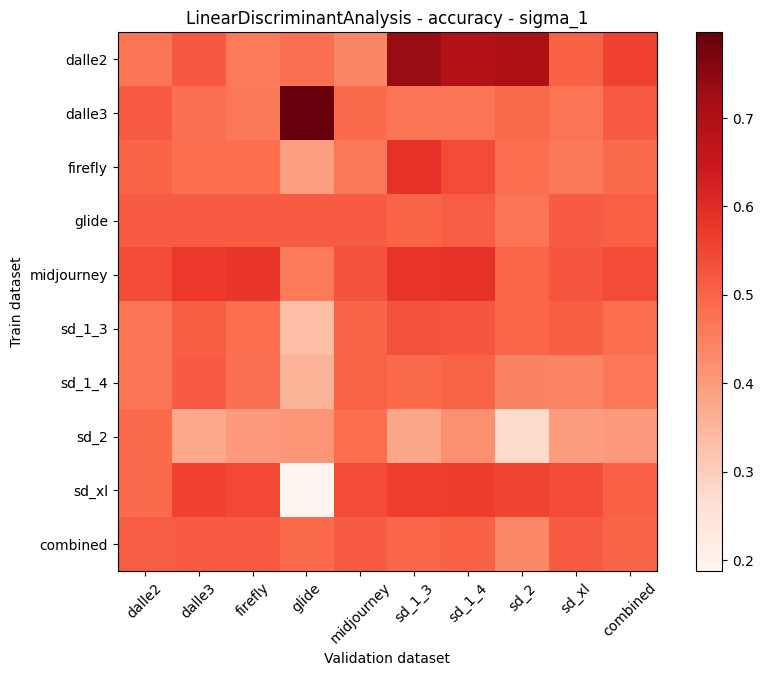

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.468750  0.518750  0.459375  0.478125    0.437500  0.734375   
dalle3         0.515625  0.478125  0.465625  0.796875    0.490625  0.468750   
firefly        0.500000  0.481250  0.484375  0.390625    0.462500  0.587500   
glide          0.515625  0.515625  0.515625  0.515625    0.515625  0.500000   
midjourney     0.537500  0.575000  0.581250  0.459375    0.528125  0.578125   
sd_1_3         0.468750  0.509375  0.481250  0.334375    0.500000  0.531250   
sd_1_4         0.471875  0.515625  0.478125  0.353125    0.503125  0.490625   
sd_2           0.490625  0.375000  0.400000  0.409375    0.481250  0.378125   
sd_xl          0.490625  0.556250  0.546875  0.187500    0.540625  0.562500   
combined       0.512500  0.515625  0.515625  0.487500    0.515625  0.496875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.690625  0.703125  0.506250  0.555208  
dalle3         0.468750  0.493750  0.471875  0.516667  
firefly        0.540625  0.484375  0.462500  0.488194  
glide          0.512500  0.471875  0.515625  0.508681  
midjourney     0.587500  0.496875  0.525000  0.540972  
sd_1_3         0.525000  0.496875  0.509375  0.484028  
sd_1_4         0.503125  0.446875  0.440625  0.467014  
sd_2           0.421875  0.275000  0.396875  0.403125  
sd_xl          0.565625  0.550000  0.537500  0.504167  
combined       0.506250  0.434375  0.515625  0.500000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.468750  0.518750  0.459375  0.478125    0.437500  0.734375   
dalle3         0.515625  0.478125  0.465625  0.796875    0.490625  0.468750   
firefly        0.500000  0.481250  0.484375  0.390625    0.462500  0.587500   
glide          0.515625  0.515625  0.515625  0.515625    0.515625  0.500000   
midjourney     0.537500  0.575000  0.581250  0.459375    0.528125  0.578125   
sd_1_3         0.468750  0.509375  0.481250  0.334375    0.500000  0.531250   
sd_1_4         0.471875  0.515625  0.478125  0.353125    0.503125  0.490625   
sd_2           0.490625  0.375000  0.400000  0.409375    0.481250  0.378125   
sd_xl          0.490625  0.556250  0.546875  0.187500    0.540625  0.562500   
combined       0.512500  0.515625  0.515625  0.487500    0.515625  0.496875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.690625  0.703125  0.506250  0.555208  
dalle3         0.468750  0.493750  0.471875  0.516667  
firefly        0.540625  0.484375  0.462500  0.488194  
glide          0.512500  0.471875  0.515625  0.508681  
midjourney     0.587500  0.496875  0.525000  0.540972  
sd_1_3         0.525000  0.496875  0.509375  0.484028  
sd_1_4         0.503125  0.446875  0.440625  0.467014  
sd_2           0.421875  0.275000  0.396875  0.403125  
sd_xl          0.565625  0.550000  0.537500  0.504167  
combined       0.506250  0.434375  0.515625  0.500000

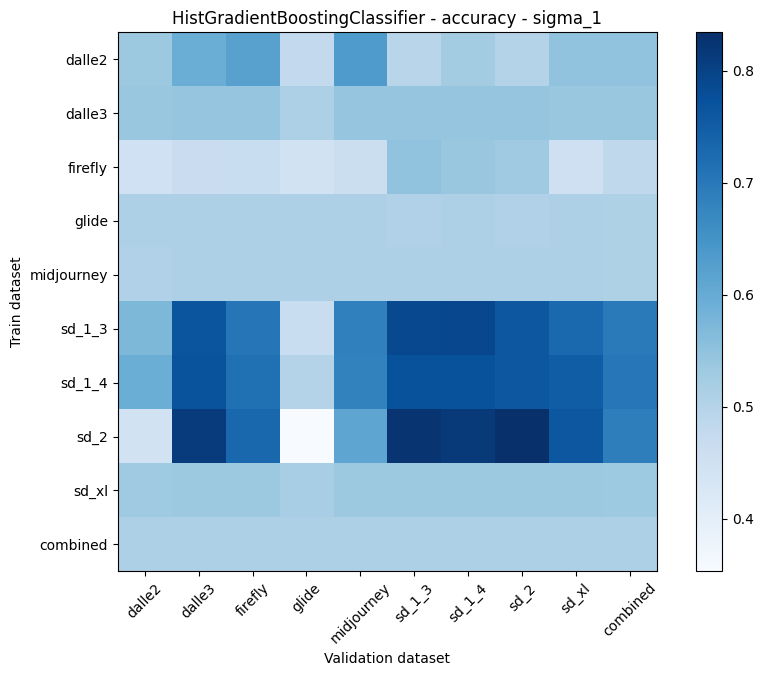

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.534375  0.593750  0.621875  0.478125    0.634375  0.493750   
dalle3         0.540625  0.543750  0.543750  0.509375    0.543750  0.543750   
firefly        0.450000  0.462500  0.465625  0.446875    0.459375  0.546875   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.506250   
midjourney     0.506250  0.509375  0.509375  0.509375    0.509375  0.509375   
sd_1_3         0.571875  0.765625  0.703125  0.465625    0.684375  0.787500   
sd_1_4         0.593750  0.768750  0.715625  0.500000    0.681250  0.771875   
sd_2           0.443750  0.812500  0.731250  0.353125    0.612500  0.825000   
sd_xl          0.531250  0.534375  0.534375  0.518750    0.534375  0.534375   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.525000  0.500000  0.546875  0.547569  
dalle3         0.543750  0.543750  0.540625  0.539236  
firefly        0.540625  0.531250  0.453125  0.484028  
glide          0.509375  0.506250  0.509375  0.508681  
midjourney     0.509375  0.509375  0.509375  0.509028  
sd_1_3         0.790625  0.762500  0.728125  0.695486  
sd_1_4         0.771875  0.762500  0.750000  0.701736  
sd_2           0.815625  0.834375  0.762500  0.687847  
sd_xl          0.534375  0.534375  0.534375  0.532292  
combined       0.509375  0.509375  0.509375  0.509375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.534375  0.593750  0.621875  0.478125    0.634375  0.493750   
dalle3         0.540625  0.543750  0.543750  0.509375    0.543750  0.543750   
firefly        0.450000  0.462500  0.465625  0.446875    0.459375  0.546875   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.506250   
midjourney     0.506250  0.509375  0.509375  0.509375    0.509375  0.509375   
sd_1_3         0.571875  0.765625  0.703125  0.465625    0.684375  0.787500   
sd_1_4         0.593750  0.768750  0.715625  0.500000    0.681250  0.771875   
sd_2           0.443750  0.812500  0.731250  0.353125    0.612500  0.825000   
sd_xl          0.531250  0.534375  0.534375  0.518750    0.534375  0.534375   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.525000  0.500000  0.546875  0.547569  
dalle3         0.543750  0.543750  0.540625  0.539236  
firefly        0.540625  0.531250  0.453125  0.484028  
glide          0.509375  0.506250  0.509375  0.508681  
midjourney     0.509375  0.509375  0.509375  0.509028  
sd_1_3         0.790625  0.762500  0.728125  0.695486  
sd_1_4         0.771875  0.762500  0.750000  0.701736  
sd_2           0.815625  0.834375  0.762500  0.687847  
sd_xl          0.534375  0.534375  0.534375  0.532292  
combined       0.509375  0.509375  0.509375  0.509375

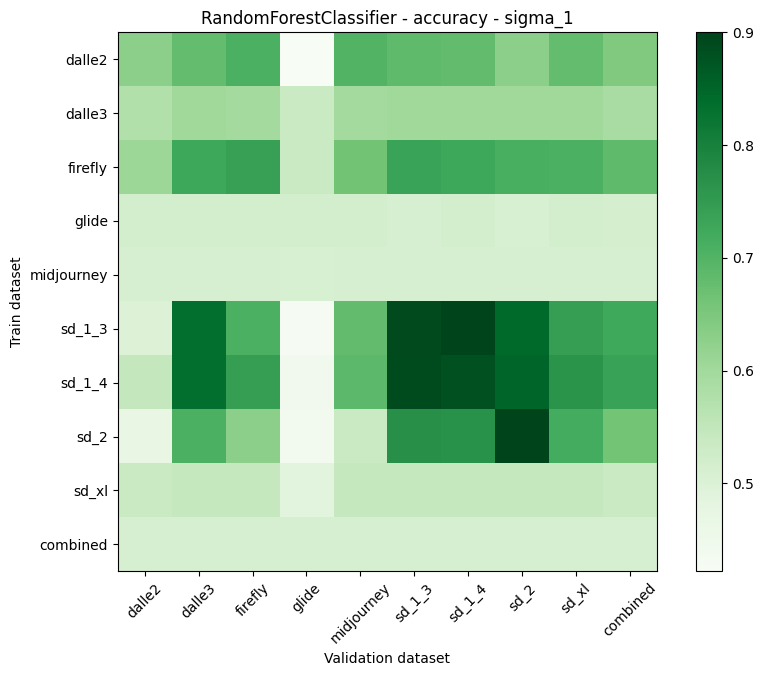

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.628125  0.678125  0.706250  0.421875    0.700000  0.684375   
dalle3         0.575000  0.600000  0.596875  0.534375    0.596875  0.600000   
firefly        0.606250  0.728125  0.740625  0.537500    0.662500  0.734375   
glide          0.515625  0.515625  0.515625  0.515625    0.515625  0.509375   
midjourney     0.509375  0.509375  0.509375  0.506250    0.509375  0.509375   
sd_1_3         0.500000  0.834375  0.709375  0.428125    0.681250  0.890625   
sd_1_4         0.546875  0.834375  0.743750  0.440625    0.687500  0.887500   
sd_2           0.471875  0.709375  0.628125  0.437500    0.534375  0.771875   
sd_xl          0.534375  0.543750  0.543750  0.484375    0.543750  0.543750   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.681250  0.628125  0.678125  0.645139  
dalle3         0.600000  0.600000  0.600000  0.589236  
firefly        0.728125  0.712500  0.709375  0.684375  
glide          0.515625  0.506250  0.515625  0.513889  
midjourney     0.509375  0.509375  0.509375  0.509028  
sd_1_3         0.900000  0.843750  0.743750  0.725694  
sd_1_4         0.881250  0.850000  0.762500  0.737153  
sd_2           0.765625  0.900000  0.718750  0.659722  
sd_xl          0.543750  0.543750  0.543750  0.536111  
combined       0.509375  0.509375  0.509375  0.509375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.628125  0.678125  0.706250  0.421875    0.700000  0.684375   
dalle3         0.575000  0.600000  0.596875  0.534375    0.596875  0.600000   
firefly        0.606250  0.728125  0.740625  0.537500    0.662500  0.734375   
glide          0.515625  0.515625  0.515625  0.515625    0.515625  0.509375   
midjourney     0.509375  0.509375  0.509375  0.506250    0.509375  0.509375   
sd_1_3         0.500000  0.834375  0.709375  0.428125    0.681250  0.890625   
sd_1_4         0.546875  0.834375  0.743750  0.440625    0.687500  0.887500   
sd_2           0.471875  0.709375  0.628125  0.437500    0.534375  0.771875   
sd_xl          0.534375  0.543750  0.543750  0.484375    0.543750  0.543750   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.681250  0.628125  0.678125  0.645139  
dalle3         0.600000  0.600000  0.600000  0.589236  
firefly        0.728125  0.712500  0.709375  0.684375  
glide          0.515625  0.506250  0.515625  0.513889  
midjourney     0.509375  0.509375  0.509375  0.509028  
sd_1_3         0.900000  0.843750  0.743750  0.725694  
sd_1_4         0.881250  0.850000  0.762500  0.737153  
sd_2           0.765625  0.900000  0.718750  0.659722  
sd_xl          0.543750  0.543750  0.543750  0.536111  
combined       0.509375  0.509375  0.509375  0.509375

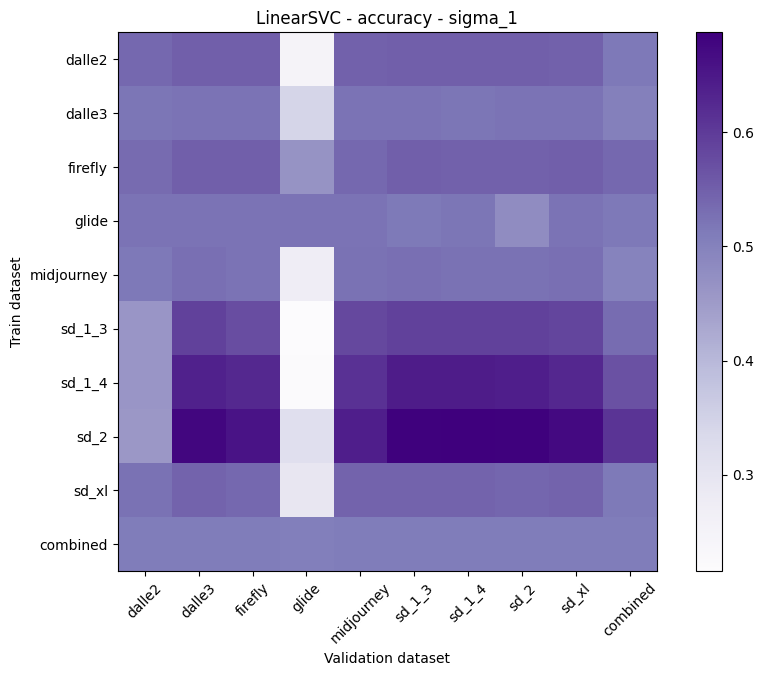

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.537500  0.550000  0.550000  0.246875    0.546875  0.550000   
dalle3         0.518750  0.521875  0.521875  0.343750    0.521875  0.521875   
firefly        0.534375  0.550000  0.550000  0.465625    0.537500  0.550000   
glide          0.521875  0.521875  0.521875  0.521875    0.521875  0.512500   
midjourney     0.515625  0.528125  0.521875  0.271875    0.525000  0.528125   
sd_1_3         0.459375  0.590625  0.575000  0.215625    0.581250  0.590625   
sd_1_4         0.459375  0.637500  0.625000  0.218750    0.612500  0.643750   
sd_2           0.456250  0.678125  0.656250  0.315625    0.640625  0.684375   
sd_xl          0.525000  0.543750  0.537500  0.293750    0.543750  0.543750   
combined       0.509375  0.509375  0.509375  0.506250    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.550000  0.550000  0.546875  0.514236  
dalle3         0.518750  0.521875  0.521875  0.501389  
firefly        0.546875  0.546875  0.550000  0.536806  
glide          0.518750  0.478125  0.521875  0.515625  
midjourney     0.525000  0.525000  0.528125  0.496528  
sd_1_3         0.590625  0.590625  0.584375  0.530903  
sd_1_4         0.643750  0.640625  0.628125  0.567708  
sd_2           0.687500  0.684375  0.671875  0.608333  
sd_xl          0.543750  0.540625  0.543750  0.512847  
combined       0.509375  0.509375  0.509375  0.509028

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.537500  0.550000  0.550000  0.246875    0.546875  0.550000   
dalle3         0.518750  0.521875  0.521875  0.343750    0.521875  0.521875   
firefly        0.534375  0.550000  0.550000  0.465625    0.537500  0.550000   
glide          0.521875  0.521875  0.521875  0.521875    0.521875  0.512500   
midjourney     0.515625  0.528125  0.521875  0.271875    0.525000  0.528125   
sd_1_3         0.459375  0.590625  0.575000  0.215625    0.581250  0.590625   
sd_1_4         0.459375  0.637500  0.625000  0.218750    0.612500  0.643750   
sd_2           0.456250  0.678125  0.656250  0.315625    0.640625  0.684375   
sd_xl          0.525000  0.543750  0.537500  0.293750    0.543750  0.543750   
combined       0.509375  0.509375  0.509375  0.506250    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.550000  0.550000  0.546875  0.514236  
dalle3         0.518750  0.521875  0.521875  0.501389  
firefly        0.546875  0.546875  0.550000  0.536806  
glide          0.518750  0.478125  0.521875  0.515625  
midjourney     0.525000  0.525000  0.528125  0.496528  
sd_1_3         0.590625  0.590625  0.584375  0.530903  
sd_1_4         0.643750  0.640625  0.628125  0.567708  
sd_2           0.687500  0.684375  0.671875  0.608333  
sd_xl          0.543750  0.540625  0.543750  0.512847  
combined       0.509375  0.509375  0.509375  0.509028









 ################ Evaluating models trained on standard and tested on sigma_2. ################


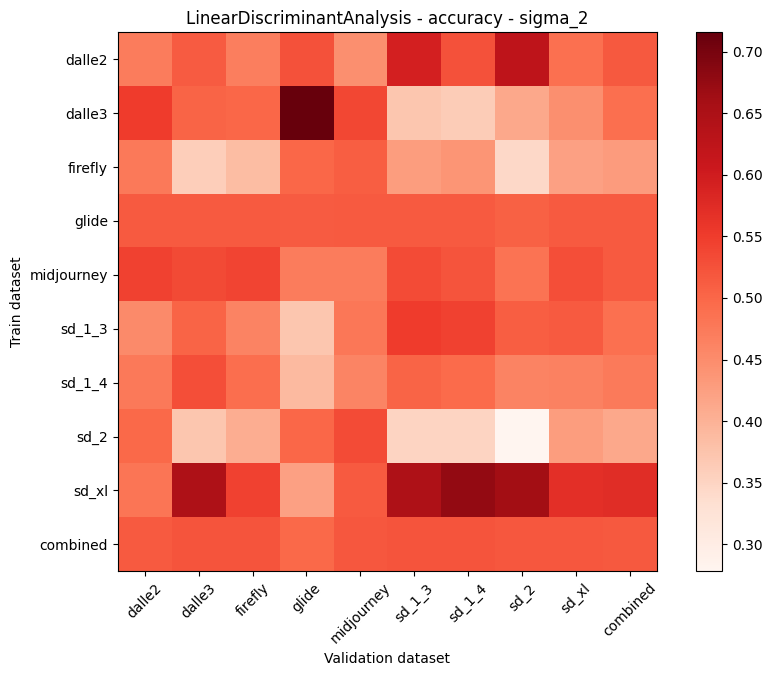

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.471875  0.512500  0.468750  0.525000    0.446875  0.593750   
dalle3         0.550000  0.503125  0.500000  0.715625    0.537500  0.371875   
firefly        0.475000  0.359375  0.384375  0.500000    0.509375  0.428125   
glide          0.515625  0.515625  0.515625  0.512500    0.515625  0.515625   
midjourney     0.543750  0.534375  0.540625  0.471875    0.471875  0.531250   
sd_1_3         0.453125  0.503125  0.462500  0.371875    0.478125  0.550000   
sd_1_4         0.475000  0.528125  0.490625  0.387500    0.459375  0.503125   
sd_2           0.496875  0.371875  0.406250  0.500000    0.531250  0.350000   
sd_xl          0.481250  0.646875  0.543750  0.421875    0.515625  0.646875   
combined       0.515625  0.521875  0.521875  0.496875    0.518750  0.521875   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.525000  0.625000  0.487500  0.517361  
dalle3         0.362500  0.412500  0.446875  0.488889  
firefly        0.437500  0.343750  0.421875  0.428819  
glide          0.515625  0.506250  0.515625  0.514236  
midjourney     0.521875  0.484375  0.528125  0.514236  
sd_1_3         0.543750  0.509375  0.515625  0.487500  
sd_1_4         0.493750  0.462500  0.465625  0.473958  
sd_2           0.350000  0.278125  0.428125  0.412500  
sd_xl          0.675000  0.662500  0.568750  0.573611  
combined       0.521875  0.518750  0.518750  0.517361

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.471875  0.512500  0.468750  0.525000    0.446875  0.593750   
dalle3         0.550000  0.503125  0.500000  0.715625    0.537500  0.371875   
firefly        0.475000  0.359375  0.384375  0.500000    0.509375  0.428125   
glide          0.515625  0.515625  0.515625  0.512500    0.515625  0.515625   
midjourney     0.543750  0.534375  0.540625  0.471875    0.471875  0.531250   
sd_1_3         0.453125  0.503125  0.462500  0.371875    0.478125  0.550000   
sd_1_4         0.475000  0.528125  0.490625  0.387500    0.459375  0.503125   
sd_2           0.496875  0.371875  0.406250  0.500000    0.531250  0.350000   
sd_xl          0.481250  0.646875  0.543750  0.421875    0.515625  0.646875   
combined       0.515625  0.521875  0.521875  0.496875    0.518750  0.521875   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.525000  0.625000  0.487500  0.517361  
dalle3         0.362500  0.412500  0.446875  0.488889  
firefly        0.437500  0.343750  0.421875  0.428819  
glide          0.515625  0.506250  0.515625  0.514236  
midjourney     0.521875  0.484375  0.528125  0.514236  
sd_1_3         0.543750  0.509375  0.515625  0.487500  
sd_1_4         0.493750  0.462500  0.465625  0.473958  
sd_2           0.350000  0.278125  0.428125  0.412500  
sd_xl          0.675000  0.662500  0.568750  0.573611  
combined       0.521875  0.518750  0.518750  0.517361

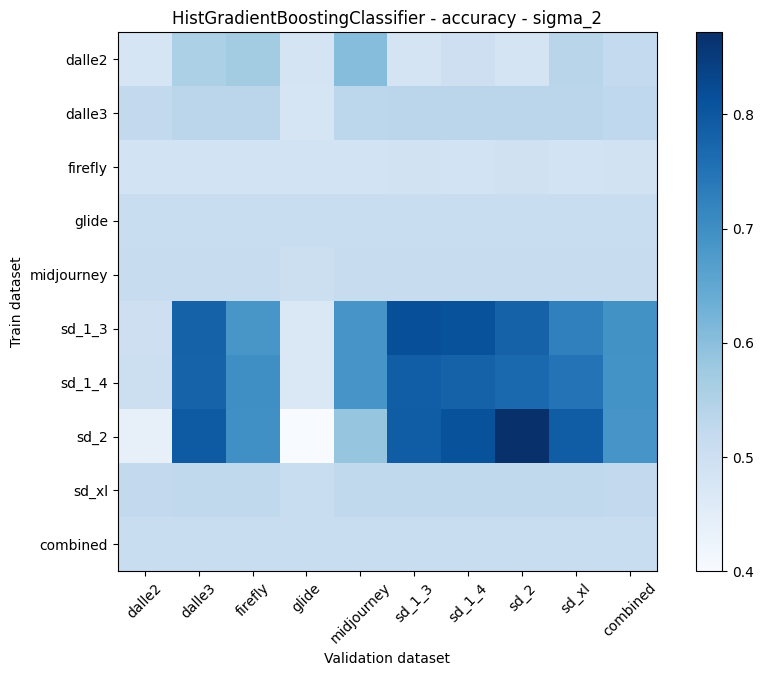

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.478125  0.556250  0.568750  0.481250    0.603125  0.481250   
dalle3         0.521875  0.534375  0.534375  0.478125    0.531250  0.534375   
firefly        0.487500  0.487500  0.487500  0.487500    0.487500  0.490625   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.512500  0.512500  0.512500  0.503125    0.512500  0.512500   
sd_1_3         0.500000  0.781250  0.684375  0.468750    0.687500  0.815625   
sd_1_4         0.503125  0.778125  0.700000  0.468750    0.687500  0.787500   
sd_2           0.437500  0.793750  0.696875  0.400000    0.587500  0.790625   
sd_xl          0.521875  0.525000  0.525000  0.509375    0.525000  0.525000   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.500000  0.484375  0.537500  0.521181  
dalle3         0.534375  0.534375  0.534375  0.526389  
firefly        0.487500  0.493750  0.487500  0.488542  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.512500  0.512500  0.512500  0.511458  
sd_1_3         0.809375  0.781250  0.725000  0.694792  
sd_1_4         0.781250  0.768750  0.750000  0.691667  
sd_2           0.809375  0.871875  0.790625  0.686458  
sd_xl          0.525000  0.525000  0.525000  0.522917  
combined       0.509375  0.509375  0.509375  0.509375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.478125  0.556250  0.568750  0.481250    0.603125  0.481250   
dalle3         0.521875  0.534375  0.534375  0.478125    0.531250  0.534375   
firefly        0.487500  0.487500  0.487500  0.487500    0.487500  0.490625   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.512500  0.512500  0.512500  0.503125    0.512500  0.512500   
sd_1_3         0.500000  0.781250  0.684375  0.468750    0.687500  0.815625   
sd_1_4         0.503125  0.778125  0.700000  0.468750    0.687500  0.787500   
sd_2           0.437500  0.793750  0.696875  0.400000    0.587500  0.790625   
sd_xl          0.521875  0.525000  0.525000  0.509375    0.525000  0.525000   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.500000  0.484375  0.537500  0.521181  
dalle3         0.534375  0.534375  0.534375  0.526389  
firefly        0.487500  0.493750  0.487500  0.488542  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.512500  0.512500  0.512500  0.511458  
sd_1_3         0.809375  0.781250  0.725000  0.694792  
sd_1_4         0.781250  0.768750  0.750000  0.691667  
sd_2           0.809375  0.871875  0.790625  0.686458  
sd_xl          0.525000  0.525000  0.525000  0.522917  
combined       0.509375  0.509375  0.509375  0.509375

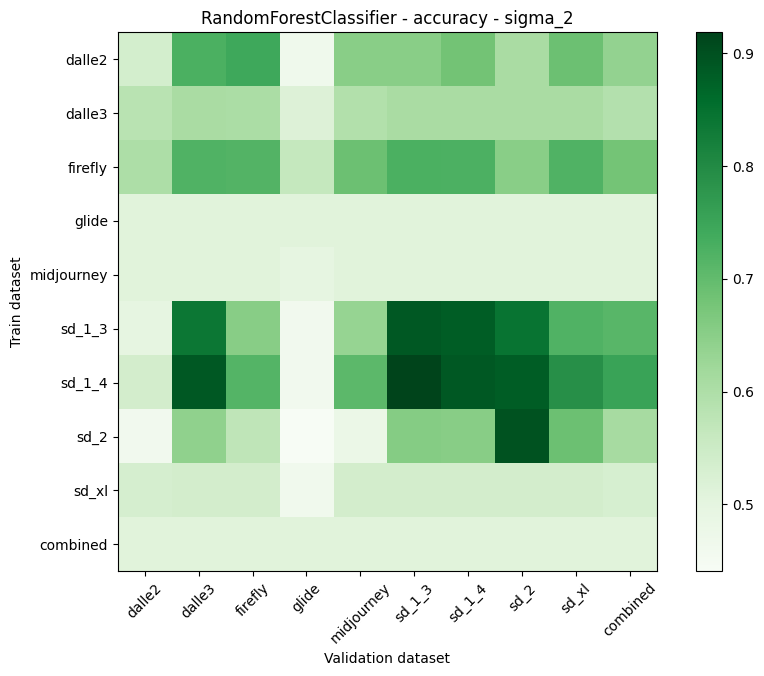

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.534375  0.728125  0.743750  0.465625    0.650000  0.650000   
dalle3         0.581250  0.606250  0.603125  0.515625    0.593750  0.606250   
firefly        0.600000  0.721875  0.718750  0.562500    0.687500  0.728125   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.509375  0.509375  0.509375  0.496875    0.509375  0.509375   
sd_1_3         0.496875  0.837500  0.653125  0.459375    0.634375  0.887500   
sd_1_4         0.537500  0.887500  0.715625  0.459375    0.706250  0.918750   
sd_2           0.459375  0.640625  0.571875  0.440625    0.481250  0.656250   
sd_xl          0.531250  0.537500  0.537500  0.462500    0.537500  0.537500   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.681250  0.606250  0.687500  0.638542  
dalle3         0.606250  0.606250  0.606250  0.591667  
firefly        0.725000  0.650000  0.721875  0.679514  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.509375  0.509375  0.509375  0.507986  
sd_1_3         0.881250  0.843750  0.721875  0.712847  
sd_1_4         0.887500  0.881250  0.790625  0.753819  
sd_2           0.653125  0.896875  0.687500  0.609722  
sd_xl          0.537500  0.537500  0.537500  0.528472  
combined       0.509375  0.509375  0.509375  0.509375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.534375  0.728125  0.743750  0.465625    0.650000  0.650000   
dalle3         0.581250  0.606250  0.603125  0.515625    0.593750  0.606250   
firefly        0.600000  0.721875  0.718750  0.562500    0.687500  0.728125   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.509375  0.509375  0.509375  0.496875    0.509375  0.509375   
sd_1_3         0.496875  0.837500  0.653125  0.459375    0.634375  0.887500   
sd_1_4         0.537500  0.887500  0.715625  0.459375    0.706250  0.918750   
sd_2           0.459375  0.640625  0.571875  0.440625    0.481250  0.656250   
sd_xl          0.531250  0.537500  0.537500  0.462500    0.537500  0.537500   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.681250  0.606250  0.687500  0.638542  
dalle3         0.606250  0.606250  0.606250  0.591667  
firefly        0.725000  0.650000  0.721875  0.679514  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.509375  0.509375  0.509375  0.507986  
sd_1_3         0.881250  0.843750  0.721875  0.712847  
sd_1_4         0.887500  0.881250  0.790625  0.753819  
sd_2           0.653125  0.896875  0.687500  0.609722  
sd_xl          0.537500  0.537500  0.537500  0.528472  
combined       0.509375  0.509375  0.509375  0.509375

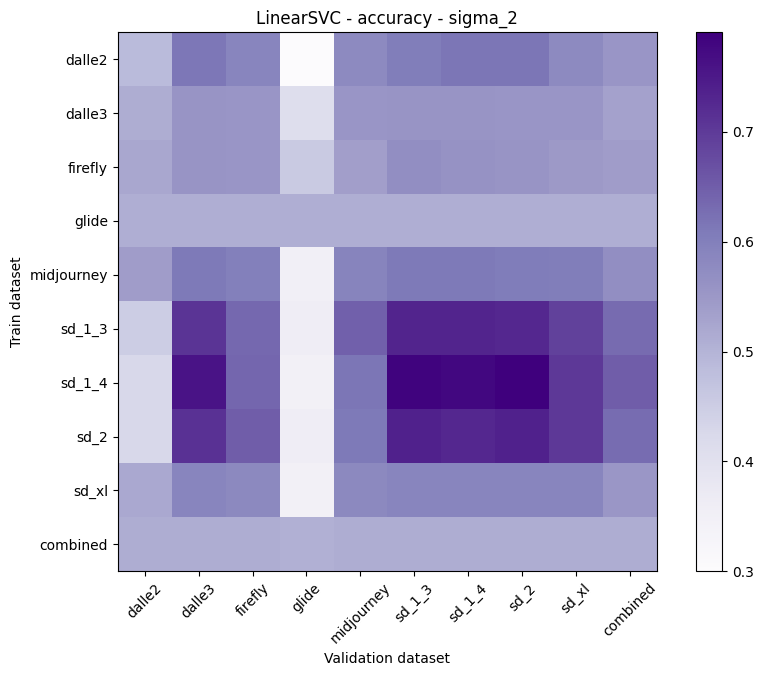

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.487500  0.612500  0.587500  0.300000    0.578125  0.603125   
dalle3         0.512500  0.556250  0.553125  0.409375    0.553125  0.556250   
firefly        0.521875  0.556250  0.553125  0.456250    0.537500  0.568750   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.540625  0.609375  0.600000  0.350000    0.590625  0.609375   
sd_1_3         0.450000  0.709375  0.634375  0.359375    0.646875  0.731250   
sd_1_4         0.425000  0.759375  0.637500  0.346875    0.615625  0.784375   
sd_2           0.425000  0.712500  0.650000  0.359375    0.609375  0.737500   
sd_xl          0.518750  0.587500  0.581250  0.346875    0.581250  0.587500   
combined       0.512500  0.512500  0.512500  0.506250    0.512500  0.512500   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.615625  0.615625  0.578125  0.553125  
dalle3         0.556250  0.553125  0.553125  0.533681  
firefly        0.562500  0.556250  0.546875  0.539931  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.609375  0.606250  0.603125  0.568750  
sd_1_3         0.731250  0.728125  0.690625  0.631250  
sd_1_4         0.778125  0.790625  0.703125  0.648958  
sd_2           0.728125  0.737500  0.703125  0.629167  
sd_xl          0.587500  0.587500  0.587500  0.551736  
combined       0.512500  0.512500  0.512500  0.511806

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.487500  0.612500  0.587500  0.300000    0.578125  0.603125   
dalle3         0.512500  0.556250  0.553125  0.409375    0.553125  0.556250   
firefly        0.521875  0.556250  0.553125  0.456250    0.537500  0.568750   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.540625  0.609375  0.600000  0.350000    0.590625  0.609375   
sd_1_3         0.450000  0.709375  0.634375  0.359375    0.646875  0.731250   
sd_1_4         0.425000  0.759375  0.637500  0.346875    0.615625  0.784375   
sd_2           0.425000  0.712500  0.650000  0.359375    0.609375  0.737500   
sd_xl          0.518750  0.587500  0.581250  0.346875    0.581250  0.587500   
combined       0.512500  0.512500  0.512500  0.506250    0.512500  0.512500   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.615625  0.615625  0.578125  0.553125  
dalle3         0.556250  0.553125  0.553125  0.533681  
firefly        0.562500  0.556250  0.546875  0.539931  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.609375  0.606250  0.603125  0.568750  
sd_1_3         0.731250  0.728125  0.690625  0.631250  
sd_1_4         0.778125  0.790625  0.703125  0.648958  
sd_2           0.728125  0.737500  0.703125  0.629167  
sd_xl          0.587500  0.587500  0.587500  0.551736  
combined       0.512500  0.512500  0.512500  0.511806









 ################ Evaluating models trained on standard and tested on sigma_3. ################


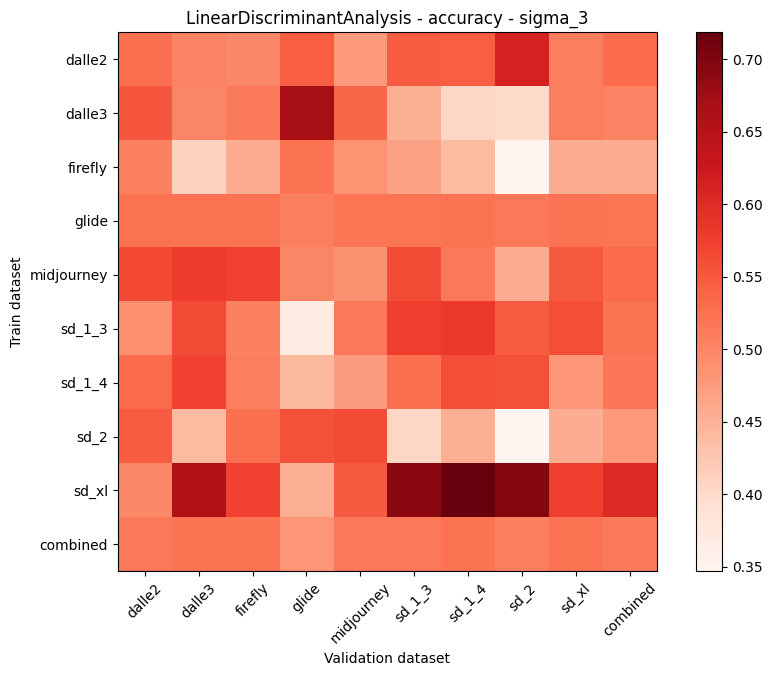

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.525000  0.503125  0.496875  0.543750    0.478125  0.546875   
dalle3         0.553125  0.500000  0.512500  0.668750    0.534375  0.453125   
firefly        0.506250  0.409375  0.456250  0.521875    0.484375  0.468750   
glide          0.521875  0.521875  0.521875  0.509375    0.518750  0.518750   
midjourney     0.565625  0.578125  0.571875  0.500000    0.487500  0.562500   
sd_1_3         0.490625  0.562500  0.506250  0.368750    0.515625  0.575000   
sd_1_4         0.531250  0.571875  0.509375  0.443750    0.475000  0.525000   
sd_2           0.546875  0.440625  0.525000  0.556250    0.562500  0.406250   
sd_xl          0.496875  0.656250  0.571875  0.453125    0.550000  0.690625   
combined       0.515625  0.521875  0.521875  0.481250    0.515625  0.515625   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.543750  0.612500  0.509375  0.528819  
dalle3         0.406250  0.400000  0.509375  0.504167  
firefly        0.440625  0.350000  0.456250  0.454861  
glide          0.521875  0.515625  0.521875  0.519097  
midjourney     0.515625  0.456250  0.550000  0.531944  
sd_1_3         0.581250  0.546875  0.559375  0.522917  
sd_1_4         0.559375  0.556250  0.481250  0.517014  
sd_2           0.453125  0.346875  0.456250  0.477083  
sd_xl          0.718750  0.696875  0.575000  0.601042  
combined       0.521875  0.509375  0.521875  0.513889

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.525000  0.503125  0.496875  0.543750    0.478125  0.546875   
dalle3         0.553125  0.500000  0.512500  0.668750    0.534375  0.453125   
firefly        0.506250  0.409375  0.456250  0.521875    0.484375  0.468750   
glide          0.521875  0.521875  0.521875  0.509375    0.518750  0.518750   
midjourney     0.565625  0.578125  0.571875  0.500000    0.487500  0.562500   
sd_1_3         0.490625  0.562500  0.506250  0.368750    0.515625  0.575000   
sd_1_4         0.531250  0.571875  0.509375  0.443750    0.475000  0.525000   
sd_2           0.546875  0.440625  0.525000  0.556250    0.562500  0.406250   
sd_xl          0.496875  0.656250  0.571875  0.453125    0.550000  0.690625   
combined       0.515625  0.521875  0.521875  0.481250    0.515625  0.515625   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.543750  0.612500  0.509375  0.528819  
dalle3         0.406250  0.400000  0.509375  0.504167  
firefly        0.440625  0.350000  0.456250  0.454861  
glide          0.521875  0.515625  0.521875  0.519097  
midjourney     0.515625  0.456250  0.550000  0.531944  
sd_1_3         0.581250  0.546875  0.559375  0.522917  
sd_1_4         0.559375  0.556250  0.481250  0.517014  
sd_2           0.453125  0.346875  0.456250  0.477083  
sd_xl          0.718750  0.696875  0.575000  0.601042  
combined       0.521875  0.509375  0.521875  0.513889

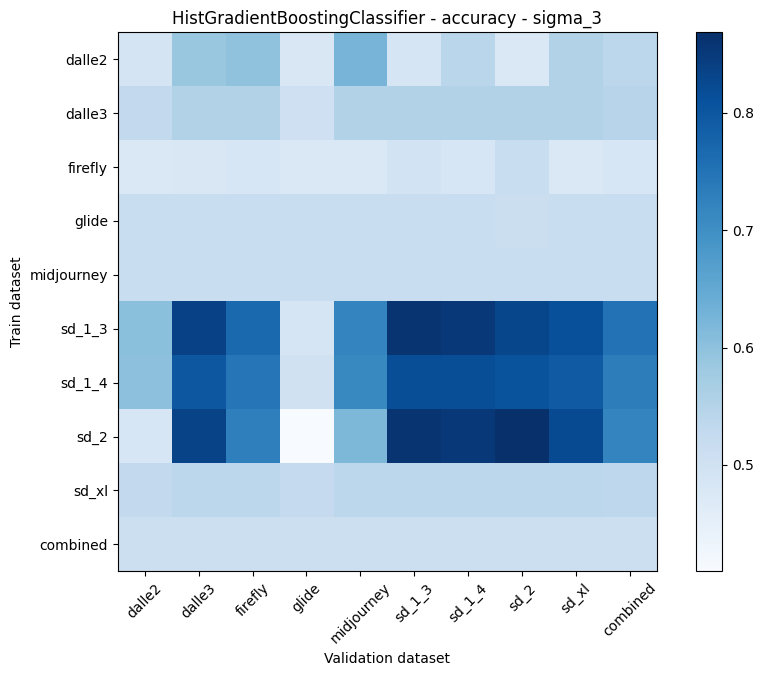

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.490625  0.587500  0.596875  0.478125    0.625000  0.487500   
dalle3         0.528125  0.553125  0.553125  0.506250    0.553125  0.553125   
firefly        0.475000  0.478125  0.481250  0.475000    0.475000  0.493750   
glide          0.515625  0.515625  0.515625  0.515625    0.515625  0.515625   
midjourney     0.515625  0.515625  0.515625  0.515625    0.515625  0.515625   
sd_1_3         0.603125  0.837500  0.768750  0.487500    0.718750  0.859375   
sd_1_4         0.600000  0.800000  0.743750  0.500000    0.712500  0.815625   
sd_2           0.484375  0.834375  0.728125  0.409375    0.618750  0.859375   
sd_xl          0.528125  0.537500  0.537500  0.525000    0.537500  0.537500   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.540625  0.475000  0.553125  0.537153  
dalle3         0.553125  0.553125  0.553125  0.545139  
firefly        0.481250  0.515625  0.475000  0.483333  
glide          0.515625  0.512500  0.515625  0.515278  
midjourney     0.515625  0.515625  0.515625  0.515625  
sd_1_3         0.853125  0.828125  0.812500  0.752083  
sd_1_4         0.815625  0.806250  0.793750  0.731944  
sd_2           0.853125  0.868750  0.821875  0.719792  
sd_xl          0.537500  0.537500  0.537500  0.535069  
combined       0.509375  0.509375  0.509375  0.509375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.490625  0.587500  0.596875  0.478125    0.625000  0.487500   
dalle3         0.528125  0.553125  0.553125  0.506250    0.553125  0.553125   
firefly        0.475000  0.478125  0.481250  0.475000    0.475000  0.493750   
glide          0.515625  0.515625  0.515625  0.515625    0.515625  0.515625   
midjourney     0.515625  0.515625  0.515625  0.515625    0.515625  0.515625   
sd_1_3         0.603125  0.837500  0.768750  0.487500    0.718750  0.859375   
sd_1_4         0.600000  0.800000  0.743750  0.500000    0.712500  0.815625   
sd_2           0.484375  0.834375  0.728125  0.409375    0.618750  0.859375   
sd_xl          0.528125  0.537500  0.537500  0.525000    0.537500  0.537500   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.540625  0.475000  0.553125  0.537153  
dalle3         0.553125  0.553125  0.553125  0.545139  
firefly        0.481250  0.515625  0.475000  0.483333  
glide          0.515625  0.512500  0.515625  0.515278  
midjourney     0.515625  0.515625  0.515625  0.515625  
sd_1_3         0.853125  0.828125  0.812500  0.752083  
sd_1_4         0.815625  0.806250  0.793750  0.731944  
sd_2           0.853125  0.868750  0.821875  0.719792  
sd_xl          0.537500  0.537500  0.537500  0.535069  
combined       0.509375  0.509375  0.509375  0.509375

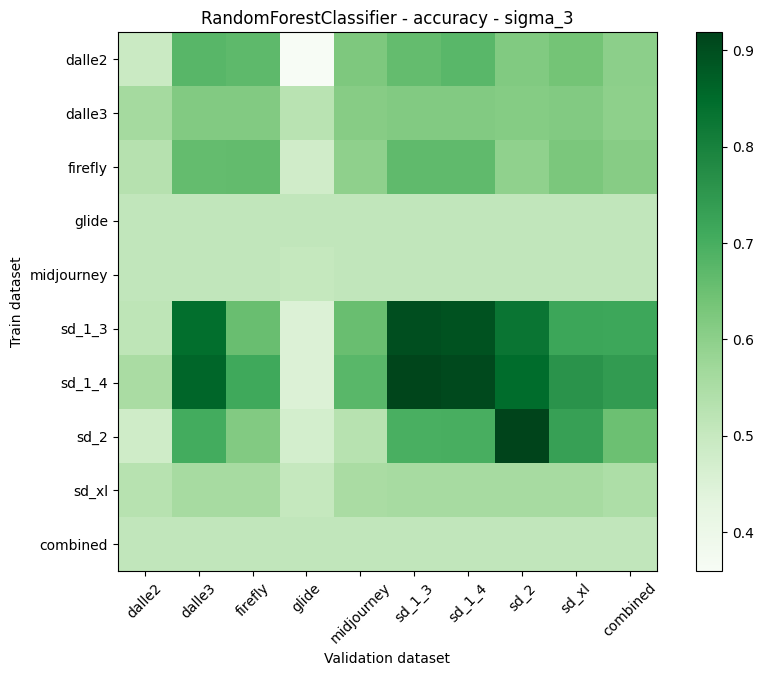

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.490625  0.678125  0.668750  0.359375    0.621875  0.659375   
dalle3         0.562500  0.615625  0.615625  0.525000    0.609375  0.615625   
firefly        0.531250  0.659375  0.662500  0.478125    0.596875  0.665625   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.509375  0.509375  0.509375  0.503125    0.509375  0.509375   
sd_1_3         0.515625  0.843750  0.653125  0.450000    0.653125  0.900000   
sd_1_4         0.553125  0.859375  0.712500  0.450000    0.675000  0.915625   
sd_2           0.481250  0.706250  0.615625  0.468750    0.528125  0.696875   
sd_xl          0.528125  0.556250  0.556250  0.503125    0.553125  0.556250   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.675000  0.618750  0.637500  0.601042  
dalle3         0.615625  0.612500  0.615625  0.598611  
firefly        0.665625  0.593750  0.628125  0.609028  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.509375  0.509375  0.509375  0.508681  
sd_1_3         0.893750  0.828125  0.718750  0.717361  
sd_1_4         0.909375  0.846875  0.759375  0.742361  
sd_2           0.700000  0.918750  0.731250  0.649653  
sd_xl          0.556250  0.556250  0.556250  0.546875  
combined       0.509375  0.509375  0.509375  0.509375

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.490625  0.678125  0.668750  0.359375    0.621875  0.659375   
dalle3         0.562500  0.615625  0.615625  0.525000    0.609375  0.615625   
firefly        0.531250  0.659375  0.662500  0.478125    0.596875  0.665625   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.509375  0.509375  0.509375  0.503125    0.509375  0.509375   
sd_1_3         0.515625  0.843750  0.653125  0.450000    0.653125  0.900000   
sd_1_4         0.553125  0.859375  0.712500  0.450000    0.675000  0.915625   
sd_2           0.481250  0.706250  0.615625  0.468750    0.528125  0.696875   
sd_xl          0.528125  0.556250  0.556250  0.503125    0.553125  0.556250   
combined       0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.675000  0.618750  0.637500  0.601042  
dalle3         0.615625  0.612500  0.615625  0.598611  
firefly        0.665625  0.593750  0.628125  0.609028  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.509375  0.509375  0.509375  0.508681  
sd_1_3         0.893750  0.828125  0.718750  0.717361  
sd_1_4         0.909375  0.846875  0.759375  0.742361  
sd_2           0.700000  0.918750  0.731250  0.649653  
sd_xl          0.556250  0.556250  0.556250  0.546875  
combined       0.509375  0.509375  0.509375  0.509375

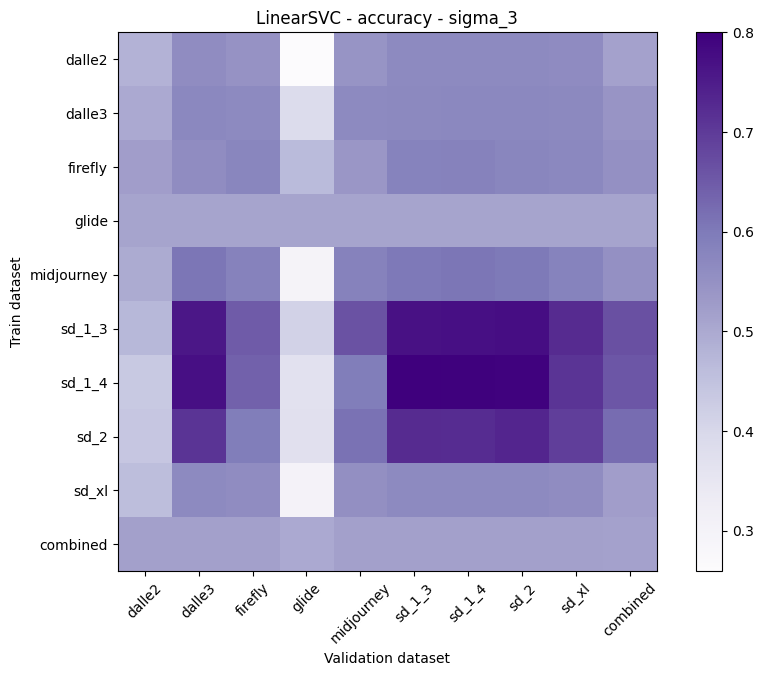

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.481250  0.559375  0.546875  0.259375    0.543750  0.565625   
dalle3         0.500000  0.571875  0.565625  0.387500    0.565625  0.568750   
firefly        0.521875  0.559375  0.575000  0.465625    0.537500  0.581250   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.496875  0.606250  0.584375  0.296875    0.584375  0.603125   
sd_1_3         0.471875  0.759375  0.650000  0.412500    0.662500  0.768750   
sd_1_4         0.434375  0.771875  0.637500  0.368750    0.593750  0.800000   
sd_2           0.440625  0.709375  0.593750  0.371875    0.612500  0.725000   
sd_xl          0.459375  0.565625  0.559375  0.300000    0.553125  0.565625   
combined       0.518750  0.518750  0.518750  0.500000    0.518750  0.518750   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.565625  0.565625  0.562500  0.516667  
dalle3         0.571875  0.571875  0.568750  0.541319  
firefly        0.584375  0.575000  0.571875  0.552431  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.606250  0.600000  0.581250  0.551042  
sd_1_3         0.771875  0.775000  0.725000  0.666319  
sd_1_4         0.796875  0.793750  0.709375  0.656250  
sd_2           0.721875  0.734375  0.693750  0.622569  
sd_xl          0.565625  0.565625  0.559375  0.521528  
combined       0.518750  0.518750  0.518750  0.516667

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.481250  0.559375  0.546875  0.259375    0.543750  0.565625   
dalle3         0.500000  0.571875  0.565625  0.387500    0.565625  0.568750   
firefly        0.521875  0.559375  0.575000  0.465625    0.537500  0.581250   
glide          0.509375  0.509375  0.509375  0.509375    0.509375  0.509375   
midjourney     0.496875  0.606250  0.584375  0.296875    0.584375  0.603125   
sd_1_3         0.471875  0.759375  0.650000  0.412500    0.662500  0.768750   
sd_1_4         0.434375  0.771875  0.637500  0.368750    0.593750  0.800000   
sd_2           0.440625  0.709375  0.593750  0.371875    0.612500  0.725000   
sd_xl          0.459375  0.565625  0.559375  0.300000    0.553125  0.565625   
combined       0.518750  0.518750  0.518750  0.500000    0.518750  0.518750   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.565625  0.565625  0.562500  0.516667  
dalle3         0.571875  0.571875  0.568750  0.541319  
firefly        0.584375  0.575000  0.571875  0.552431  
glide          0.509375  0.509375  0.509375  0.509375  
midjourney     0.606250  0.600000  0.581250  0.551042  
sd_1_3         0.771875  0.775000  0.725000  0.666319  
sd_1_4         0.796875  0.793750  0.709375  0.656250  
sd_2           0.721875  0.734375  0.693750  0.622569  
sd_xl          0.565625  0.565625  0.559375  0.521528  
combined       0.518750  0.518750  0.518750  0.516667

In [12]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]
    
    metric = "accuracy"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Validation

########################### MCC ###########################








 ################ Evaluating models trained on standard and tested on standard. ################


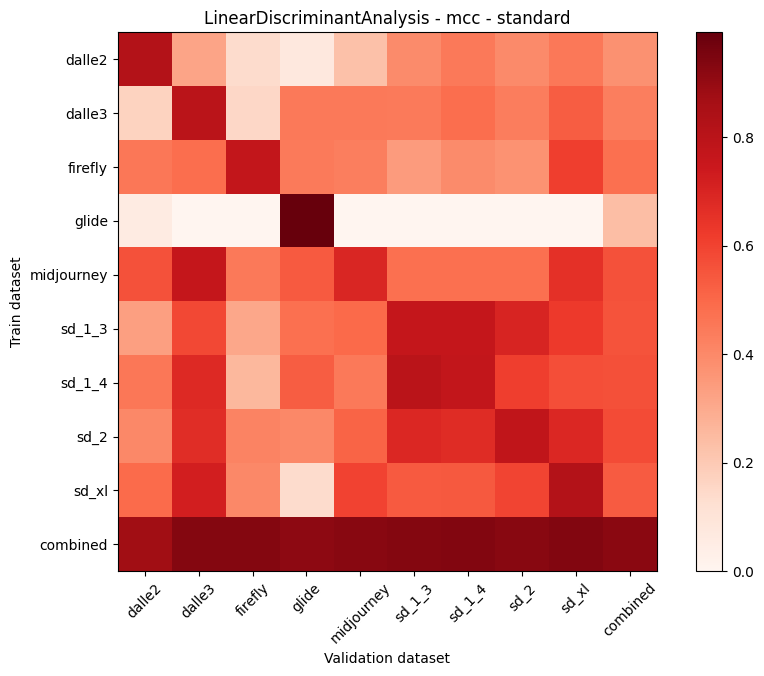

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.819192  0.314882  0.136325  0.077097    0.228967  0.393389   
dalle3         0.167182  0.795888  0.154417  0.448403    0.448403  0.442693   
firefly        0.455899  0.483869  0.770198  0.444730    0.433563  0.343691   
glide          0.054949  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.561035  0.764972  0.447007  0.537907    0.693657  0.475220   
sd_1_3         0.332120  0.583665  0.309123  0.473828    0.496616  0.765826   
sd_1_4         0.457664  0.681657  0.258750  0.530306    0.446543  0.796004   
sd_2           0.401973  0.668685  0.418861  0.401973    0.509273  0.687371   
sd_xl          0.490907  0.719496  0.400277  0.137974    0.601502  0.536861   
combined       0.874956  0.932634  0.932634  0.913051    0.926064  0.932634   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.447081  0.398824  0.452386  0.374524  
dalle3         0.482794  0.436989  0.529181  0.432555  
firefly        0.394429  0.371964  0.609480  0.476401  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.475220  0.475220  0.656365  0.562327  
sd_1_3         0.765826  0.700177  0.625571  0.556241  
sd_1_4         0.769646  0.610338  0.569991  0.564919  
sd_2           0.674886  0.778417  0.687371  0.576586  
sd_xl          0.542659  0.595537  0.821256  0.534932  
combined       0.939247  0.926064  0.939247  0.923884

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.819192  0.314882  0.136325  0.077097    0.228967  0.393389   
dalle3         0.167182  0.795888  0.154417  0.448403    0.448403  0.442693   
firefly        0.455899  0.483869  0.770198  0.444730    0.433563  0.343691   
glide          0.054949  0.000000  0.000000  0.993768    0.000000  0.000000   
midjourney     0.561035  0.764972  0.447007  0.537907    0.693657  0.475220   
sd_1_3         0.332120  0.583665  0.309123  0.473828    0.496616  0.765826   
sd_1_4         0.457664  0.681657  0.258750  0.530306    0.446543  0.796004   
sd_2           0.401973  0.668685  0.418861  0.401973    0.509273  0.687371   
sd_xl          0.490907  0.719496  0.400277  0.137974    0.601502  0.536861   
combined       0.874956  0.932634  0.932634  0.913051    0.926064  0.932634   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.447081  0.398824  0.452386  0.363127  
dalle3         0.482794  0.436989  0.529181  0.433994  
firefly        0.394429  0.371964  0.609480  0.478647  
glide          0.000000  0.000000  0.000000  0.116524  
midjourney     0.475220  0.475220  0.656365  0.565178  
sd_1_3         0.765826  0.700177  0.625571  0.561417  
sd_1_4         0.769646  0.610338  0.569991  0.568989  
sd_2           0.674886  0.778417  0.687371  0.580979  
sd_xl          0.542659  0.595537  0.821256  0.538497  
combined       0.939247  0.926064  0.939247  0.924059

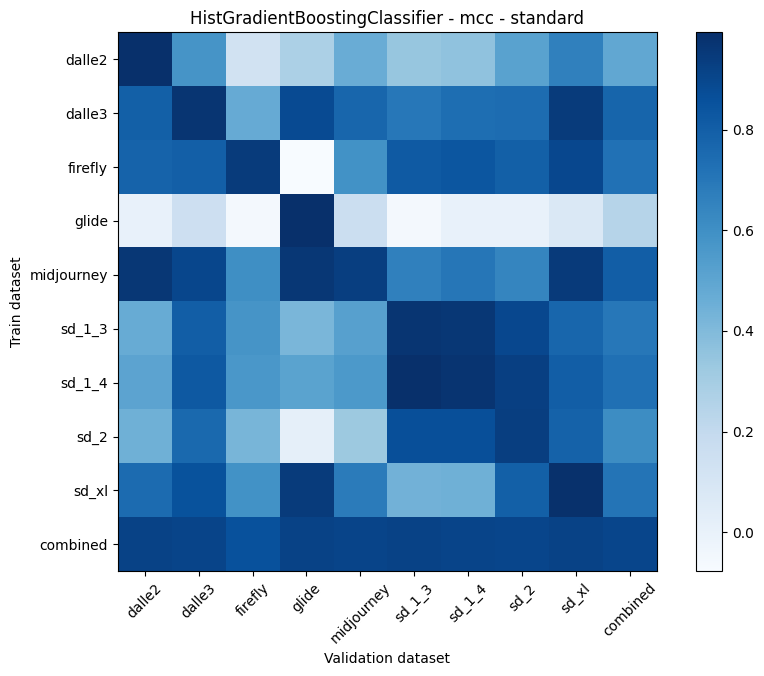

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993766  0.576090  0.129144  0.275433    0.465291  0.340942   
dalle3         0.793174  0.968899  0.473955  0.883448    0.771571  0.698278   
firefly        0.782331  0.798629  0.943755 -0.077969    0.587928  0.820677   
glide         -0.001487  0.150860 -0.057049  0.993766    0.160815 -0.057049   
midjourney     0.963139  0.900293  0.600920  0.963139    0.931236  0.662044   
sd_1_3         0.469378  0.802309  0.576441  0.419107    0.523209  0.968762   
sd_1_4         0.504199  0.825715  0.566530  0.509021    0.556970  0.993766   
sd_2           0.448688  0.755581  0.423032  0.015715    0.325078  0.865990   
sd_xl          0.747294  0.852932  0.590440  0.944680    0.682347  0.440556   
combined       0.915852  0.909091  0.856534  0.915852    0.909091  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.357520  0.513836  0.662773  0.488606  
dalle3         0.734517  0.745014  0.943755  0.773359  
firefly        0.837469  0.793174  0.895240  0.725242  
glide         -0.001487 -0.001487  0.073243  0.243514  
midjourney     0.703631  0.641532  0.950256  0.804825  
sd_1_3         0.962571  0.896833  0.770567  0.700633  
sd_1_4         0.975073  0.926871  0.804360  0.729857  
sd_2           0.865990  0.931414  0.787742  0.611588  
sd_xl          0.445536  0.793812  0.987496  0.712595  
combined       0.909091  0.902374  0.915852  0.905354

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.993766  0.576090  0.129144  0.275433    0.465291  0.340942   
dalle3         0.793174  0.968899  0.473955  0.883448    0.771571  0.698278   
firefly        0.782331  0.798629  0.943755 -0.077969    0.587928  0.820677   
glide         -0.001487  0.150860 -0.057049  0.993766    0.160815 -0.057049   
midjourney     0.963139  0.900293  0.600920  0.963139    0.931236  0.662044   
sd_1_3         0.469378  0.802309  0.576441  0.419107    0.523209  0.968762   
sd_1_4         0.504199  0.825715  0.566530  0.509021    0.556970  0.993766   
sd_2           0.448688  0.755581  0.423032  0.015715    0.325078  0.865990   
sd_xl          0.747294  0.852932  0.590440  0.944680    0.682347  0.440556   
combined       0.915852  0.909091  0.856534  0.915852    0.909091  0.915852   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.357520  0.513836  0.662773  0.479422  
dalle3         0.734517  0.745014  0.943755  0.779179  
firefly        0.837469  0.793174  0.895240  0.709026  
glide         -0.001487 -0.001487  0.073243  0.140014  
midjourney     0.703631  0.641532  0.950256  0.812910  
sd_1_3         0.962571  0.896833  0.770567  0.709909  
sd_1_4         0.975073  0.926871  0.804360  0.740278  
sd_2           0.865990  0.931414  0.787742  0.602137  
sd_xl          0.445536  0.793812  0.987496  0.720566  
combined       0.909091  0.902374  0.915852  0.905510

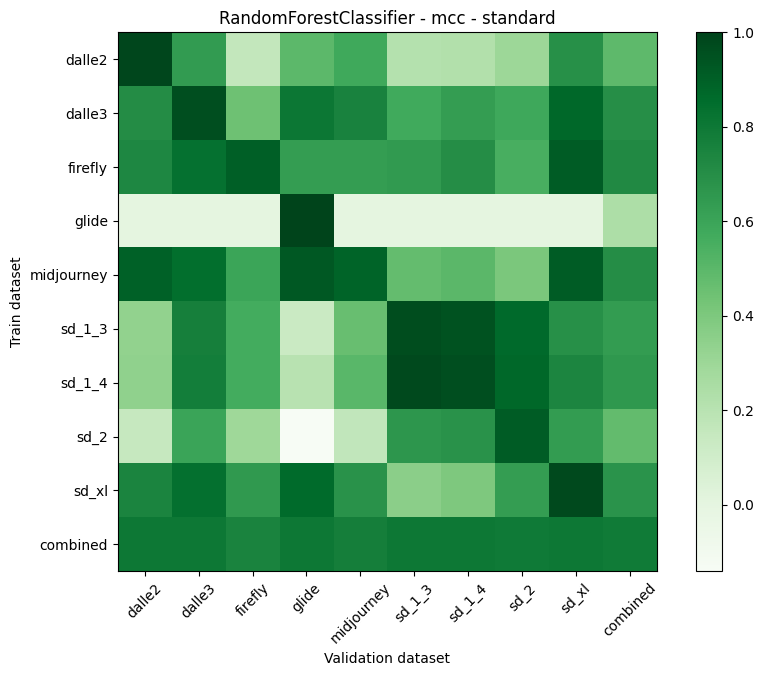

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.643343  0.160815  0.494531    0.580872  0.212470   
dalle3         0.706137  0.962487  0.443828  0.805820    0.752551  0.572212   
firefly        0.731648  0.833376  0.906224  0.630844    0.630844  0.646451   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.893743  0.845196  0.594728  0.925228    0.887556  0.471859   
sd_1_3         0.333140  0.765346  0.566771  0.127912    0.464424  0.968762   
sd_1_4         0.338817  0.775808  0.566771  0.201753    0.503749  0.981260   
sd_2           0.145945  0.600920  0.295217 -0.140849    0.162983  0.662044   
sd_xl          0.742125  0.838831  0.650876  0.861345    0.680850  0.354237   
combined       0.799818  0.799818  0.748173  0.799818    0.769983  0.799818   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.220124  0.300297  0.692198  0.490762  
dalle3         0.631074  0.581988  0.872767  0.697673  
firefly        0.704606  0.553784  0.912520  0.723188  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.497571  0.403710  0.912520  0.704606  
sd_1_3         0.950303  0.862600  0.688961  0.637418  
sd_1_4         0.962571  0.873895  0.739501  0.656491  
sd_2           0.682733  0.912561  0.636428  0.477747  
sd_xl          0.397402  0.631074  0.981410  0.676385  
combined       0.799818  0.792275  0.799818  0.789773

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.987496  0.643343  0.160815  0.494531    0.580872  0.212470   
dalle3         0.706137  0.962487  0.443828  0.805820    0.752551  0.572212   
firefly        0.731648  0.833376  0.906224  0.630844    0.630844  0.646451   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.893743  0.845196  0.594728  0.925228    0.887556  0.471859   
sd_1_3         0.333140  0.765346  0.566771  0.127912    0.464424  0.968762   
sd_1_4         0.338817  0.775808  0.566771  0.201753    0.503749  0.981260   
sd_2           0.145945  0.600920  0.295217 -0.140849    0.162983  0.662044   
sd_xl          0.742125  0.838831  0.650876  0.861345    0.680850  0.354237   
combined       0.799818  0.799818  0.748173  0.799818    0.769983  0.799818   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.220124  0.300297  0.692198  0.476905  
dalle3         0.631074  0.581988  0.872767  0.703207  
firefly        0.704606  0.553784  0.912520  0.727811  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.497571  0.403710  0.912520  0.714679  
sd_1_3         0.950303  0.862600  0.688961  0.636469  
sd_1_4         0.962571  0.873895  0.739501  0.660458  
sd_2           0.682733  0.912561  0.636428  0.439776  
sd_xl          0.397402  0.631074  0.981410  0.682016  
combined       0.799818  0.792275  0.799818  0.789927

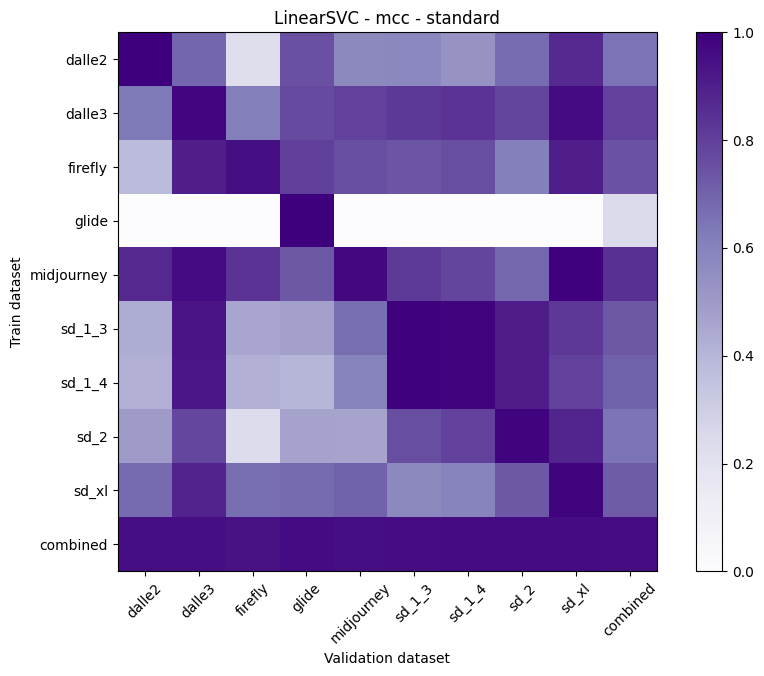

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.690720  0.225154  0.750104    0.571347  0.576069   
dalle3         0.631074  0.975062  0.616296  0.768324    0.795002  0.816728   
firefly        0.375431  0.901184  0.949982  0.798629    0.755581  0.734517   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.869566  0.962805  0.836529  0.727062    0.968920  0.814993   
sd_1_3         0.435558  0.932773  0.455445  0.479961    0.667652  0.993766   
sd_1_4         0.420443  0.926871  0.420443  0.399961    0.595228  0.993766   
sd_2           0.494531  0.778140  0.234850  0.470194    0.465291  0.757507   
sd_xl          0.679008  0.885305  0.664157  0.674047    0.703981  0.571606   
combined       0.950256  0.950256  0.943877  0.963139    0.950256  0.956677   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.528806  0.671317  0.865533  0.651002  
dalle3         0.838831  0.784270  0.962487  0.793805  
firefly        0.755581  0.612691  0.901184  0.747942  
glide          0.000000  0.000000  0.000000  0.240384  
midjourney     0.783344  0.687267  0.993766  0.845006  
sd_1_3         0.981265  0.903585  0.820343  0.729298  
sd_1_4         0.981265  0.903585  0.793812  0.703197  
sd_2           0.793812  0.981265  0.880791  0.647111  
sd_xl          0.595799  0.729279  0.981260  0.715743  
combined       0.963139  0.963139  0.963139  0.955962

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         1.000000  0.690720  0.225154  0.750104    0.571347  0.576069   
dalle3         0.631074  0.975062  0.616296  0.768324    0.795002  0.816728   
firefly        0.375431  0.901184  0.949982  0.798629    0.755581  0.734517   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.869566  0.962805  0.836529  0.727062    0.968920  0.814993   
sd_1_3         0.435558  0.932773  0.455445  0.479961    0.667652  0.993766   
sd_1_4         0.420443  0.926871  0.420443  0.399961    0.595228  0.993766   
sd_2           0.494531  0.778140  0.234850  0.470194    0.465291  0.757507   
sd_xl          0.679008  0.885305  0.664157  0.674047    0.703981  0.571606   
combined       0.950256  0.950256  0.943877  0.963139    0.950256  0.956677   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.528806  0.671317  0.865533  0.653228  
dalle3         0.838831  0.784270  0.962487  0.798675  
firefly        0.755581  0.612691  0.901184  0.753865  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.783344  0.687267  0.993766  0.849362  
sd_1_3         0.981265  0.903585  0.820343  0.741150  
sd_1_4         0.981265  0.903585  0.793812  0.715042  
sd_2           0.793812  0.981265  0.880791  0.650709  
sd_xl          0.595799  0.729279  0.981260  0.720493  
combined       0.963139  0.963139  0.963139  0.955987









 ################ Evaluating models trained on standard and tested on sigma_1. ################


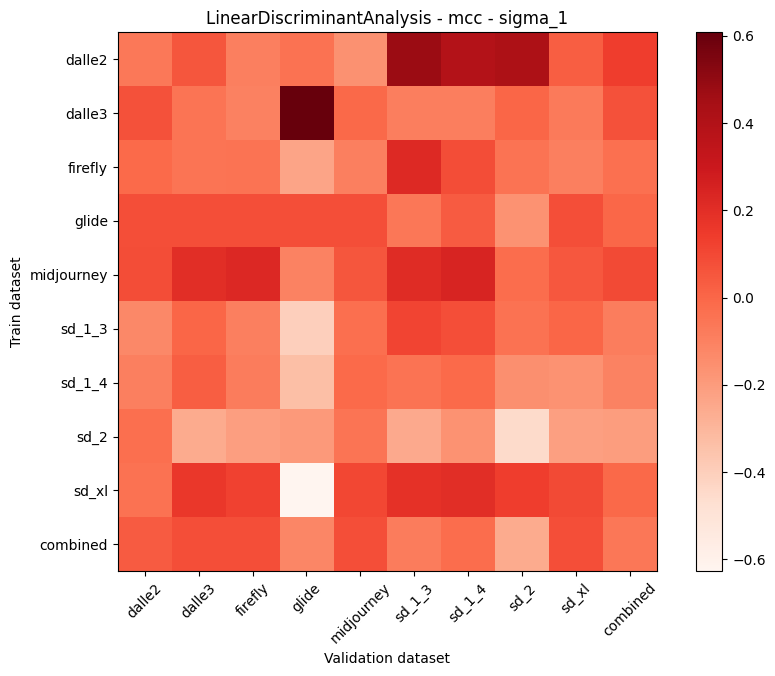

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.066536  0.057686 -0.092985 -0.041278   -0.160432  0.474901   
dalle3         0.068518 -0.050052 -0.100272  0.608157   -0.006251 -0.086985   
firefly       -0.011009 -0.052412 -0.045641 -0.234062   -0.092105  0.221645   
glide          0.080806  0.080806  0.080806  0.080806    0.080806 -0.061298   
midjourney     0.083105  0.199840  0.222274 -0.104663    0.057505  0.210924   
sd_1_3        -0.127246  0.004842 -0.092068 -0.400838   -0.031085  0.114683   
sd_1_4        -0.093408  0.026208 -0.078011 -0.335854   -0.011223 -0.045769   
sd_2          -0.029078 -0.257711 -0.210066 -0.192069   -0.048836 -0.251774   
sd_xl         -0.041622  0.160518  0.125376 -0.627158    0.103502  0.185779   
combined       0.034257  0.080806  0.080806 -0.116549    0.080806 -0.077075   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.394308  0.417238  0.028760  0.136504  
dalle3        -0.086985  0.003918 -0.074215  0.071355  
firefly        0.086807 -0.045641 -0.092105 -0.037298  
glide          0.034257 -0.167790  0.080806 -0.003918  
midjourney     0.245840 -0.020820  0.049216  0.092888  
sd_1_3         0.078094 -0.042126  0.004842 -0.083739  
sd_1_4        -0.011223 -0.151148 -0.164784 -0.105090  
sd_2          -0.167908 -0.449807 -0.216045 -0.204077  
sd_xl          0.199046  0.136758  0.092974 -0.006348  
combined      -0.022839 -0.259664  0.080806 -0.061298

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.066536  0.057686 -0.092985 -0.041278   -0.160432  0.474901   
dalle3         0.068518 -0.050052 -0.100272  0.608157   -0.006251 -0.086985   
firefly       -0.011009 -0.052412 -0.045641 -0.234062   -0.092105  0.221645   
glide          0.080806  0.080806  0.080806  0.080806    0.080806 -0.061298   
midjourney     0.083105  0.199840  0.222274 -0.104663    0.057505  0.210924   
sd_1_3        -0.127246  0.004842 -0.092068 -0.400838   -0.031085  0.114683   
sd_1_4        -0.093408  0.026208 -0.078011 -0.335854   -0.011223 -0.045769   
sd_2          -0.029078 -0.257711 -0.210066 -0.192069   -0.048836 -0.251774   
sd_xl         -0.041622  0.160518  0.125376 -0.627158    0.103502  0.185779   
combined       0.034257  0.080806  0.080806 -0.116549    0.080806 -0.077075   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.394308  0.417238  0.028760  0.112407  
dalle3        -0.086985  0.003918 -0.074215  0.030648  
firefly        0.086807 -0.045641 -0.092105 -0.029391  
glide          0.034257 -0.167790  0.080806  0.032223  
midjourney     0.245840 -0.020820  0.049216  0.104802  
sd_1_3         0.078094 -0.042126  0.004842 -0.054545  
sd_1_4        -0.011223 -0.151148 -0.164784 -0.096135  
sd_2          -0.167908 -0.449807 -0.216045 -0.202588  
sd_xl          0.199046  0.136758  0.092974  0.037241  
combined      -0.022839 -0.259664  0.080806 -0.013183

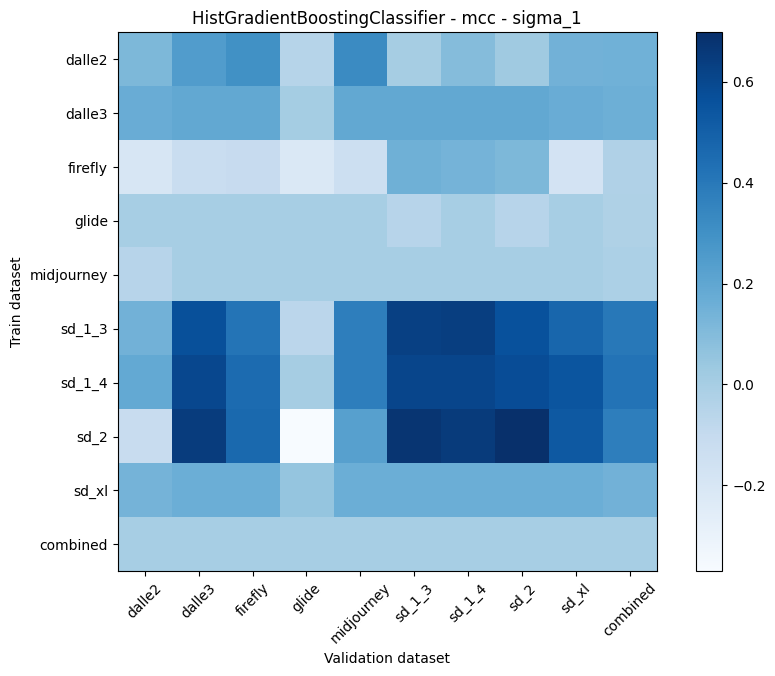

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.117040  0.246900  0.301060 -0.050052    0.324226  0.003918   
dalle3         0.168218  0.192248  0.192248  0.005095    0.192248  0.192248   
firefly       -0.196390 -0.123742 -0.108140 -0.217945   -0.140234  0.152676   
glide          0.000000  0.000000  0.000000  0.000000    0.000000 -0.054949   
midjourney    -0.054949  0.000000  0.000000  0.000000    0.000000  0.000000   
sd_1_3         0.143775  0.568493  0.415987 -0.066291    0.374190  0.628456   
sd_1_4         0.186627  0.598648  0.455510  0.001292    0.373534  0.607894   
sd_2          -0.117430  0.643754  0.463211 -0.370574    0.229486  0.674357   
sd_xl          0.135525  0.163159  0.163159  0.051355    0.163159  0.163159   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.093419  0.023471  0.146876  0.148485  
dalle3         0.192248  0.192248  0.168218  0.158256  
firefly        0.137729  0.114381 -0.176394 -0.029762  
glide          0.000000 -0.054949  0.000000 -0.025872  
midjourney     0.000000  0.000000  0.000000 -0.018291  
sd_1_3         0.637384  0.560258  0.474220  0.398783  
sd_1_4         0.607894  0.580474  0.545315  0.421584  
sd_2           0.651316  0.697963  0.529522  0.375467  
sd_xl          0.163159  0.163159  0.163159  0.144330  
combined       0.000000  0.000000  0.000000  0.000000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.117040  0.246900  0.301060 -0.050052    0.324226  0.003918   
dalle3         0.168218  0.192248  0.192248  0.005095    0.192248  0.192248   
firefly       -0.196390 -0.123742 -0.108140 -0.217945   -0.140234  0.152676   
glide          0.000000  0.000000  0.000000  0.000000    0.000000 -0.054949   
midjourney    -0.054949  0.000000  0.000000  0.000000    0.000000  0.000000   
sd_1_3         0.143775  0.568493  0.415987 -0.066291    0.374190  0.628456   
sd_1_4         0.186627  0.598648  0.455510  0.001292    0.373534  0.607894   
sd_2          -0.117430  0.643754  0.463211 -0.370574    0.229486  0.674357   
sd_xl          0.135525  0.163159  0.163159  0.051355    0.163159  0.163159   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.093419  0.023471  0.146876  0.134095  
dalle3         0.192248  0.192248  0.168218  0.166113  
firefly        0.137729  0.114381 -0.176394 -0.062007  
glide          0.000000 -0.054949  0.000000 -0.012211  
midjourney     0.000000  0.000000  0.000000 -0.006105  
sd_1_3         0.637384  0.560258  0.474220  0.415164  
sd_1_4         0.607894  0.580474  0.545315  0.439687  
sd_2           0.651316  0.697963  0.529522  0.377956  
sd_xl          0.163159  0.163159  0.163159  0.147666  
combined       0.000000  0.000000  0.000000  0.000000

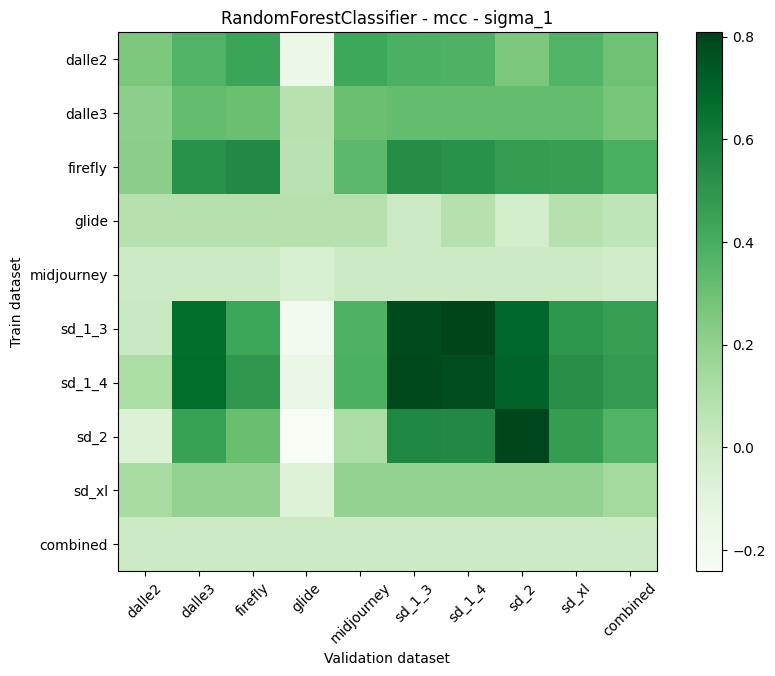

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.259858  0.373364  0.443172 -0.155294    0.427196  0.388437   
dalle3         0.212040  0.321660  0.306276  0.076935    0.306276  0.321660   
firefly        0.214907  0.516098  0.553975  0.073305    0.342262  0.534795   
glide          0.080806  0.080806  0.080806  0.080806    0.080806  0.002110   
midjourney     0.000000  0.000000  0.000000 -0.054949    0.000000  0.000000   
sd_1_3         0.015263  0.668635  0.432691 -0.204509    0.381644  0.787484   
sd_1_4         0.116677  0.670352  0.490732 -0.145800    0.386014  0.788216   
sd_2          -0.072175  0.454110  0.309666 -0.241350    0.114668  0.562488   
sd_xl          0.126259  0.192248  0.192248 -0.079752    0.192248  0.192248   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.380872  0.259858  0.373364  0.297244  
dalle3         0.321660  0.321660  0.321660  0.270924  
firefly        0.516098  0.471266  0.462600  0.396373  
glide          0.080806 -0.022839  0.080806  0.052405  
midjourney     0.000000  0.000000  0.000000 -0.018291  
sd_1_3         0.808572  0.687655  0.495427  0.462382  
sd_1_4         0.773661  0.703750  0.526417  0.478298  
sd_2           0.551579  0.799945  0.470343  0.367064  
sd_xl          0.192248  0.192248  0.192248  0.137218  
combined       0.000000  0.000000  0.000000  0.000000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.259858  0.373364  0.443172 -0.155294    0.427196  0.388437   
dalle3         0.212040  0.321660  0.306276  0.076935    0.306276  0.321660   
firefly        0.214907  0.516098  0.553975  0.073305    0.342262  0.534795   
glide          0.080806  0.080806  0.080806  0.080806    0.080806  0.002110   
midjourney     0.000000  0.000000  0.000000 -0.054949    0.000000  0.000000   
sd_1_3         0.015263  0.668635  0.432691 -0.204509    0.381644  0.787484   
sd_1_4         0.116677  0.670352  0.490732 -0.145800    0.386014  0.788216   
sd_2          -0.072175  0.454110  0.309666 -0.241350    0.114668  0.562488   
sd_xl          0.126259  0.192248  0.192248 -0.079752    0.192248  0.192248   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.380872  0.259858  0.373364  0.305648  
dalle3         0.321660  0.321660  0.321660  0.278869  
firefly        0.516098  0.471266  0.462600  0.409478  
glide          0.080806 -0.022839  0.080806  0.060546  
midjourney     0.000000  0.000000  0.000000 -0.006105  
sd_1_3         0.808572  0.687655  0.495427  0.452540  
sd_1_4         0.773661  0.703750  0.526417  0.478891  
sd_2           0.551579  0.799945  0.470343  0.327697  
sd_xl          0.192248  0.192248  0.192248  0.154693  
combined       0.000000  0.000000  0.000000  0.000000

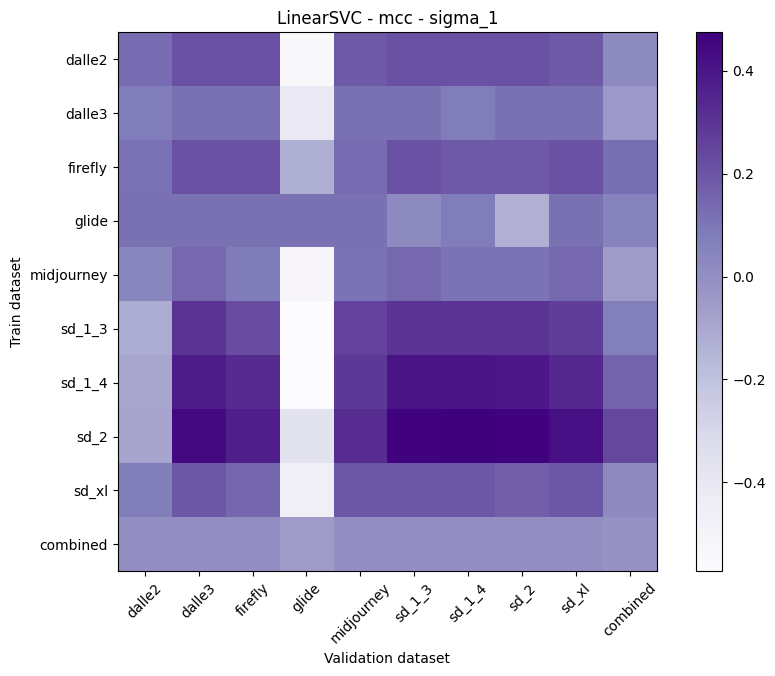

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.129864  0.209675  0.209675 -0.539204    0.187383  0.209675   
dalle3         0.077969  0.114638  0.114638 -0.412632    0.114638  0.114638   
firefly        0.113103  0.209675  0.209675 -0.125223    0.129864  0.209675   
glide          0.114638  0.114638  0.114638  0.114638    0.114638  0.024172   
midjourney     0.039296  0.140849  0.083081 -0.520442    0.109642  0.140849   
sd_1_3        -0.112506  0.303010  0.228046 -0.572687    0.256334  0.303010   
sd_1_4        -0.094489  0.376213  0.329115 -0.564365    0.285813  0.401456   
sd_2          -0.092446  0.441431  0.370708 -0.368788    0.324469  0.463183   
sd_xl          0.074121  0.192248  0.146347 -0.466243    0.192248  0.192248   
combined       0.000000  0.000000  0.000000 -0.054949    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.209675  0.209675  0.187383  0.023697  
dalle3         0.077969  0.114638  0.114638 -0.041259  
firefly        0.187383  0.187383  0.209675  0.126050  
glide          0.077969 -0.131077  0.114638  0.048678  
midjourney     0.109642  0.109642  0.140849 -0.054447  
sd_1_3         0.303010  0.303010  0.271278  0.069471  
sd_1_4         0.401456  0.388681  0.340503  0.152819  
sd_2           0.474355  0.463183  0.420413  0.237454  
sd_xl          0.192248  0.168218  0.192248  0.019015  
combined       0.000000  0.000000  0.000000 -0.018291

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.129864  0.209675  0.209675 -0.539204    0.187383  0.209675   
dalle3         0.077969  0.114638  0.114638 -0.412632    0.114638  0.114638   
firefly        0.113103  0.209675  0.209675 -0.125223    0.129864  0.209675   
glide          0.114638  0.114638  0.114638  0.114638    0.114638  0.024172   
midjourney     0.039296  0.140849  0.083081 -0.520442    0.109642  0.140849   
sd_1_3        -0.112506  0.303010  0.228046 -0.572687    0.256334  0.303010   
sd_1_4        -0.094489  0.376213  0.329115 -0.564365    0.285813  0.401456   
sd_2          -0.092446  0.441431  0.370708 -0.368788    0.324469  0.463183   
sd_xl          0.074121  0.192248  0.146347 -0.466243    0.192248  0.192248   
combined       0.000000  0.000000  0.000000 -0.054949    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.209675  0.209675  0.187383  0.112645  
dalle3         0.077969  0.114638  0.114638  0.047904  
firefly        0.187383  0.187383  0.209675  0.147912  
glide          0.077969 -0.131077  0.114638  0.073211  
midjourney     0.109642  0.109642  0.140849  0.039268  
sd_1_3         0.303010  0.303010  0.271278  0.142501  
sd_1_4         0.401456  0.388681  0.340503  0.207154  
sd_2           0.474355  0.463183  0.420413  0.277390  
sd_xl          0.192248  0.168218  0.192248  0.098187  
combined       0.000000  0.000000  0.000000 -0.006105









 ################ Evaluating models trained on standard and tested on sigma_2. ################


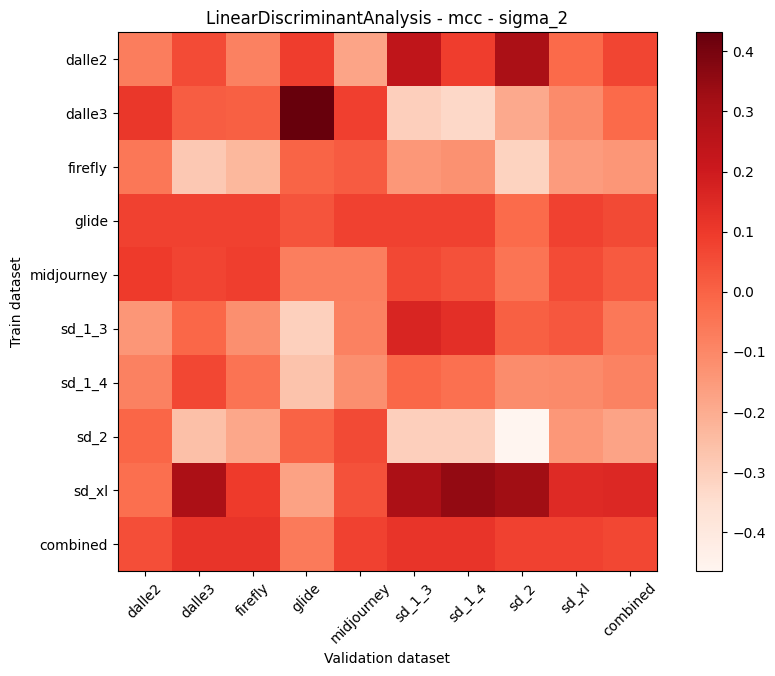

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.070370  0.056762 -0.082133  0.089346   -0.178031  0.240968   
dalle3         0.107262  0.013055  0.006584  0.431614    0.082576 -0.303102   
firefly       -0.051996 -0.281394 -0.230534 -0.002724    0.015917 -0.143775   
glide          0.080806  0.080806  0.080806  0.034257    0.080806  0.080806   
midjourney     0.096631  0.071888  0.088274 -0.074055   -0.074055  0.063849   
sd_1_3        -0.141765 -0.012440 -0.119922 -0.306771   -0.081405  0.162536   
sd_1_4        -0.082587  0.064855 -0.043579 -0.267019   -0.119116 -0.010134   
sd_2          -0.008167 -0.256383 -0.186626 -0.002004    0.060210 -0.302145   
sd_xl         -0.032770  0.295552  0.096091 -0.170803    0.039494  0.295552   
combined       0.048678  0.114638  0.114638 -0.062105    0.077969  0.114638   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.089346  0.300953 -0.016586  0.069700  
dalle3        -0.331558 -0.191952 -0.109055 -0.016674  
firefly       -0.125396 -0.313892 -0.156055 -0.142412  
glide          0.080806 -0.022839  0.080806  0.057487  
midjourney     0.040304 -0.046918  0.055908  0.021698  
sd_1_3         0.133571  0.006677  0.026751 -0.056762  
sd_1_4        -0.035423 -0.111982 -0.104766 -0.085093  
sd_2          -0.302145 -0.464769 -0.143173 -0.174154  
sd_xl          0.350186  0.325802  0.145142  0.154583  
combined       0.114638  0.077969  0.077969  0.064231

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.070370  0.056762 -0.082133  0.089346   -0.178031  0.240968   
dalle3         0.107262  0.013055  0.006584  0.431614    0.082576 -0.303102   
firefly       -0.051996 -0.281394 -0.230534 -0.002724    0.015917 -0.143775   
glide          0.080806  0.080806  0.080806  0.034257    0.080806  0.080806   
midjourney     0.096631  0.071888  0.088274 -0.074055   -0.074055  0.063849   
sd_1_3        -0.141765 -0.012440 -0.119922 -0.306771   -0.081405  0.162536   
sd_1_4        -0.082587  0.064855 -0.043579 -0.267019   -0.119116 -0.010134   
sd_2          -0.008167 -0.256383 -0.186626 -0.002004    0.060210 -0.302145   
sd_xl         -0.032770  0.295552  0.096091 -0.170803    0.039494  0.295552   
combined       0.048678  0.114638  0.114638 -0.062105    0.077969  0.114638   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.089346  0.300953 -0.016586  0.047806  
dalle3        -0.331558 -0.191952 -0.109055 -0.032731  
firefly       -0.125396 -0.313892 -0.156055 -0.143316  
glide          0.080806 -0.022839  0.080806  0.064118  
midjourney     0.040304 -0.046918  0.055908  0.024647  
sd_1_3         0.133571  0.006677  0.026751 -0.036974  
sd_1_4        -0.035423 -0.111982 -0.104766 -0.078861  
sd_2          -0.302145 -0.464769 -0.143173 -0.178356  
sd_xl          0.350186  0.325802  0.145142  0.149361  
combined       0.114638  0.077969  0.077969  0.075448

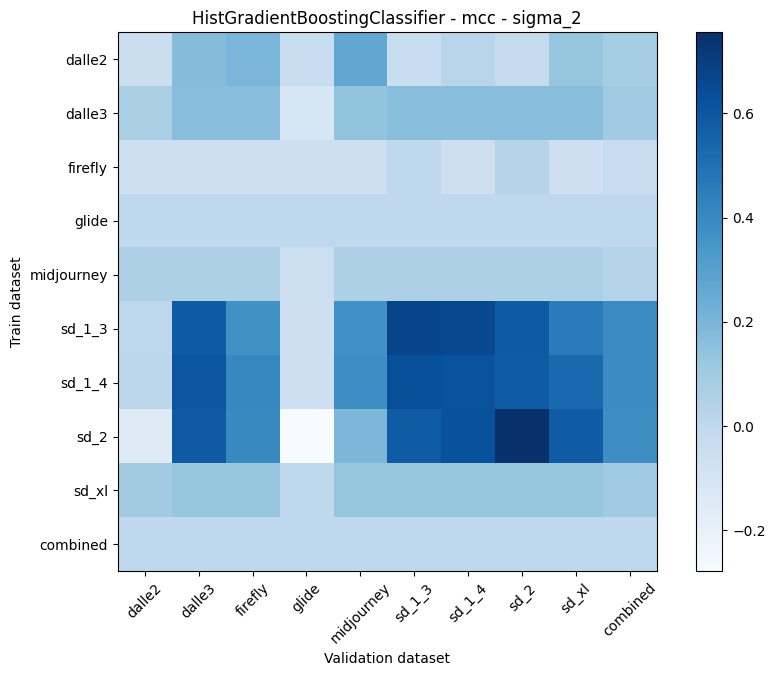

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.051336  0.171157  0.198572 -0.039428    0.268534 -0.039428   
dalle3         0.069508  0.163159  0.163159 -0.108820    0.135525  0.163159   
firefly       -0.057049 -0.057049 -0.057049 -0.057049   -0.057049 -0.001487   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.057049  0.057049  0.057049 -0.054154    0.057049  0.057049   
sd_1_3         0.004972  0.584962  0.369048 -0.059645    0.375496  0.673476   
sd_1_4         0.008663  0.605813  0.410119 -0.060015    0.382017  0.632460   
sd_2          -0.151288  0.587345  0.401171 -0.278383    0.195740  0.581058   
sd_xl          0.094764  0.128373  0.128373  0.003368    0.128373  0.128373   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.024473 -0.027930  0.127278  0.085563  
dalle3         0.163159  0.163159  0.163159  0.098743  
firefly       -0.057049  0.030609 -0.057049 -0.033561  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.057049  0.057049  0.057049  0.033561  
sd_1_3         0.656729  0.584962  0.455069  0.390639  
sd_1_4         0.614599  0.579993  0.530562  0.391311  
sd_2           0.619196  0.755392  0.581058  0.381798  
sd_xl          0.128373  0.128373  0.128373  0.105211  
combined       0.000000  0.000000  0.000000  0.000000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.051336  0.171157  0.198572 -0.039428    0.268534 -0.039428   
dalle3         0.069508  0.163159  0.163159 -0.108820    0.135525  0.163159   
firefly       -0.057049 -0.057049 -0.057049 -0.057049   -0.057049 -0.001487   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.057049  0.057049  0.057049 -0.054154    0.057049  0.057049   
sd_1_3         0.004972  0.584962  0.369048 -0.059645    0.375496  0.673476   
sd_1_4         0.008663  0.605813  0.410119 -0.060015    0.382017  0.632460   
sd_2          -0.151288  0.587345  0.401171 -0.278383    0.195740  0.581058   
sd_xl          0.094764  0.128373  0.128373  0.003368    0.128373  0.128373   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.024473 -0.027930  0.127278  0.070210  
dalle3         0.163159  0.163159  0.163159  0.119463  
firefly       -0.057049  0.030609 -0.057049 -0.041136  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.057049  0.057049  0.057049  0.044693  
sd_1_3         0.656729  0.584962  0.455069  0.405008  
sd_1_4         0.614599  0.579993  0.530562  0.411579  
sd_2           0.619196  0.755392  0.581058  0.365699  
sd_xl          0.128373  0.128373  0.128373  0.110749  
combined       0.000000  0.000000  0.000000  0.000000

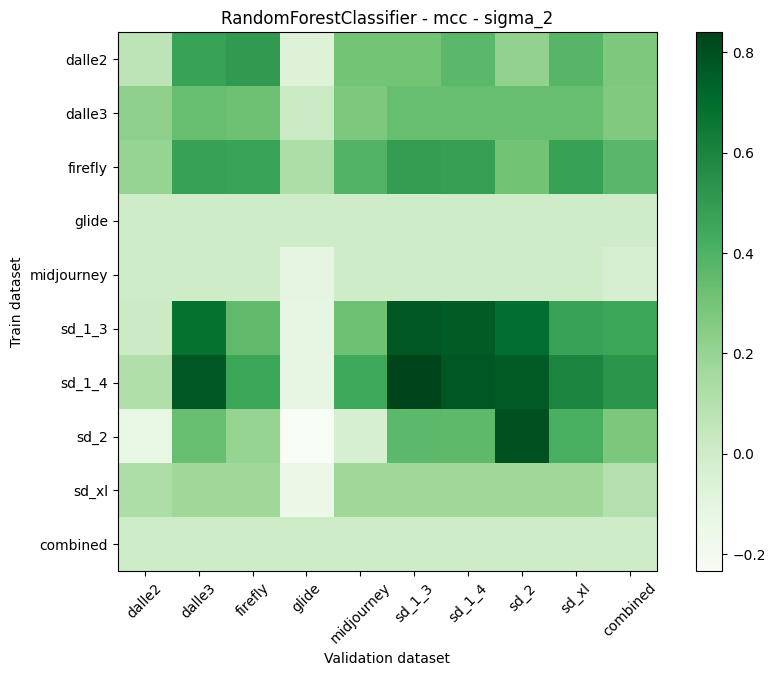

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.070993  0.470816  0.508112 -0.066202    0.300188  0.300188   
dalle3         0.226731  0.333715  0.318806  0.025024    0.276958  0.333715   
firefly        0.199556  0.476071  0.467999  0.123908    0.390924  0.492443   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.000000  0.000000  0.000000 -0.110419    0.000000  0.000000   
sd_1_3         0.012440  0.678887  0.352444 -0.119974    0.318328  0.774921   
sd_1_4         0.117762  0.774929  0.460236 -0.116420    0.443843  0.839587   
sd_2          -0.128621  0.335644  0.202129 -0.233758   -0.038583  0.363788   
sd_xl          0.123626  0.173335  0.173335 -0.147800    0.173335  0.173335   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.365863  0.211920  0.379354  0.276729  
dalle3         0.333715  0.333715  0.333715  0.268181  
firefly        0.484219  0.305446  0.476071  0.372159  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.000000  0.000000  0.000000 -0.036601  
sd_1_3         0.762532  0.690544  0.473397  0.457697  
sd_1_4         0.774929  0.762416  0.592272  0.527058  
sd_2           0.358201  0.793717  0.418801  0.278046  
sd_xl          0.173335  0.173335  0.173335  0.104672  
combined       0.000000  0.000000  0.000000  0.000000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.070993  0.470816  0.508112 -0.066202    0.300188  0.300188   
dalle3         0.226731  0.333715  0.318806  0.025024    0.276958  0.333715   
firefly        0.199556  0.476071  0.467999  0.123908    0.390924  0.492443   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.000000  0.000000  0.000000 -0.110419    0.000000  0.000000   
sd_1_3         0.012440  0.678887  0.352444 -0.119974    0.318328  0.774921   
sd_1_4         0.117762  0.774929  0.460236 -0.116420    0.443843  0.839587   
sd_2          -0.128621  0.335644  0.202129 -0.233758   -0.038583  0.363788   
sd_xl          0.123626  0.173335  0.173335 -0.147800    0.173335  0.173335   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.365863  0.211920  0.379354  0.282359  
dalle3         0.333715  0.333715  0.333715  0.279566  
firefly        0.484219  0.305446  0.476071  0.379626  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.000000  0.000000  0.000000 -0.012269  
sd_1_3         0.762532  0.690544  0.473397  0.438169  
sd_1_4         0.774929  0.762416  0.592272  0.516617  
sd_2           0.358201  0.793717  0.418801  0.230146  
sd_xl          0.173335  0.173335  0.173335  0.132130  
combined       0.000000  0.000000  0.000000  0.000000

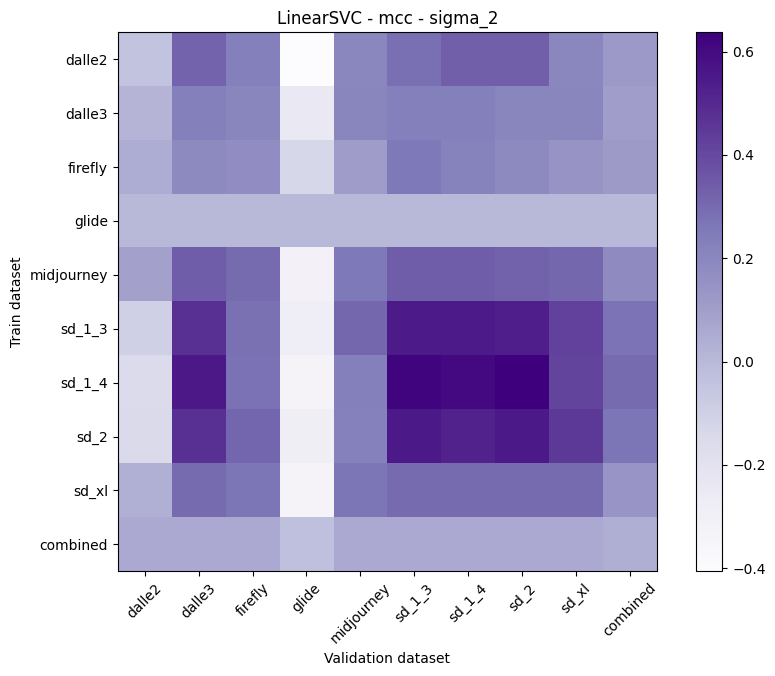

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.040003  0.322273  0.228524 -0.406044    0.197449  0.284973   
dalle3         0.016808  0.225964  0.205076 -0.243865    0.205076  0.225964   
firefly        0.047037  0.186739  0.171472 -0.132295    0.103908  0.255999   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.091902  0.339643  0.296986 -0.318170    0.258092  0.339643   
sd_1_3        -0.099902  0.476556  0.281120 -0.282799    0.310819  0.544093   
sd_1_4        -0.151188  0.552098  0.274966 -0.333545    0.230534  0.619624   
sd_2          -0.148924  0.474626  0.313971 -0.284372    0.222198  0.549000   
sd_xl          0.034270  0.296622  0.264329 -0.335952    0.264329  0.296622   
combined       0.057049  0.057049  0.057049 -0.030609    0.057049  0.057049   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.335387  0.335387  0.197449  0.122413  
dalle3         0.225964  0.205076  0.205076  0.100753  
firefly        0.219545  0.186739  0.142854  0.113602  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.339643  0.324955  0.310747  0.178413  
sd_1_3         0.544093  0.534045  0.423199  0.273831  
sd_1_4         0.602237  0.637384  0.415987  0.298648  
sd_2           0.520235  0.549000  0.448499  0.265983  
sd_xl          0.296622  0.296622  0.296622  0.140093  
combined       0.057049  0.057049  0.057049  0.040572

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.040003  0.322273  0.228524 -0.406044    0.197449  0.284973   
dalle3         0.016808  0.225964  0.205076 -0.243865    0.205076  0.225964   
firefly        0.047037  0.186739  0.171472 -0.132295    0.103908  0.255999   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.091902  0.339643  0.296986 -0.318170    0.258092  0.339643   
sd_1_3        -0.099902  0.476556  0.281120 -0.282799    0.310819  0.544093   
sd_1_4        -0.151188  0.552098  0.274966 -0.333545    0.230534  0.619624   
sd_2          -0.148924  0.474626  0.313971 -0.284372    0.222198  0.549000   
sd_xl          0.034270  0.296622  0.264329 -0.335952    0.264329  0.296622   
combined       0.057049  0.057049  0.057049 -0.030609    0.057049  0.057049   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.335387  0.335387  0.197449  0.161710  
dalle3         0.225964  0.205076  0.205076  0.141238  
firefly        0.219545  0.186739  0.142854  0.131333  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.339643  0.324955  0.310747  0.220382  
sd_1_3         0.544093  0.534045  0.423199  0.303469  
sd_1_4         0.602237  0.637384  0.415987  0.316455  
sd_2           0.520235  0.549000  0.448499  0.293804  
sd_xl          0.296622  0.296622  0.296622  0.190009  
combined       0.057049  0.057049  0.057049  0.047309









 ################ Evaluating models trained on standard and tested on sigma_3. ################


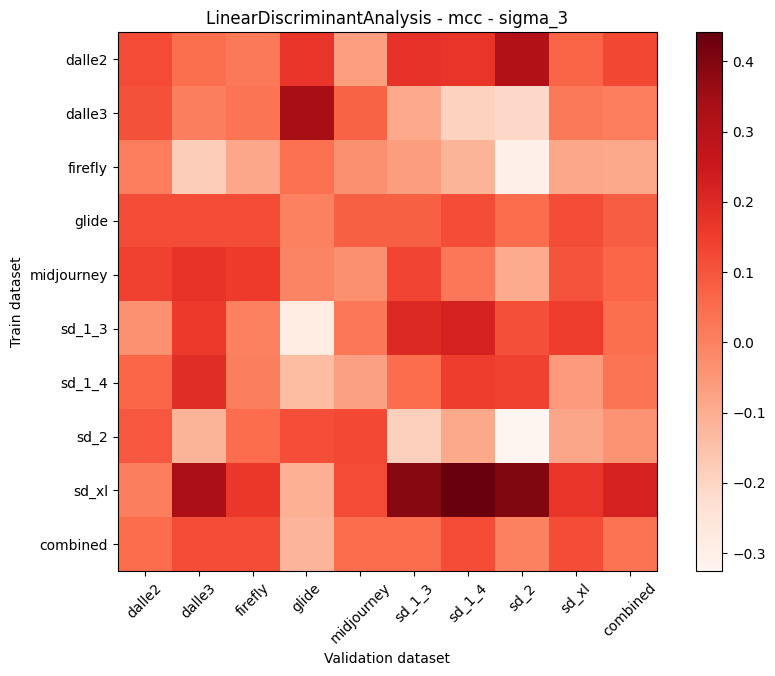

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.118003  0.046807  0.022553  0.168355   -0.069508  0.176103   
dalle3         0.108325  0.003704  0.028579  0.338378    0.071668 -0.092271   
firefly        0.010569 -0.180333 -0.087634  0.041574   -0.032491 -0.063128   
glide          0.114638  0.114638  0.114638  0.003003    0.077969  0.077969   
midjourney     0.140754  0.172050  0.156243 -0.007440   -0.033492  0.133121   
sd_1_3        -0.035440  0.157886  0.001699 -0.283301    0.025009  0.199840   
sd_1_4         0.066536  0.192412  0.009193 -0.138657   -0.071738  0.049575   
sd_2           0.093766 -0.117469  0.050878  0.112188    0.124497 -0.189925   
sd_xl          0.004540  0.324517  0.163843 -0.105103    0.119819  0.388526   
combined       0.048678  0.114638  0.114638 -0.120980    0.048678  0.048678   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.168355  0.314556  0.069020  0.128879  
dalle3        -0.195120 -0.209582  0.022380  0.012020  
firefly       -0.118339 -0.302693 -0.087634 -0.090359  
glide          0.114638  0.048678  0.114638  0.081614  
midjourney     0.025918 -0.096693  0.103276  0.061877  
sd_1_3         0.222274  0.109930  0.147931  0.043753  
sd_1_4         0.150226  0.140227 -0.057686  0.028598  
sd_2          -0.091880 -0.326020 -0.085533 -0.043651  
sd_xl          0.441279  0.400199  0.170017  0.220585  
combined       0.114638  0.003003  0.114638  0.034583

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.118003  0.046807  0.022553  0.168355   -0.069508  0.176103   
dalle3         0.108325  0.003704  0.028579  0.338378    0.071668 -0.092271   
firefly        0.010569 -0.180333 -0.087634  0.041574   -0.032491 -0.063128   
glide          0.114638  0.114638  0.114638  0.003003    0.077969  0.077969   
midjourney     0.140754  0.172050  0.156243 -0.007440   -0.033492  0.133121   
sd_1_3        -0.035440  0.157886  0.001699 -0.283301    0.025009  0.199840   
sd_1_4         0.066536  0.192412  0.009193 -0.138657   -0.071738  0.049575   
sd_2           0.093766 -0.117469  0.050878  0.112188    0.124497 -0.189925   
sd_xl          0.004540  0.324517  0.163843 -0.105103    0.119819  0.388526   
combined       0.048678  0.114638  0.114638 -0.120980    0.048678  0.048678   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.168355  0.314556  0.069020  0.112694  
dalle3        -0.195120 -0.209582  0.022380  0.008451  
firefly       -0.118339 -0.302693 -0.087634 -0.091123  
glide          0.114638  0.048678  0.114638  0.086757  
midjourney     0.025918 -0.096693  0.103276  0.065971  
sd_1_3         0.222274  0.109930  0.147931  0.060648  
sd_1_4         0.150226  0.140227 -0.057686  0.037787  
sd_2          -0.091880 -0.326020 -0.085533 -0.047722  
sd_xl          0.441279  0.400199  0.170017  0.211960  
combined       0.114638  0.003003  0.114638  0.054068

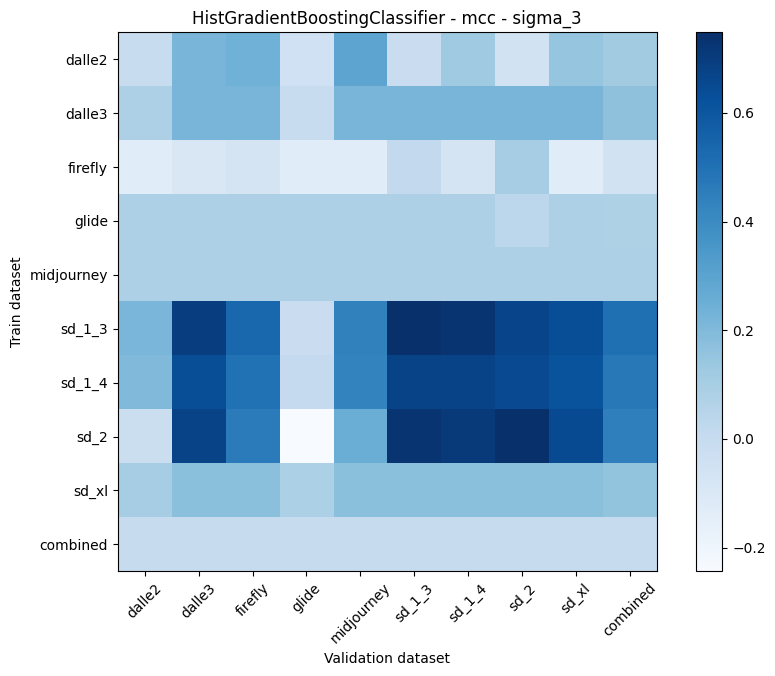

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.007289  0.220707  0.239254 -0.045531    0.293021 -0.016541   
dalle3         0.079211  0.217945  0.217945 -0.004967    0.217945  0.217945   
firefly       -0.128373 -0.094764 -0.066907 -0.128373   -0.128373  0.013617   
glide          0.080806  0.080806  0.080806  0.080806    0.080806  0.080806   
midjourney     0.080806  0.080806  0.080806  0.080806    0.080806  0.080806   
sd_1_3         0.216045  0.691402  0.538651 -0.018484    0.437468  0.744936   
sd_1_4         0.201409  0.632184  0.496713  0.004972    0.428049  0.673476   
sd_2          -0.025023  0.671792  0.459734 -0.243464    0.255565  0.726810   
sd_xl          0.102412  0.173335  0.173335  0.083019    0.173335  0.173335   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.120994 -0.055652  0.148968  0.112998  
dalle3         0.217945  0.217945  0.217945  0.165876  
firefly       -0.066907  0.103946 -0.128373 -0.050630  
glide          0.080806  0.034257  0.080806  0.074455  
midjourney     0.080806  0.080806  0.080806  0.080806  
sd_1_3         0.729337  0.669308  0.633480  0.504230  
sd_1_4         0.673476  0.648473  0.616179  0.470327  
sd_2           0.712801  0.748173  0.645222  0.444030  
sd_xl          0.173335  0.173335  0.173335  0.152646  
combined       0.000000  0.000000  0.000000  0.000000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.007289  0.220707  0.239254 -0.045531    0.293021 -0.016541   
dalle3         0.079211  0.217945  0.217945 -0.004967    0.217945  0.217945   
firefly       -0.128373 -0.094764 -0.066907 -0.128373   -0.128373  0.013617   
glide          0.080806  0.080806  0.080806  0.080806    0.080806  0.080806   
midjourney     0.080806  0.080806  0.080806  0.080806    0.080806  0.080806   
sd_1_3         0.216045  0.691402  0.538651 -0.018484    0.437468  0.744936   
sd_1_4         0.201409  0.632184  0.496713  0.004972    0.428049  0.673476   
sd_2          -0.025023  0.671792  0.459734 -0.243464    0.255565  0.726810   
sd_xl          0.102412  0.173335  0.173335  0.083019    0.173335  0.173335   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.120994 -0.055652  0.148968  0.099770  
dalle3         0.217945  0.217945  0.217945  0.177762  
firefly       -0.066907  0.103946 -0.128373 -0.069390  
glide          0.080806  0.034257  0.080806  0.075634  
midjourney     0.080806  0.080806  0.080806  0.080806  
sd_1_3         0.729337  0.669308  0.633480  0.515794  
sd_1_4         0.673476  0.648473  0.616179  0.486103  
sd_2           0.712801  0.748173  0.645222  0.439068  
sd_xl          0.173335  0.173335  0.173335  0.155419  
combined       0.000000  0.000000  0.000000  0.000000

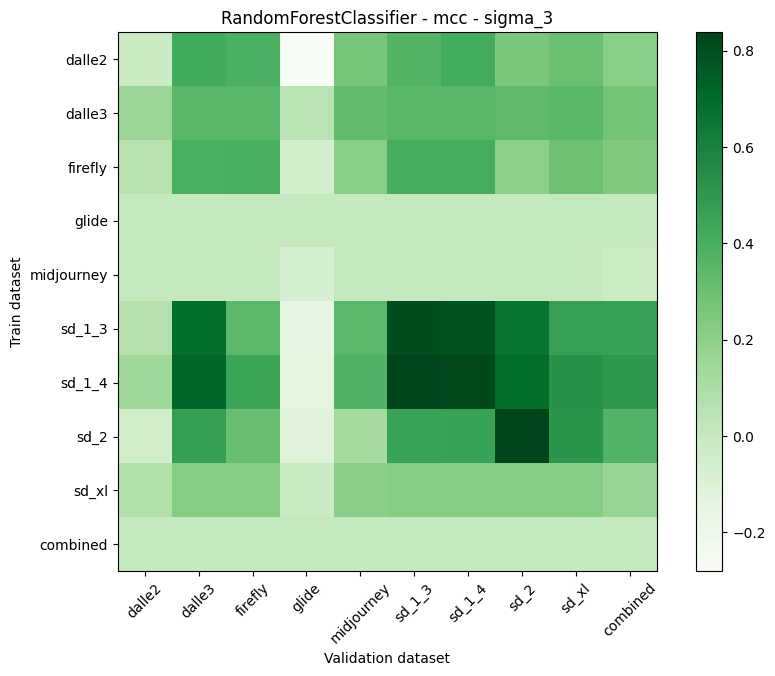

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.022672  0.418197  0.390067 -0.280683    0.263546  0.363012   
dalle3         0.153331  0.351318  0.351318  0.048587    0.323208  0.351318   
firefly        0.059703  0.384443  0.394440 -0.049632    0.210090  0.404597   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.000000  0.000000  0.000000 -0.077832    0.000000  0.000000   
sd_1_3         0.062148  0.689101  0.347190 -0.151878    0.347190  0.800746   
sd_1_4         0.143068  0.718679  0.444730 -0.136758    0.377591  0.838065   
sd_2          -0.046249  0.469669  0.311304 -0.114683    0.118771  0.453963   
sd_xl          0.076539  0.225964  0.225964 -0.014586    0.205076  0.225964   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.408693  0.255783  0.303477  0.213031  
dalle3         0.351318  0.337043  0.351318  0.278528  
firefly        0.404597  0.202350  0.291979  0.240910  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.000000  0.000000  0.000000 -0.025872  
sd_1_3         0.787831  0.659630  0.463536  0.461098  
sd_1_4         0.824143  0.693692  0.528919  0.498209  
sd_2           0.459207  0.838146  0.511267  0.373009  
sd_xl          0.225964  0.225964  0.225964  0.167365  
combined       0.000000  0.000000  0.000000  0.000000

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.022672  0.418197  0.390067 -0.280683    0.263546  0.363012   
dalle3         0.153331  0.351318  0.351318  0.048587    0.323208  0.351318   
firefly        0.059703  0.384443  0.394440 -0.049632    0.210090  0.404597   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.000000  0.000000  0.000000 -0.077832    0.000000  0.000000   
sd_1_3         0.062148  0.689101  0.347190 -0.151878    0.347190  0.800746   
sd_1_4         0.143068  0.718679  0.444730 -0.136758    0.377591  0.838065   
sd_2          -0.046249  0.469669  0.311304 -0.114683    0.118771  0.453963   
sd_xl          0.076539  0.225964  0.225964 -0.014586    0.205076  0.225964   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.408693  0.255783  0.303477  0.233269  
dalle3         0.351318  0.337043  0.351318  0.290973  
firefly        0.404597  0.202350  0.291979  0.255841  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.000000  0.000000  0.000000 -0.008648  
sd_1_3         0.787831  0.659630  0.463536  0.445055  
sd_1_4         0.824143  0.693692  0.528919  0.492459  
sd_2           0.459207  0.838146  0.511267  0.333488  
sd_xl          0.225964  0.225964  0.225964  0.180313  
combined       0.000000  0.000000  0.000000  0.000000

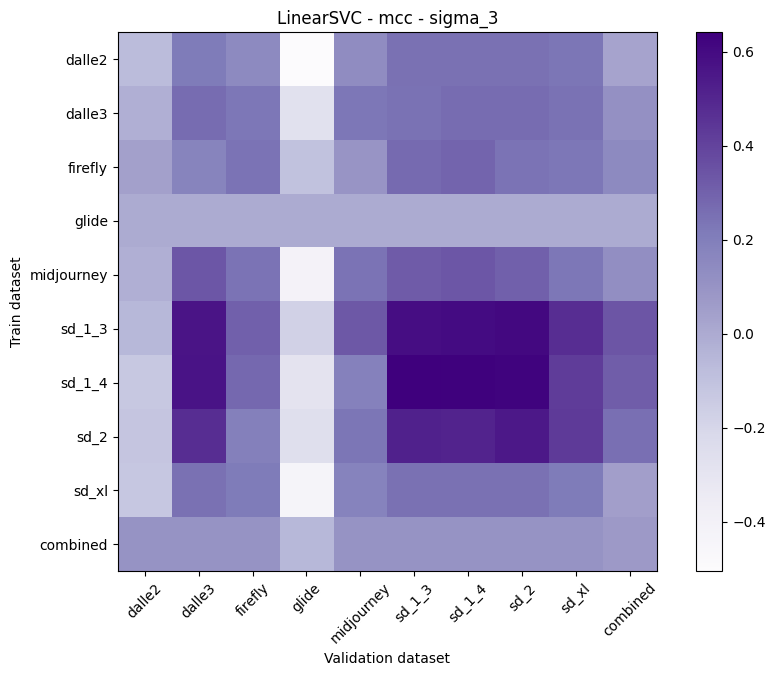

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.073332  0.211438  0.147739 -0.506001    0.133571  0.248758   
dalle3        -0.020104  0.263086  0.227441 -0.271959    0.227441  0.244790   
firefly        0.043792  0.172947  0.241838 -0.101520    0.092974  0.273329   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney    -0.021340  0.333715  0.238768 -0.417238    0.238768  0.318806   
sd_1_3        -0.054059  0.564378  0.302693 -0.176484    0.329656  0.590607   
sd_1_4        -0.133130  0.568619  0.274428 -0.289215    0.188211  0.641399   
sd_2          -0.118151  0.472789  0.189463 -0.256979    0.230365  0.519486   
sd_xl         -0.127298  0.248758  0.211438 -0.435312    0.178031  0.248758   
combined       0.099123  0.099123  0.099123 -0.053525    0.099123  0.099123   

val_dataset      sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.248758  0.248758  0.229547  0.030200  
dalle3         0.263086  0.263086  0.244790  0.115986  
firefly        0.290137  0.241838  0.227033  0.145833  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.333715  0.304400  0.226731  0.123993  
sd_1_3         0.599540  0.608574  0.474532  0.338004  
sd_1_4         0.633016  0.624712  0.423632  0.312172  
sd_2           0.509906  0.549015  0.428806  0.252912  
sd_xl          0.248758  0.248758  0.211438  0.046717  
combined       0.099123  0.099123  0.099123  0.070543

val_dataset      dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.073332  0.211438  0.147739 -0.506001    0.133571  0.248758   
dalle3        -0.020104  0.263086  0.227441 -0.271959    0.227441  0.244790   
firefly        0.043792  0.172947  0.241838 -0.101520    0.092974  0.273329   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney    -0.021340  0.333715  0.238768 -0.417238    0.238768  0.318806   
sd_1_3        -0.054059  0.564378  0.302693 -0.176484    0.329656  0.590607   
sd_1_4        -0.133130  0.568619  0.274428 -0.289215    0.188211  0.641399   
sd_2          -0.118151  0.472789  0.189463 -0.256979    0.230365  0.519486   
sd_xl         -0.127298  0.248758  0.211438 -0.435312    0.178031  0.248758   
combined       0.099123  0.099123  0.099123 -0.053525    0.099123  0.099123   

val_dataset      sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.248758  0.248758  0.229547  0.098804  
dalle3         0.263086  0.263086  0.244790  0.160184  
firefly        0.290137  0.241838  0.227033  0.164708  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.333715  0.304400  0.226731  0.172925  
sd_1_3         0.599540  0.608574  0.474532  0.359938  
sd_1_4         0.633016  0.624712  0.423632  0.325741  
sd_2           0.509906  0.549015  0.428806  0.280522  
sd_xl          0.248758  0.248758  0.211438  0.114814  
combined       0.099123  0.099123  0.099123  0.082162

In [13]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "mcc"
    evaluation_data_name = "Validation"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

## Test data

In [14]:
perturbed_results = {}   

for perturbed_name, X_test, y_test in zip(perturbed_X_test.keys(), perturbed_X_test.values(), perturbed_y_test.values()):
    results = {}
    X_train = perturbed_X_train[base_perturbed_name]
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    for dataset_name in models.keys():
        print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
        for test_dataset_name in X_test.keys():
            print(f"\n\nValidation set: {test_dataset_name}")
            for model_name, model in models[dataset_name].items():
                print()  
                X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
                X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
                accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
                model_results = {
                    "accuracy": accuracy,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "mcc": mcc
                }
                results[(dataset_name, test_dataset_name, model_name)] = model_results
                
    perturbed_results[perturbed_name] = results









 ################ Evaluating models trained on standard and tested on standard. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: LinearDiscriminantAnalysis
Accuracy: 0.9225
F1: 0.9225
Precision: 0.9225
Recall: 0.9225
MCC: 0.8450

Model: RandomForestClassifier
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9878
Recall: 0.9875
MCC: 0.9753

Model: LinearSVC
Accuracy: 0.9925
F1: 0.9925
Precision: 0.9926
Recall: 0.9925
MCC: 0.9851


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7600
F1: 0.7466
Precision: 0.8298
Recall: 0.7600
MCC: 0.5856

Model: LinearDiscriminantAnalysis
Accuracy: 0.6375
F1: 0.6061
Precision: 0.7020
Recall: 0.6375
MCC: 0.3333

Model: RandomForestClassifier
Accuracy: 0.8000
F1: 0.7937
Precision: 0.8419
Recall: 0.8000
MCC: 0.6405

Model: LinearSVC
Accuracy: 0.8500
F1: 0.8472
Precision:

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5175
F1: 0.3750
Precision: 0.6989
Recall: 0.5175
MCC: 0.1180



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearDiscriminantAnalysis
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5300
F1: 0.4003
Precision: 0.7221
Recall: 0.5300
MCC: 0.1632

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5611
F1: 0.4593
Precision: 0.7475
Recall: 0.5611
MCC: 0.2459

Model: LinearDiscriminantAnalysis
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: RandomForestClassifier
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: LinearSVC
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9752
Recall: 0.9750
MCC: 0.9502

Model: LinearDiscriminantAnalysis
Accuracy: 0.7350
F1: 0.7345
Precision: 0.7369
Recall: 0.7350
MCC: 0.4719

Model: RandomForestClassifier
Accuracy: 0.9625
F1: 0.9625
Precision: 0.9639
Recall: 0.9625
MCC: 0.9264

Model: LinearSVC
Accuracy: 0.9400
F1: 0.9399
Precision: 0.9428
R

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.4950
F1: 0.3438
Precision: 0.4362
Recall: 0.4950
MCC: -0.0357

Model: RandomForestClassifier
Accuracy: 0.4925
F1: 0.3300
Precision: 0.2481
Recall: 0.4925
MCC: -0.0869

Model: LinearSVC
Accuracy: 0.4875
F1: 0.3402
Precision: 0.3832
Recall: 0.4875
MCC: -0.0764


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3389
Precision: 0.7506
Recall: 0.5025
MCC: 0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3474
Precision: 0.5506
Recall: 0.5025
MCC: 0.0225

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: Linea

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5019
F1: 0.3386
Precision: 0.6596
Recall: 0.5019
MCC: 0.0352

Model: LinearDiscriminantAnalysis
Accuracy: 0.5011
F1: 0.3467
Precision: 0.5203
Recall: 0.5011
MCC: 0.0095

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4989
F1: 0.3457
Precision: 0.4825
Recall: 0.4989
MCC: -0.0088




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5450
F1: 0.5048
Precision: 0.5667
Recall: 0.5450
MCC: 0.1095

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5150
F1: 0.3812
Precision: 0.6110
Recall: 0.5150
MCC: 0.0816


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5950
F1: 0.5438
Precision: 0.6724
Recall: 0.5950
MCC: 0.2559

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3866
Precision: 0.7564
Recall: 0.5250
MCC: 0.1601


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.6025
F1: 0.5497
Precision: 0.6931
Recall: 0.6025
MCC: 0.2814



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3866
Precision: 0.7564
Recall: 0.5250
MCC: 0.1601


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.4775
F1: 0.4516
Precision: 0.4722
Recall: 0.4775
MCC: -0.0500

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.3250
F1: 0.2698
Precision: 0.2491
Recall: 0.3250
MCC: -0.4191


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5300
F1: 0.4930
Precision: 0.5423
Recall: 0.5300
MCC: 0.0713



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5225
F1: 0.3853
Precision: 0.7103
Recall: 0.5225
MCC: 0.1376


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5975
F1: 0.5458
Precision: 0.6791
Recall: 0.5975
MCC: 0.2643



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3866
Precision: 0.7564
Recall: 0.5250
MCC: 0.1601


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5925
F1: 0.5418
Precision: 0.6658
Recall: 0.5925
MCC: 0.2477



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5225
F1: 0.3853
Precision: 0.7103
Recall: 0.5225
MCC: 0.1376


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5275
F1: 0.4911
Precision: 0.5385
Recall: 0.5275
MCC: 0.0651



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5250
F1: 0.3866
Precision: 0.7564
Recall: 0.5250
MCC: 0.1601


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5675
F1: 0.5223
Precision: 0.6086
Recall: 0.5675
MCC: 0.1712



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5225
F1: 0.3853
Precision: 0.7103
Recall: 0.5225
MCC: 0.1376


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.4997
F1: 0.3332
Precision: 0.2499
Recall: 0.4997
MCC: -0.0167

Model: LinearDiscriminantAnalysis
Accuracy: 0.5594
F1: 0.5161
Precision: 0.5927
Recall: 0.5594
MCC: 0.1485

Model: RandomForestClassifier
Accuracy: 0.4997
F1: 0.3332
Precision: 0.2499
Recall: 0.4997
MCC: -0.0167

Model: LinearSVC
Accuracy: 0.5008
F1: 0.3735
Precision: 0.5045
Recall: 0.5008
MCC: 0.0039




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.6025
F1: 0.6019
Precision: 0.6031
Recall: 0.6025
MCC: 0.2056

Model: LinearDiscriminantAnalysis
Accuracy: 0.4800
F1: 0.3949
Precision: 0.4543
Recall: 0.4800
MCC: -0.0605

Model: RandomForestClassifier
Accuracy: 0.5250
F1: 0.4780
Precisi

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3543
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3593
Precision: 0.6692
Recall: 0.5100
MCC: 0.0823



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3556
Precision: 0.5284
Recall: 0.5025
MCC: 0.0169



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3593
Precision: 0.6692
Recall: 0.5100
MCC: 0.0823



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4600
F1: 0.3340
Precision: 0.3355
Recall: 0.4600
MCC: -0.1623

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5036
F1: 0.3561
Precision: 0.5431
Recall: 0.5036
MCC: 0.0250



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4997
F1: 0.3332
Precision: 0.2499
Recall: 0.4997
MCC: -0.0167








 ################ Evaluating models trained on standard and tested on sigma_2. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.4650
F1: 0.3631
Precision: 0.4028
Recall: 0.4650
MCC: -0.1167

Model: LinearDiscriminantAnalysis
Accuracy: 0.4900
F1: 0.3869
Precision: 0.4695
Recall: 0.4900
MCC: -0.0349

Model: RandomForestClassifier
Accuracy: 0.4950
F1: 0.4950
Precision: 0.4950
Recall: 0.4950
MCC: -0.0100

Model: LinearSVC
Accuracy: 0.5025
F1: 0.4728
Precision: 0.5032
Recall: 0.5025
MCC: 0.0057


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5525
F1: 0.5041
Precision: 0.5862
Recall: 0.5525
MCC: 0.1345

Model: LinearDiscriminantAnalysis
Accuracy: 0.4950
F1: 0.3959
Precisio

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.4950
F1: 0.3397
Precision: 0.4154
Recall: 0.4950
MCC: -0.0411

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3420
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4997
F1: 0.3332
Precision: 0.2499
Recall: 0.4997
MCC: -0.0167

Model: LinearDiscriminantAnalysis
Accuracy: 0.5033
F1: 0.3436
Precision: 0.6258
Recall: 0.5033
MCC: 0.0410



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5450
F1: 0.4966
Precision: 0.5731
Recall: 0.5450
MCC: 0.1147

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.5325
F1: 0.4744
Precision: 0.5583
Recall: 0.5325
MCC: 0.0870


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5575
F1: 0.5061
Precision: 0.5985
Recall: 0.5575
MCC: 0.1505

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5975
F1: 0.5220
Precision: 0.7650
Re

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5400
F1: 0.4928
Precision: 0.5637
Recall: 0.5400
MCC: 0.1010



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5900
F1: 0.5165
Precision: 0.7298
Recall: 0.5900
MCC: 0.2876


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.4675
F1: 0.4371
Precision: 0.4585
Recall: 0.4675
MCC: -0.0734

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.3350
F1: 0.3227
Precision: 0.3220
Recall: 0.3350
MCC: -0.3427


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.4622
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5725
F1: 0.5036
Precision: 0.6629
Recall: 0.5725
MCC: 0.2174


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5475
F1: 0.4985
Precision: 0.5779
Recall: 0.5475
MCC: 0.1217



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5925
F1: 0.5183
Precision: 0.7410
Recall: 0.5925
MCC: 0.2986


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5250
F1: 0.4814
Precision: 0.5377
Recall: 0.5250
MCC: 0.0614



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5975
F1: 0.5220
Precision: 0.7650
Recall: 0.5975
MCC: 0.3215


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.4622
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6000
F1: 0.5238
Precision: 0.7778
Recall: 0.6000
MCC: 0.3333


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.4757
Precision: 0.5257
Recall: 0.5175
MCC: 0.0424



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5925
F1: 0.5183
Precision: 0.7410
Recall: 0.5925
MCC: 0.2986


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5222
F1: 0.4793
Precision: 0.5332
Recall: 0.5222
MCC: 0.0543

Model: RandomForestClassifier
Accuracy: 0.4994
F1: 0.3331
Precision: 0.2499
Recall: 0.4994
MCC: -0.0236

Model: LinearSVC
Accuracy: 0.5567
F1: 0.4920
Precision: 0.6154
Recall: 0.5567
MCC: 0.1617




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5625
F1: 0.5615
Precision: 0.5631
Recall: 0.5625
MCC: 0.1256

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.4539
Precision: 0.5219
Recall: 0.5125
MCC: 0.0331

Model: RandomForestClassifier
Accuracy: 0.5350
F1: 0.4762
Precision

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3528
Precision: 0.5846
Recall: 0.5050
MCC: 0.0411

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3552
Precision: 0.7525
Recall: 0.5100
MCC: 0.1005

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4725
F1: 0.3367
Precision: 0.3480
Recall: 0.4725
MCC: -0.1293



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3552
Precision: 0.7525
Recall: 0.5100
MCC: 0.1005

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3552
Precision: 0.7525
Recall: 0.5100
MCC: 0.1005



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.3491
Precision: 0.4716
Recall: 0.4975
MCC: -0.0169



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3552
Precision: 0.7525
Recall: 0.5100
MCC: 0.1005



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5033
F1: 0.3519
Precision: 0.5508
Recall: 0.5033
MCC: 0.0260



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4994
F1: 0.3331
Precision: 0.2499
Recall: 0.4994
MCC: -0.0236








 ################ Evaluating models trained on standard and tested on sigma_3. ################




 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.4950
F1: 0.4149
Precision: 0.4889
Recall: 0.4950
MCC: -0.0149

Model: LinearDiscriminantAnalysis
Accuracy: 0.4925
F1: 0.3757
Precision: 0.4702
Recall: 0.4925
MCC: -0.0299

Model: RandomForestClassifier
Accuracy: 0.5500
F1: 0.5481
Precision: 0.5509
Recall: 0.5500
MCC: 0.1009

Model: LinearSVC
Accuracy: 0.4600
F1: 0.3894
Precision: 0.4256
Recall: 0.4600
MCC: -0.1091


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5725
F1: 0.5325
Precision: 0.6102
Recall: 0.5725
MCC: 0.1788

Model: LinearDiscriminantAnalysis
Accuracy: 0.5200
F1: 0.4258
Precisio

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3646
Precision: 0.6818
Recall: 0.5125
MCC: 0.0953



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3658
Precision: 0.7538
Recall: 0.5150
MCC: 0.1234



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3658
Precision: 0.7538
Recall: 0.5150
MCC: 0.1234



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3646
Precision: 0.6818
Recall: 0.5125
MCC: 0.0953



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3658
Precision: 0.7538
Recall: 0.5150
MCC: 0.1234

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3646
Precision: 0.6818
Recall: 0.5125
MCC: 0.0953

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3658
Precision: 0.7538
Recall: 0.5150
MCC: 0.1234



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.3646
Precision: 0.6818
Recall: 0.5125
MCC: 0.0953



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3658
Precision: 0.7538
Recall: 0.5150
MCC: 0.1234



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.4992
F1: 0.3330
Precision: 0.2498
Recall: 0.4992
MCC: -0.0289

Model: LinearDiscriminantAnalysis
Accuracy: 0.5139
F1: 0.3653
Precision: 0.7190
Recall: 0.5139
MCC: 0.1103

Model: RandomForestClassifier
Accuracy: 0.4997
F1: 0.3332
Precision: 0.2499
Recall: 0.4997
MCC: -0.0167

Model: LinearSVC
Accuracy: 0.4997
F1: 0.3332
Precision: 0.2499
Recall: 0.4997
MCC: -0.0167




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5475
F1: 0.5112
Precision: 0.5676
Recall: 0.5475
MCC: 0.1133

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.5275
F1: 0.4799
Precision: 0.54

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.6125
F1: 0.5440
Precision: 0.7817
Recall: 0.6125
MCC: 0.3560


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5600
F1: 0.5211
Precision: 0.5889
Recall: 0.5600
MCC: 0.1460



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5875
F1: 0.5251
Precision: 0.6845
Recall: 0.5875
MCC: 0.2541


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.4733
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.3525
F1: 0.3418
Precision: 0.3422
Recall: 0.3525
MCC: -0.3051


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.4854
Precision: 0.5195
Recall: 0.5150
MCC: 0.0342



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5850
F1: 0.5232
Precision: 0.6765
Recall: 0.5850
MCC: 0.2450


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.4733
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6125
F1: 0.5440
Precision: 0.7817
Recall: 0.6125
MCC: 0.3560


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5125
F1: 0.4834
Precision: 0.5161
Recall: 0.5125
MCC: 0.0284

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6100
F1: 0.5421
Precision: 0.7702
Recall: 0.6100
MCC: 0.3448


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.4550
F1: 0.4368
Precision: 0.4483
Recall: 0.4550
MCC: -0.0965

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6075
F1: 0.5402
Precision: 0.7592
Recall: 0.6075
MCC: 0.3338


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.4975
F1: 0.4713
Precision: 0.4969
Recall: 0.4975
MCC: -0.0056

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.6050
F1: 0.5383
Precision: 0.7486
Recall: 0.6050
MCC: 0.3231


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5147
F1: 0.4851
Precision: 0.5191
Recall: 0.5147
MCC: 0.0336

Model: RandomForestClassifier
Accuracy: 0.4994
F1: 0.3331
Precision: 0.2499
Recall: 0.4994
MCC: -0.0236

Model: LinearSVC
Accuracy: 0.5667
F1: 0.5094
Precision: 0.6251
Recall: 0.5667
MCC: 0.1826




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.5450
F1: 0.5409
Precision: 0.5467
Recall: 0.5450
MCC: 0.0917

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.4798
Precision: 0.5206
Recall: 0.5150
MCC: 0.0351

Model: RandomForestClassifier
Accuracy: 0.5250
F1: 0.4565
Precision: 0.5504
Recall: 0.5250
MCC: 0.0710

Model: LinearSVC
Accuracy: 0.5150
F1: 0.5115
Precision: 0.5154
Reca

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290


Validation set: dalle3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3711
Precision: 0.7545
Recall: 0.5175
MCC: 0.1335



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: firefly



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3711
Precision: 0.7545
Recall: 0.5175
MCC: 0.1335



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.4800
F1: 0.3516
Precision: 0.4038
Recall: 0.4800
MCC: -0.0877

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290


Validation set: sd_1_3



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5150
F1: 0.3698
Precision: 0.6913
Recall: 0.5150
MCC: 0.1071



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: sd_1_4



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3711
Precision: 0.7545
Recall: 0.5175
MCC: 0.1335



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: sd_2



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5075
F1: 0.3659
Precision: 0.5701
Recall: 0.5075
MCC: 0.0459



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5175
F1: 0.3711
Precision: 0.7545
Recall: 0.5175
MCC: 0.1335



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5114
F1: 0.3679
Precision: 0.6235
Recall: 0.5114
MCC: 0.0750



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5042
F1: 0.3440
Precision: 0.6796
Recall: 0.5042
MCC: 0.0547


### Accuracy - Test

########################### Accuracy ###########################








 ################ Evaluating models trained on standard and tested on standard. ################


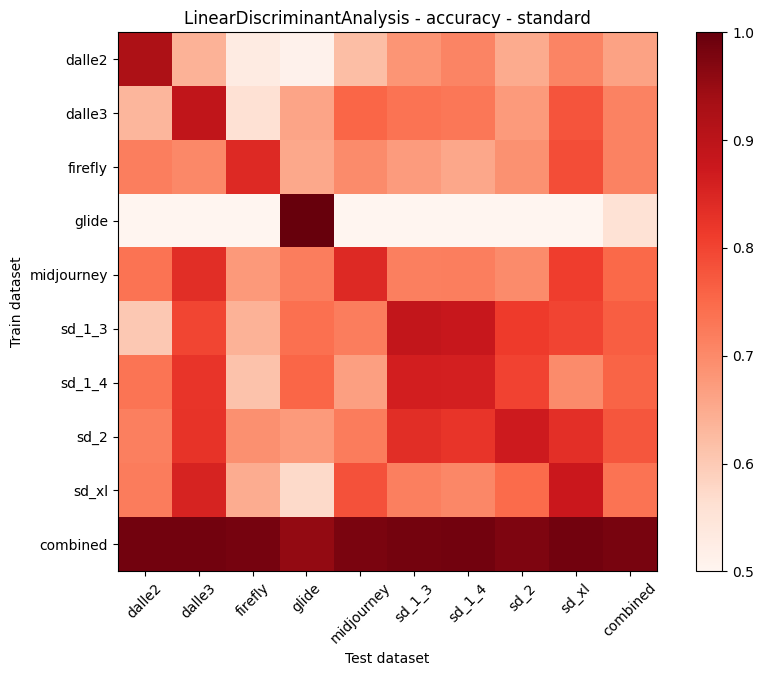

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9225  0.6375   0.5275  0.5100      0.6200  0.6825  0.7075   
dalle3         0.6325  0.8925   0.5575  0.6600      0.7550  0.7350  0.7300   
firefly        0.7175  0.7025   0.8425  0.6525      0.6975  0.6725  0.6550   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.7350  0.8350   0.6775  0.7200      0.8425  0.7150  0.7175   
sd_1_3         0.6025  0.7975   0.6375  0.7400      0.7200  0.8875  0.8800   
sd_1_4         0.7325  0.8225   0.6125  0.7550      0.6675  0.8625  0.8600   
sd_2           0.7150  0.8250   0.6900  0.6750      0.7225  0.8350  0.8225   
sd_xl          0.7225  0.8550   0.6475  0.5725      0.7825  0.7150  0.7050   
combined       0.9875  0.9875   0.9825  0.9550      0.9800  0.9850  0.9875   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6500  0.7075  0.662778  
dalle3         0.6750  0.7775  0.712778  
firefly        0.6875  0.7875  0.712778  
glide          0.5000  0.5000  0.555556  
midjourney     0.6975  0.8100  0.750000  
sd_1_3         0.8125  0.8000  0.764167  
sd_1_4         0.8025  0.6975  0.756944  
sd_2           0.8700  0.8325  0.776389  
sd_xl          0.7475  0.8750  0.735833  
combined       0.9750  0.9875  0.980833

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9225  0.6375   0.5275  0.5100      0.6200  0.6825  0.7075   
dalle3         0.6325  0.8925   0.5575  0.6600      0.7550  0.7350  0.7300   
firefly        0.7175  0.7025   0.8425  0.6525      0.6975  0.6725  0.6550   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.7350  0.8350   0.6775  0.7200      0.8425  0.7150  0.7175   
sd_1_3         0.6025  0.7975   0.6375  0.7400      0.7200  0.8875  0.8800   
sd_1_4         0.7325  0.8225   0.6125  0.7550      0.6675  0.8625  0.8600   
sd_2           0.7150  0.8250   0.6900  0.6750      0.7225  0.8350  0.8225   
sd_xl          0.7225  0.8550   0.6475  0.5725      0.7825  0.7150  0.7050   
combined       0.9875  0.9875   0.9825  0.9550      0.9800  0.9850  0.9875   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6500  0.7075  0.662778  
dalle3         0.6750  0.7775  0.712778  
firefly        0.6875  0.7875  0.712778  
glide          0.5000  0.5000  0.555556  
midjourney     0.6975  0.8100  0.750000  
sd_1_3         0.8125  0.8000  0.764167  
sd_1_4         0.8025  0.6975  0.756944  
sd_2           0.8700  0.8325  0.776389  
sd_xl          0.7475  0.8750  0.735833  
combined       0.9750  0.9875  0.980833

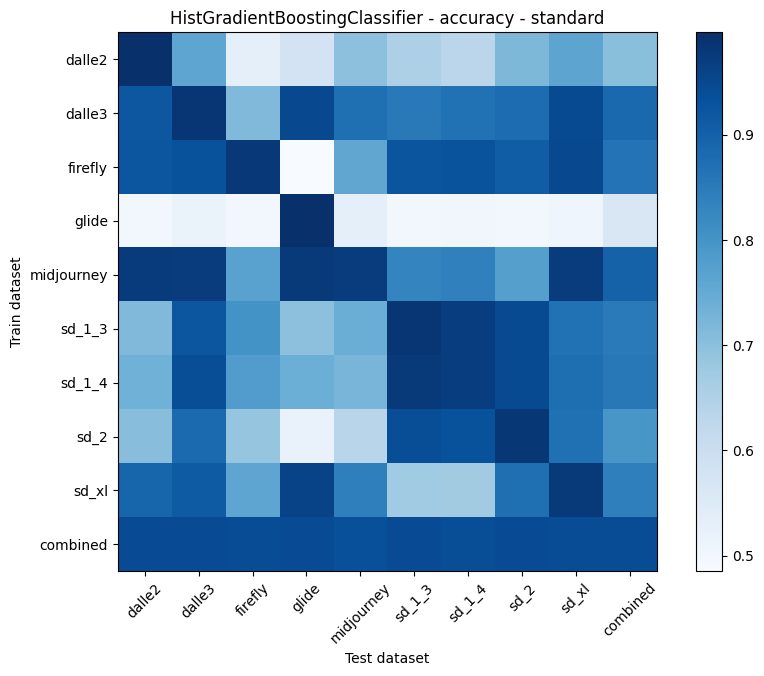

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9950  0.7600   0.5300  0.5775      0.6975  0.6525  0.6300   
dalle3         0.9200  0.9850   0.7150  0.9475      0.8725  0.8525  0.8675   
firefly        0.9225  0.9300   0.9800  0.4850      0.7575  0.9250  0.9275   
glide          0.5000  0.5175   0.5000  0.9975      0.5300  0.4975  0.5025   
midjourney     0.9750  0.9725   0.7675  0.9775      0.9725  0.8300  0.8375   
sd_1_3         0.7150  0.9225   0.8025  0.6975      0.7425  0.9850  0.9675   
sd_1_4         0.7350  0.9375   0.7800  0.7400      0.7250  0.9775  0.9675   
sd_2           0.7050  0.8825   0.6875  0.5200      0.6350  0.9375  0.9300   
sd_xl          0.8925  0.9125   0.7600  0.9575      0.8400  0.6725  0.6700   
combined       0.9425  0.9425   0.9400  0.9425      0.9350  0.9425  0.9375   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7175  0.7625  0.702500  
dalle3         0.8775  0.9450  0.886944  
firefly        0.9075  0.9475  0.864722  
glide          0.4975  0.5075  0.561111  
midjourney     0.7750  0.9725  0.897778  
sd_1_3         0.9450  0.8675  0.849444  
sd_1_4         0.9450  0.8750  0.853611  
sd_2           0.9825  0.8700  0.794444  
sd_xl          0.8725  0.9775  0.839444  
combined       0.9425  0.9400  0.940556

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9950  0.7600   0.5300  0.5775      0.6975  0.6525  0.6300   
dalle3         0.9200  0.9850   0.7150  0.9475      0.8725  0.8525  0.8675   
firefly        0.9225  0.9300   0.9800  0.4850      0.7575  0.9250  0.9275   
glide          0.5000  0.5175   0.5000  0.9975      0.5300  0.4975  0.5025   
midjourney     0.9750  0.9725   0.7675  0.9775      0.9725  0.8300  0.8375   
sd_1_3         0.7150  0.9225   0.8025  0.6975      0.7425  0.9850  0.9675   
sd_1_4         0.7350  0.9375   0.7800  0.7400      0.7250  0.9775  0.9675   
sd_2           0.7050  0.8825   0.6875  0.5200      0.6350  0.9375  0.9300   
sd_xl          0.8925  0.9125   0.7600  0.9575      0.8400  0.6725  0.6700   
combined       0.9425  0.9425   0.9400  0.9425      0.9350  0.9425  0.9375   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7175  0.7625  0.702500  
dalle3         0.8775  0.9450  0.886944  
firefly        0.9075  0.9475  0.864722  
glide          0.4975  0.5075  0.561111  
midjourney     0.7750  0.9725  0.897778  
sd_1_3         0.9450  0.8675  0.849444  
sd_1_4         0.9450  0.8750  0.853611  
sd_2           0.9825  0.8700  0.794444  
sd_xl          0.8725  0.9775  0.839444  
combined       0.9425  0.9400  0.940556

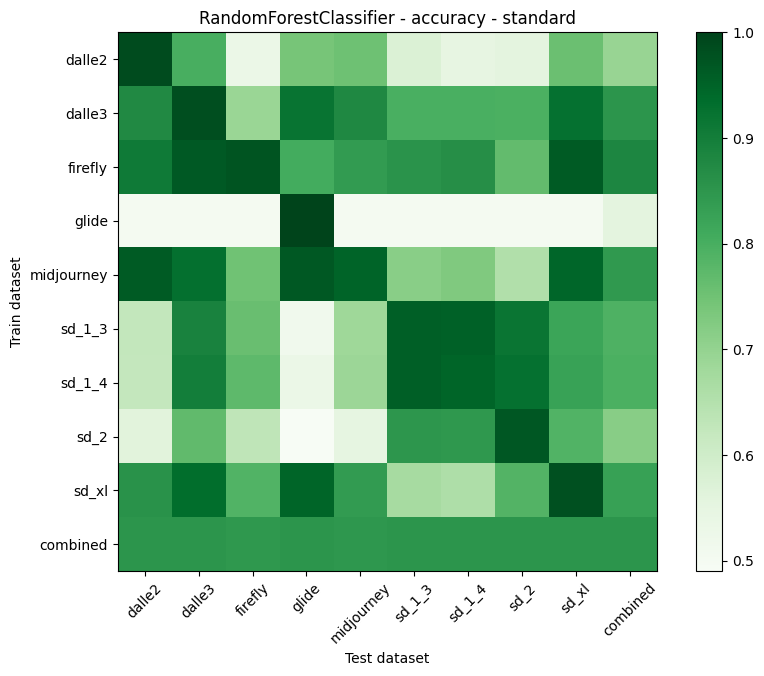

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.8000   0.5300  0.7400      0.7525  0.5750  0.5475   
dalle3         0.8750  0.9825   0.6900  0.9200      0.8775  0.7975  0.7975   
firefly        0.9075  0.9650   0.9725  0.8050      0.8400  0.8550  0.8650   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9625  0.9275   0.7500  0.9675      0.9500  0.7150  0.7275   
sd_1_3         0.6250  0.8900   0.7575  0.5125      0.6850  0.9575  0.9525   
sd_1_4         0.6225  0.9000   0.7725  0.5325      0.6875  0.9575  0.9475   
sd_2           0.5600  0.7675   0.6300  0.4900      0.5500  0.8500  0.8450   
sd_xl          0.8575  0.9325   0.7875  0.9475      0.8400  0.6700  0.6575   
combined       0.8525  0.8525   0.8450  0.8525      0.8475  0.8525  0.8525   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5550  0.7550  0.693611  
dalle3         0.7950  0.9250  0.851111  
firefly        0.7650  0.9625  0.881944  
glide          0.5000  0.5000  0.555556  
midjourney     0.6550  0.9450  0.844444  
sd_1_3         0.9175  0.8200  0.790833  
sd_1_4         0.9250  0.8250  0.796667  
sd_2           0.9700  0.7875  0.716667  
sd_xl          0.7850  0.9800  0.828611  
combined       0.8525  0.8525  0.851111

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9875  0.8000   0.5300  0.7400      0.7525  0.5750  0.5475   
dalle3         0.8750  0.9825   0.6900  0.9200      0.8775  0.7975  0.7975   
firefly        0.9075  0.9650   0.9725  0.8050      0.8400  0.8550  0.8650   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9625  0.9275   0.7500  0.9675      0.9500  0.7150  0.7275   
sd_1_3         0.6250  0.8900   0.7575  0.5125      0.6850  0.9575  0.9525   
sd_1_4         0.6225  0.9000   0.7725  0.5325      0.6875  0.9575  0.9475   
sd_2           0.5600  0.7675   0.6300  0.4900      0.5500  0.8500  0.8450   
sd_xl          0.8575  0.9325   0.7875  0.9475      0.8400  0.6700  0.6575   
combined       0.8525  0.8525   0.8450  0.8525      0.8475  0.8525  0.8525   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5550  0.7550  0.693611  
dalle3         0.7950  0.9250  0.851111  
firefly        0.7650  0.9625  0.881944  
glide          0.5000  0.5000  0.555556  
midjourney     0.6550  0.9450  0.844444  
sd_1_3         0.9175  0.8200  0.790833  
sd_1_4         0.9250  0.8250  0.796667  
sd_2           0.9700  0.7875  0.716667  
sd_xl          0.7850  0.9800  0.828611  
combined       0.8525  0.8525  0.851111

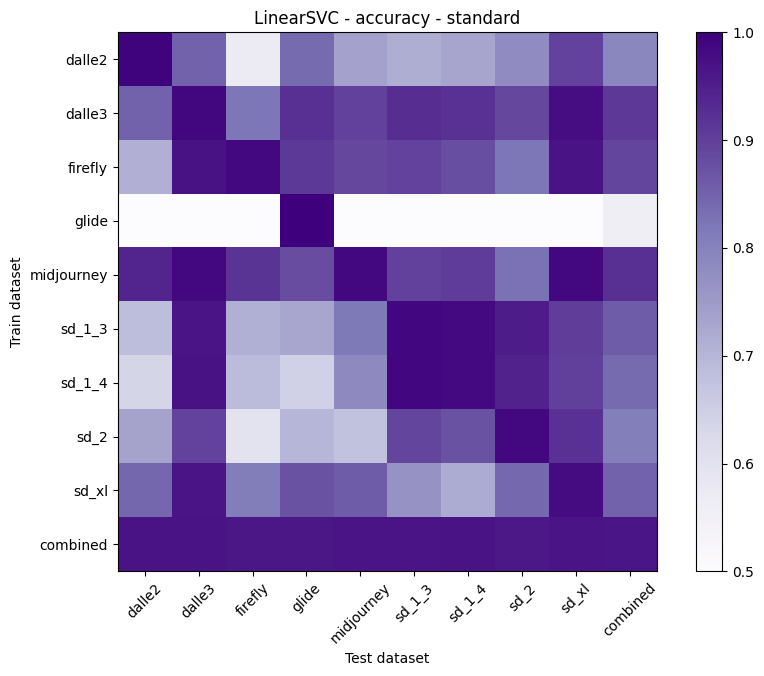

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8500   0.5700  0.8375      0.7375  0.7150  0.7300   
dalle3         0.8500  0.9900   0.8200  0.9225      0.8975  0.9275  0.9200   
firefly        0.7100  0.9725   0.9850  0.9100      0.8875  0.8950  0.8775   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9400  0.9850   0.9175  0.8825      0.9850  0.8975  0.9050   
sd_1_3         0.6850  0.9650   0.7125  0.7275      0.8150  0.9875  0.9825   
sd_1_4         0.6350  0.9700   0.6875  0.6450      0.7825  0.9875  0.9825   
sd_2           0.7350  0.8950   0.5975  0.7000      0.6775  0.8925  0.8725   
sd_xl          0.8425  0.9650   0.8100  0.8725      0.8575  0.7650  0.7200   
combined       0.9675  0.9675   0.9625  0.9625      0.9650  0.9650  0.9675   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7775  0.8950  0.789444  
dalle3         0.8875  0.9775  0.910278  
firefly        0.8200  0.9675  0.891667  
glide          0.5000  0.5000  0.555556  
midjourney     0.8275  0.9850  0.925000  
sd_1_3         0.9550  0.9025  0.859167  
sd_1_4         0.9450  0.9000  0.837222  
sd_2           0.9850  0.9200  0.808333  
sd_xl          0.8400  0.9800  0.850278  
combined       0.9600  0.9650  0.964722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.9925  0.8500   0.5700  0.8375      0.7375  0.7150  0.7300   
dalle3         0.8500  0.9900   0.8200  0.9225      0.8975  0.9275  0.9200   
firefly        0.7100  0.9725   0.9850  0.9100      0.8875  0.8950  0.8775   
glide          0.5000  0.5000   0.5000  1.0000      0.5000  0.5000  0.5000   
midjourney     0.9400  0.9850   0.9175  0.8825      0.9850  0.8975  0.9050   
sd_1_3         0.6850  0.9650   0.7125  0.7275      0.8150  0.9875  0.9825   
sd_1_4         0.6350  0.9700   0.6875  0.6450      0.7825  0.9875  0.9825   
sd_2           0.7350  0.8950   0.5975  0.7000      0.6775  0.8925  0.8725   
sd_xl          0.8425  0.9650   0.8100  0.8725      0.8575  0.7650  0.7200   
combined       0.9675  0.9675   0.9625  0.9625      0.9650  0.9650  0.9675   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7775  0.8950  0.789444  
dalle3         0.8875  0.9775  0.910278  
firefly        0.8200  0.9675  0.891667  
glide          0.5000  0.5000  0.555556  
midjourney     0.8275  0.9850  0.925000  
sd_1_3         0.9550  0.9025  0.859167  
sd_1_4         0.9450  0.9000  0.837222  
sd_2           0.9850  0.9200  0.808333  
sd_xl          0.8400  0.9800  0.850278  
combined       0.9600  0.9650  0.964722









 ################ Evaluating models trained on standard and tested on sigma_1. ################


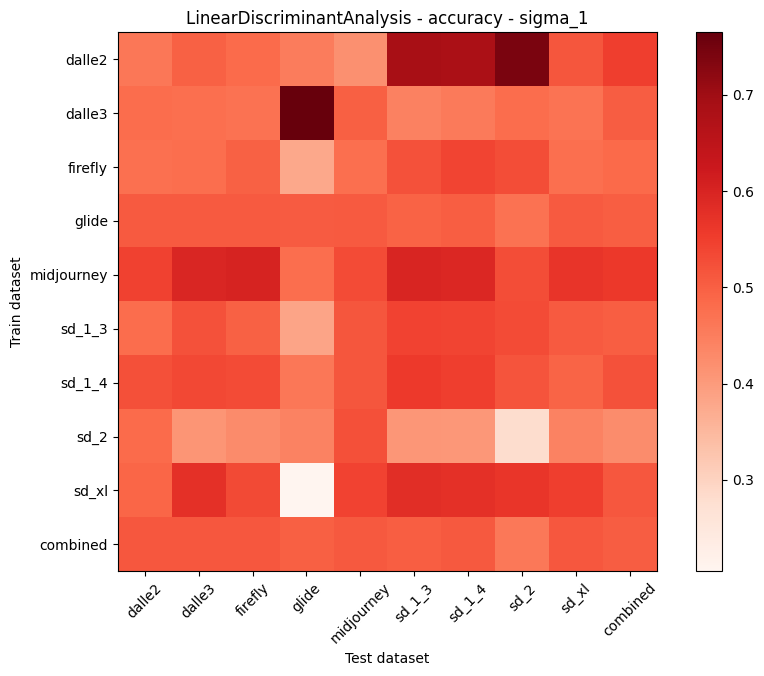

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4625  0.4975   0.4825  0.4525      0.4175  0.6875  0.6825   
dalle3         0.4800  0.4750   0.4700  0.7650      0.5000  0.4450  0.4550   
firefly        0.4725  0.4775   0.4975  0.3775      0.4750  0.5200  0.5400   
glide          0.5075  0.5075   0.5075  0.5050      0.5075  0.4950  0.5025   
midjourney     0.5450  0.5950   0.6025  0.4775      0.5300  0.5975  0.5925   
sd_1_3         0.4800  0.5200   0.4975  0.3825      0.5150  0.5425  0.5400   
sd_1_4         0.5225  0.5350   0.5300  0.4625      0.5150  0.5575  0.5500   
sd_2           0.4825  0.4100   0.4275  0.4425      0.5225  0.4075  0.4050   
sd_xl          0.4900  0.5750   0.5325  0.2050      0.5425  0.5800  0.5750   
combined       0.5125  0.5125   0.5125  0.5000      0.5100  0.5025  0.5100   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.7425  0.5150  0.548889  
dalle3         0.4800  0.4675  0.504167  
firefly        0.5275  0.4750  0.484722  
glide          0.4700  0.5075  0.501111  
midjourney     0.5275  0.5675  0.559444  
sd_1_3         0.5300  0.5075  0.501667  
sd_1_4         0.5175  0.4925  0.520278  
sd_2           0.2800  0.4425  0.424444  
sd_xl          0.5650  0.5500  0.512778  
combined       0.4600  0.5125  0.503611

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4625  0.4975   0.4825  0.4525      0.4175  0.6875  0.6825   
dalle3         0.4800  0.4750   0.4700  0.7650      0.5000  0.4450  0.4550   
firefly        0.4725  0.4775   0.4975  0.3775      0.4750  0.5200  0.5400   
glide          0.5075  0.5075   0.5075  0.5050      0.5075  0.4950  0.5025   
midjourney     0.5450  0.5950   0.6025  0.4775      0.5300  0.5975  0.5925   
sd_1_3         0.4800  0.5200   0.4975  0.3825      0.5150  0.5425  0.5400   
sd_1_4         0.5225  0.5350   0.5300  0.4625      0.5150  0.5575  0.5500   
sd_2           0.4825  0.4100   0.4275  0.4425      0.5225  0.4075  0.4050   
sd_xl          0.4900  0.5750   0.5325  0.2050      0.5425  0.5800  0.5750   
combined       0.5125  0.5125   0.5125  0.5000      0.5100  0.5025  0.5100   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.7425  0.5150  0.548889  
dalle3         0.4800  0.4675  0.504167  
firefly        0.5275  0.4750  0.484722  
glide          0.4700  0.5075  0.501111  
midjourney     0.5275  0.5675  0.559444  
sd_1_3         0.5300  0.5075  0.501667  
sd_1_4         0.5175  0.4925  0.520278  
sd_2           0.2800  0.4425  0.424444  
sd_xl          0.5650  0.5500  0.512778  
combined       0.4600  0.5125  0.503611

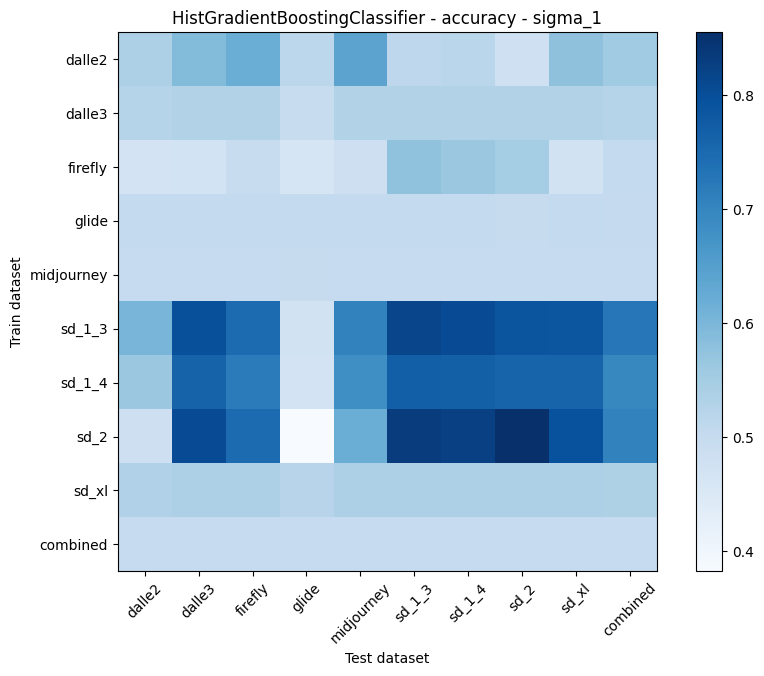

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5375  0.5900   0.6200  0.5150      0.6400  0.5125  0.5175   
dalle3         0.5250  0.5300   0.5300  0.4950      0.5300  0.5300  0.5300   
firefly        0.4675  0.4700   0.4950  0.4625      0.4825  0.5750  0.5625   
glide          0.5025  0.5025   0.5025  0.5025      0.5025  0.5025  0.5025   
midjourney     0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.6025  0.7975   0.7475  0.4725      0.7050  0.8150  0.8050   
sd_1_4         0.5625  0.7625   0.7175  0.4675      0.6825  0.7700  0.7675   
sd_2           0.4825  0.8050   0.7475  0.3825      0.6200  0.8325  0.8250   
sd_xl          0.5325  0.5375   0.5375  0.5225      0.5375  0.5375  0.5375   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.4800  0.5775  0.554444  
dalle3         0.5300  0.5300  0.525556  
firefly        0.5500  0.4725  0.504167  
glide          0.4975  0.5025  0.501944  
midjourney     0.5000  0.5000  0.499722  
sd_1_3         0.7875  0.7850  0.724167  
sd_1_4         0.7600  0.7600  0.694444  
sd_2           0.8550  0.7950  0.705000  
sd_xl          0.5375  0.5375  0.535278  
combined       0.5000  0.5000  0.500000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5375  0.5900   0.6200  0.5150      0.6400  0.5125  0.5175   
dalle3         0.5250  0.5300   0.5300  0.4950      0.5300  0.5300  0.5300   
firefly        0.4675  0.4700   0.4950  0.4625      0.4825  0.5750  0.5625   
glide          0.5025  0.5025   0.5025  0.5025      0.5025  0.5025  0.5025   
midjourney     0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.6025  0.7975   0.7475  0.4725      0.7050  0.8150  0.8050   
sd_1_4         0.5625  0.7625   0.7175  0.4675      0.6825  0.7700  0.7675   
sd_2           0.4825  0.8050   0.7475  0.3825      0.6200  0.8325  0.8250   
sd_xl          0.5325  0.5375   0.5375  0.5225      0.5375  0.5375  0.5375   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.4800  0.5775  0.554444  
dalle3         0.5300  0.5300  0.525556  
firefly        0.5500  0.4725  0.504167  
glide          0.4975  0.5025  0.501944  
midjourney     0.5000  0.5000  0.499722  
sd_1_3         0.7875  0.7850  0.724167  
sd_1_4         0.7600  0.7600  0.694444  
sd_2           0.8550  0.7950  0.705000  
sd_xl          0.5375  0.5375  0.535278  
combined       0.5000  0.5000  0.500000

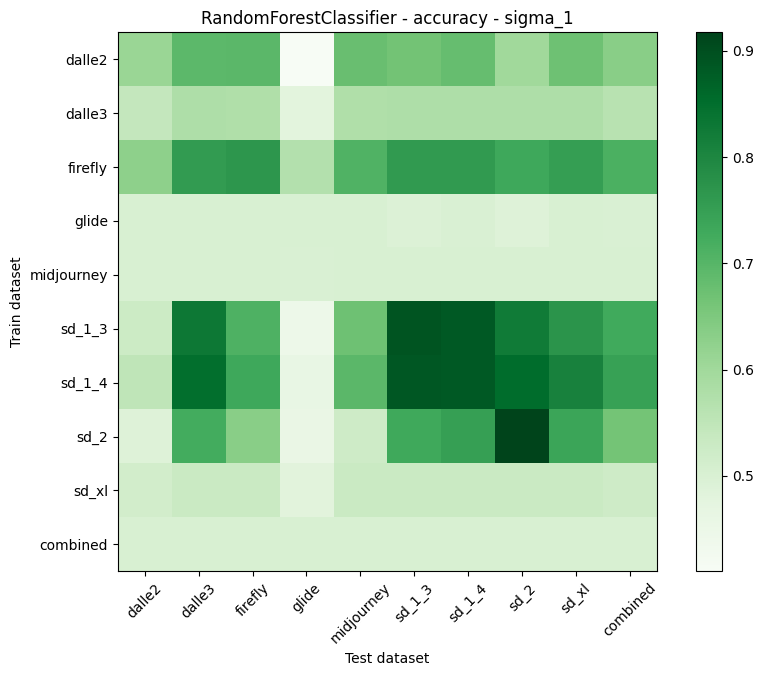

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6100  0.6925   0.6950  0.4100      0.6775  0.6650  0.6800   
dalle3         0.5425  0.5775   0.5750  0.4775      0.5750  0.5775  0.5775   
firefly        0.6275  0.7575   0.7675  0.5700      0.7075  0.7600  0.7600   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.4925  0.4975   
midjourney     0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.5250  0.8300   0.7100  0.4450      0.6700  0.8900  0.8825   
sd_1_4         0.5500  0.8500   0.7325  0.4600      0.6950  0.8875  0.8825   
sd_2           0.4875  0.7250   0.6325  0.4575      0.5225  0.7300  0.7500   
sd_xl          0.5150  0.5300   0.5300  0.4800      0.5300  0.5300  0.5300   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6000  0.6700  0.633333  
dalle3         0.5775  0.5775  0.561944  
firefly        0.7325  0.7525  0.715000  
glide          0.4875  0.5000  0.497500  
midjourney     0.5000  0.5000  0.499722  
sd_1_3         0.8225  0.7725  0.727500  
sd_1_4         0.8525  0.8100  0.746667  
sd_2           0.9175  0.7375  0.662222  
sd_xl          0.5300  0.5300  0.522778  
combined       0.5000  0.5000  0.500000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.6100  0.6925   0.6950  0.4100      0.6775  0.6650  0.6800   
dalle3         0.5425  0.5775   0.5750  0.4775      0.5750  0.5775  0.5775   
firefly        0.6275  0.7575   0.7675  0.5700      0.7075  0.7600  0.7600   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.4925  0.4975   
midjourney     0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.5250  0.8300   0.7100  0.4450      0.6700  0.8900  0.8825   
sd_1_4         0.5500  0.8500   0.7325  0.4600      0.6950  0.8875  0.8825   
sd_2           0.4875  0.7250   0.6325  0.4575      0.5225  0.7300  0.7500   
sd_xl          0.5150  0.5300   0.5300  0.4800      0.5300  0.5300  0.5300   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6000  0.6700  0.633333  
dalle3         0.5775  0.5775  0.561944  
firefly        0.7325  0.7525  0.715000  
glide          0.4875  0.5000  0.497500  
midjourney     0.5000  0.5000  0.499722  
sd_1_3         0.8225  0.7725  0.727500  
sd_1_4         0.8525  0.8100  0.746667  
sd_2           0.9175  0.7375  0.662222  
sd_xl          0.5300  0.5300  0.522778  
combined       0.5000  0.5000  0.500000

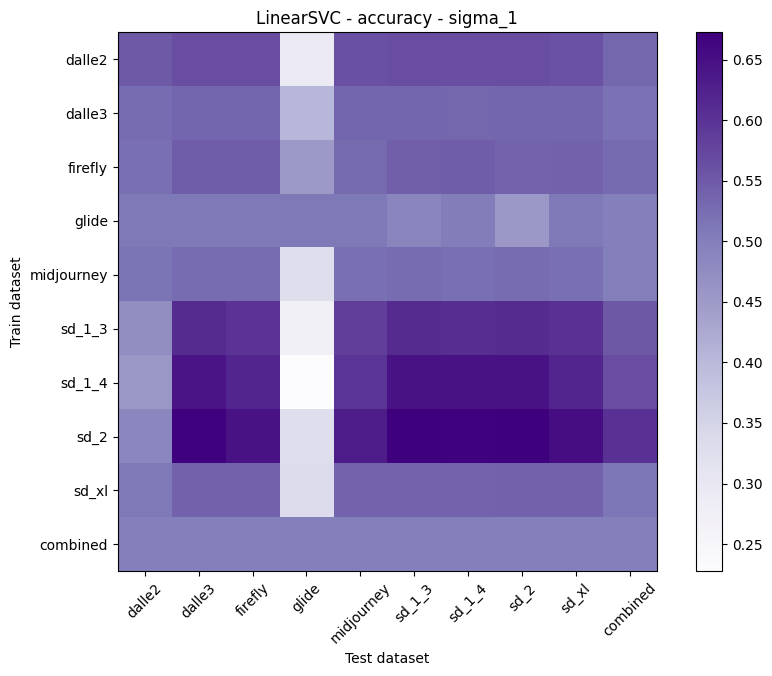

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5500  0.5650   0.5650  0.2925      0.5625  0.5650  0.5650   
dalle3         0.5250  0.5350   0.5350  0.4025      0.5350  0.5350  0.5325   
firefly        0.5225  0.5450   0.5450  0.4500      0.5275  0.5425  0.5450   
glide          0.5075  0.5075   0.5075  0.5075      0.5075  0.4875  0.5025   
midjourney     0.5150  0.5250   0.5250  0.3250      0.5225  0.5250  0.5225   
sd_1_3         0.4725  0.6100   0.6000  0.2675      0.5850  0.6100  0.6075   
sd_1_4         0.4550  0.6425   0.6200  0.2275      0.5975  0.6450  0.6450   
sd_2           0.4850  0.6700   0.6450  0.3250      0.6325  0.6725  0.6700   
sd_xl          0.5075  0.5400   0.5400  0.3325      0.5375  0.5375  0.5375   
combined       0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5650  0.5600  0.532222  
dalle3         0.5350  0.5350  0.518889  
firefly        0.5375  0.5400  0.528333  
glide          0.4550  0.5075  0.498889  
midjourney     0.5250  0.5225  0.500833  
sd_1_3         0.6100  0.6025  0.551667  
sd_1_4         0.6450  0.6200  0.566389  
sd_2           0.6725  0.6525  0.602778  
sd_xl          0.5400  0.5400  0.512500  
combined       0.5000  0.5000  0.499722

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5500  0.5650   0.5650  0.2925      0.5625  0.5650  0.5650   
dalle3         0.5250  0.5350   0.5350  0.4025      0.5350  0.5350  0.5325   
firefly        0.5225  0.5450   0.5450  0.4500      0.5275  0.5425  0.5450   
glide          0.5075  0.5075   0.5075  0.5075      0.5075  0.4875  0.5025   
midjourney     0.5150  0.5250   0.5250  0.3250      0.5225  0.5250  0.5225   
sd_1_3         0.4725  0.6100   0.6000  0.2675      0.5850  0.6100  0.6075   
sd_1_4         0.4550  0.6425   0.6200  0.2275      0.5975  0.6450  0.6450   
sd_2           0.4850  0.6700   0.6450  0.3250      0.6325  0.6725  0.6700   
sd_xl          0.5075  0.5400   0.5400  0.3325      0.5375  0.5375  0.5375   
combined       0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5650  0.5600  0.532222  
dalle3         0.5350  0.5350  0.518889  
firefly        0.5375  0.5400  0.528333  
glide          0.4550  0.5075  0.498889  
midjourney     0.5250  0.5225  0.500833  
sd_1_3         0.6100  0.6025  0.551667  
sd_1_4         0.6450  0.6200  0.566389  
sd_2           0.6725  0.6525  0.602778  
sd_xl          0.5400  0.5400  0.512500  
combined       0.5000  0.5000  0.499722









 ################ Evaluating models trained on standard and tested on sigma_2. ################


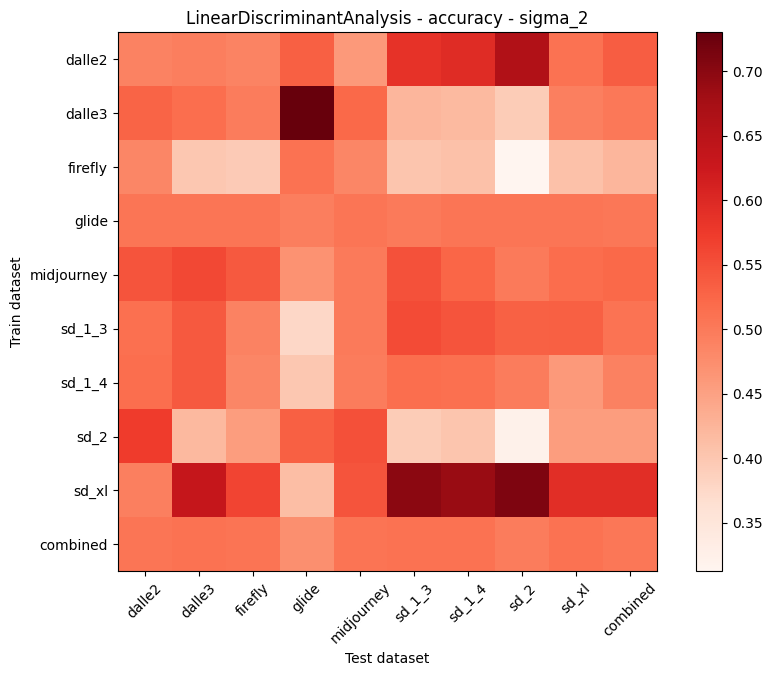

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4900  0.4950   0.4875  0.5325      0.4600  0.5850  0.5950   
dalle3         0.5275  0.5150   0.4975  0.7300      0.5225  0.4225  0.4175   
firefly        0.4850  0.4000   0.3950  0.5100      0.4850  0.4025  0.4075   
glide          0.5050  0.5050   0.5050  0.4950      0.5050  0.5000  0.5050   
midjourney     0.5450  0.5575   0.5400  0.4675      0.5000  0.5475  0.5250   
sd_1_3         0.5125  0.5400   0.4900  0.3775      0.5000  0.5550  0.5450   
sd_1_4         0.5150  0.5400   0.4850  0.4000      0.4975  0.5150  0.5125   
sd_2           0.5725  0.4200   0.4550  0.5325      0.5500  0.3925  0.4025   
sd_xl          0.4925  0.6325   0.5625  0.4125      0.5450  0.6975  0.6875   
combined       0.5050  0.5100   0.5075  0.4725      0.5075  0.5100  0.5100   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6600  0.5100  0.535000  
dalle3         0.3925  0.4925  0.501944  
firefly        0.3125  0.4075  0.422778  
glide          0.5050  0.5050  0.503333  
midjourney     0.5000  0.5175  0.522222  
sd_1_3         0.5300  0.5325  0.509167  
sd_1_4         0.4975  0.4600  0.491389  
sd_2           0.3225  0.4550  0.455833  
sd_xl          0.7100  0.5925  0.592500  
combined       0.4975  0.5100  0.503333

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4900  0.4950   0.4875  0.5325      0.4600  0.5850  0.5950   
dalle3         0.5275  0.5150   0.4975  0.7300      0.5225  0.4225  0.4175   
firefly        0.4850  0.4000   0.3950  0.5100      0.4850  0.4025  0.4075   
glide          0.5050  0.5050   0.5050  0.4950      0.5050  0.5000  0.5050   
midjourney     0.5450  0.5575   0.5400  0.4675      0.5000  0.5475  0.5250   
sd_1_3         0.5125  0.5400   0.4900  0.3775      0.5000  0.5550  0.5450   
sd_1_4         0.5150  0.5400   0.4850  0.4000      0.4975  0.5150  0.5125   
sd_2           0.5725  0.4200   0.4550  0.5325      0.5500  0.3925  0.4025   
sd_xl          0.4925  0.6325   0.5625  0.4125      0.5450  0.6975  0.6875   
combined       0.5050  0.5100   0.5075  0.4725      0.5075  0.5100  0.5100   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6600  0.5100  0.535000  
dalle3         0.3925  0.4925  0.501944  
firefly        0.3125  0.4075  0.422778  
glide          0.5050  0.5050  0.503333  
midjourney     0.5000  0.5175  0.522222  
sd_1_3         0.5300  0.5325  0.509167  
sd_1_4         0.4975  0.4600  0.491389  
sd_2           0.3225  0.4550  0.455833  
sd_xl          0.7100  0.5925  0.592500  
combined       0.4975  0.5100  0.503333

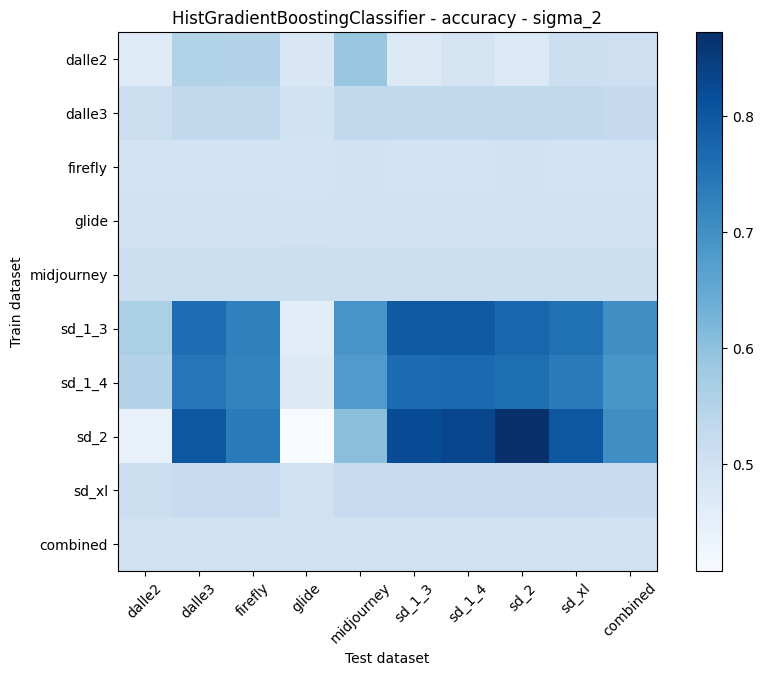

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4650  0.5525   0.5500  0.4775      0.5875  0.4675  0.4875   
dalle3         0.5125  0.5300   0.5300  0.4950      0.5300  0.5300  0.5300   
firefly        0.4925  0.4925   0.4925  0.4925      0.4950  0.4925  0.4925   
glide          0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
midjourney     0.5075  0.5075   0.5075  0.5075      0.5075  0.5075  0.5075   
sd_1_3         0.5625  0.7625   0.7275  0.4550      0.6900  0.7975  0.7975   
sd_1_4         0.5500  0.7475   0.7225  0.4675      0.6775  0.7650  0.7675   
sd_2           0.4425  0.8025   0.7375  0.4075      0.6050  0.8200  0.8300   
sd_xl          0.5125  0.5225   0.5225  0.5000      0.5225  0.5225  0.5225   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.4700  0.5075  0.507222  
dalle3         0.5300  0.5300  0.524167  
firefly        0.4950  0.4925  0.493056  
glide          0.5000  0.5000  0.499722  
midjourney     0.5075  0.5075  0.507500  
sd_1_3         0.7750  0.7575  0.702778  
sd_1_4         0.7600  0.7375  0.688333  
sd_2           0.8725  0.8025  0.702222  
sd_xl          0.5225  0.5225  0.518889  
combined       0.5000  0.5000  0.500000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4650  0.5525   0.5500  0.4775      0.5875  0.4675  0.4875   
dalle3         0.5125  0.5300   0.5300  0.4950      0.5300  0.5300  0.5300   
firefly        0.4925  0.4925   0.4925  0.4925      0.4950  0.4925  0.4925   
glide          0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
midjourney     0.5075  0.5075   0.5075  0.5075      0.5075  0.5075  0.5075   
sd_1_3         0.5625  0.7625   0.7275  0.4550      0.6900  0.7975  0.7975   
sd_1_4         0.5500  0.7475   0.7225  0.4675      0.6775  0.7650  0.7675   
sd_2           0.4425  0.8025   0.7375  0.4075      0.6050  0.8200  0.8300   
sd_xl          0.5125  0.5225   0.5225  0.5000      0.5225  0.5225  0.5225   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.4700  0.5075  0.507222  
dalle3         0.5300  0.5300  0.524167  
firefly        0.4950  0.4925  0.493056  
glide          0.5000  0.5000  0.499722  
midjourney     0.5075  0.5075  0.507500  
sd_1_3         0.7750  0.7575  0.702778  
sd_1_4         0.7600  0.7375  0.688333  
sd_2           0.8725  0.8025  0.702222  
sd_xl          0.5225  0.5225  0.518889  
combined       0.5000  0.5000  0.500000

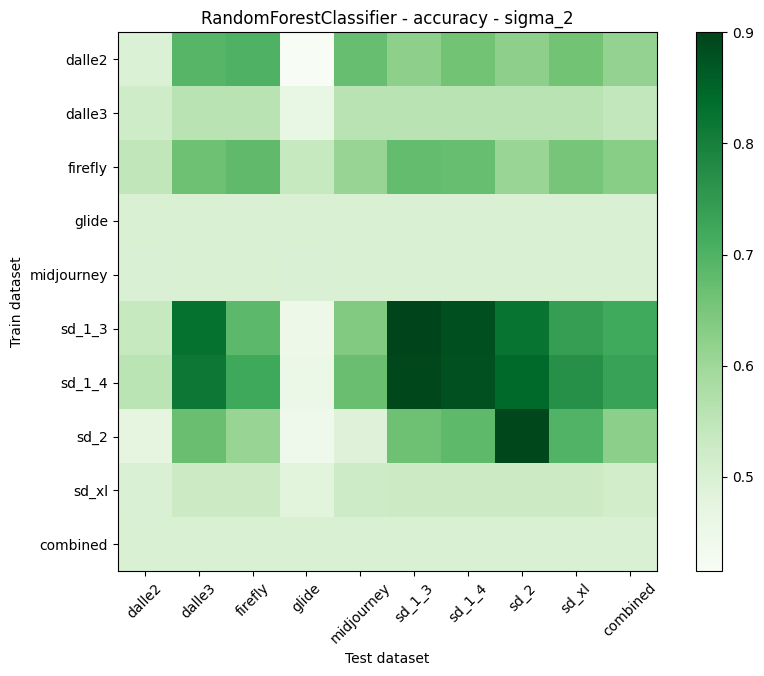

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4950  0.6925   0.7025  0.4150      0.6725  0.6225  0.6575   
dalle3         0.5200  0.5575   0.5575  0.4625      0.5575  0.5575  0.5575   
firefly        0.5475  0.6650   0.6800  0.5350      0.6100  0.6750  0.6725   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   
midjourney     0.4975  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.5350  0.8275   0.6850  0.4475      0.6375  0.9000  0.8825   
sd_1_4         0.5550  0.8150   0.7225  0.4550      0.6700  0.8925  0.8800   
sd_2           0.4750  0.6700   0.6100  0.4450      0.4875  0.6650  0.6825   
sd_xl          0.4975  0.5250   0.5250  0.4800      0.5225  0.5250  0.5250   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6225  0.6575  0.615278  
dalle3         0.5575  0.5575  0.542778  
firefly        0.6075  0.6525  0.627222  
glide          0.5000  0.5000  0.500000  
midjourney     0.5000  0.5000  0.499444  
sd_1_3         0.8225  0.7425  0.720000  
sd_1_4         0.8425  0.7675  0.733333  
sd_2           0.8925  0.6975  0.625000  
sd_xl          0.5250  0.5250  0.516667  
combined       0.5000  0.5000  0.500000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4950  0.6925   0.7025  0.4150      0.6725  0.6225  0.6575   
dalle3         0.5200  0.5575   0.5575  0.4625      0.5575  0.5575  0.5575   
firefly        0.5475  0.6650   0.6800  0.5350      0.6100  0.6750  0.6725   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   
midjourney     0.4975  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.5350  0.8275   0.6850  0.4475      0.6375  0.9000  0.8825   
sd_1_4         0.5550  0.8150   0.7225  0.4550      0.6700  0.8925  0.8800   
sd_2           0.4750  0.6700   0.6100  0.4450      0.4875  0.6650  0.6825   
sd_xl          0.4975  0.5250   0.5250  0.4800      0.5225  0.5250  0.5250   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6225  0.6575  0.615278  
dalle3         0.5575  0.5575  0.542778  
firefly        0.6075  0.6525  0.627222  
glide          0.5000  0.5000  0.500000  
midjourney     0.5000  0.5000  0.499444  
sd_1_3         0.8225  0.7425  0.720000  
sd_1_4         0.8425  0.7675  0.733333  
sd_2           0.8925  0.6975  0.625000  
sd_xl          0.5250  0.5250  0.516667  
combined       0.5000  0.5000  0.500000

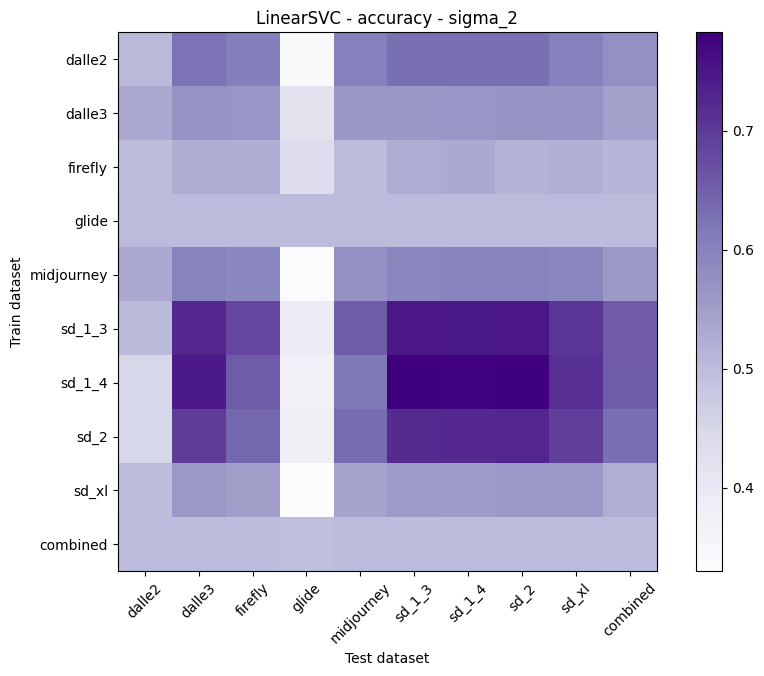

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5025  0.6250   0.6050  0.3400      0.6025  0.6300  0.6300   
dalle3         0.5300  0.5675   0.5650  0.4200      0.5625  0.5625  0.5650   
firefly        0.4975  0.5250   0.5250  0.4375      0.5000  0.5275  0.5300   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   
midjourney     0.5325  0.5975   0.5900  0.3350      0.5725  0.5925  0.5975   
sd_1_3         0.5025  0.7250   0.6825  0.3925      0.6550  0.7475  0.7450   
sd_1_4         0.4500  0.7450   0.6550  0.3700      0.6150  0.7825  0.7775   
sd_2           0.4500  0.6975   0.6400  0.3800      0.6325  0.7200  0.7225   
sd_xl          0.4975  0.5600   0.5475  0.3300      0.5425  0.5550  0.5525   
combined       0.5000  0.5000   0.5000  0.4950      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6300  0.6025  0.574167  
dalle3         0.5675  0.5675  0.545278  
firefly        0.5150  0.5225  0.508889  
glide          0.5000  0.5000  0.500000  
midjourney     0.6000  0.5925  0.556667  
sd_1_3         0.7475  0.7050  0.655833  
sd_1_4         0.7800  0.7125  0.654167  
sd_2           0.7275  0.6925  0.629167  
sd_xl          0.5600  0.5600  0.522778  
combined       0.5000  0.5000  0.499444

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5025  0.6250   0.6050  0.3400      0.6025  0.6300  0.6300   
dalle3         0.5300  0.5675   0.5650  0.4200      0.5625  0.5625  0.5650   
firefly        0.4975  0.5250   0.5250  0.4375      0.5000  0.5275  0.5300   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   
midjourney     0.5325  0.5975   0.5900  0.3350      0.5725  0.5925  0.5975   
sd_1_3         0.5025  0.7250   0.6825  0.3925      0.6550  0.7475  0.7450   
sd_1_4         0.4500  0.7450   0.6550  0.3700      0.6150  0.7825  0.7775   
sd_2           0.4500  0.6975   0.6400  0.3800      0.6325  0.7200  0.7225   
sd_xl          0.4975  0.5600   0.5475  0.3300      0.5425  0.5550  0.5525   
combined       0.5000  0.5000   0.5000  0.4950      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6300  0.6025  0.574167  
dalle3         0.5675  0.5675  0.545278  
firefly        0.5150  0.5225  0.508889  
glide          0.5000  0.5000  0.500000  
midjourney     0.6000  0.5925  0.556667  
sd_1_3         0.7475  0.7050  0.655833  
sd_1_4         0.7800  0.7125  0.654167  
sd_2           0.7275  0.6925  0.629167  
sd_xl          0.5600  0.5600  0.522778  
combined       0.5000  0.5000  0.499444









 ################ Evaluating models trained on standard and tested on sigma_3. ################


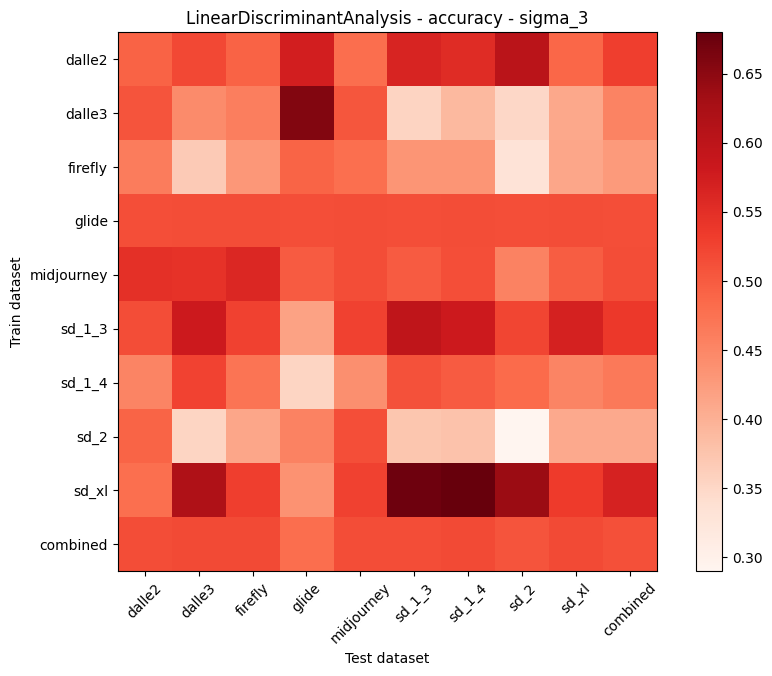

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4925  0.5200   0.4925  0.5725      0.4800  0.5650  0.5550   
dalle3         0.5075  0.4450   0.4600  0.6575      0.5050  0.3550  0.3900   
firefly        0.4625  0.3675   0.4300  0.4900      0.4775  0.4325  0.4325   
glide          0.5125  0.5150   0.5150  0.5125      0.5150  0.5125  0.5150   
midjourney     0.5475  0.5450   0.5600  0.5000      0.5150  0.5000  0.5125   
sd_1_3         0.5150  0.5800   0.5275  0.4175      0.5275  0.5975  0.5800   
sd_1_4         0.4525  0.5250   0.4725  0.3525      0.4400  0.5100  0.5000   
sd_2           0.4900  0.3525   0.4125  0.4550      0.5125  0.3725  0.3775   
sd_xl          0.4775  0.6175   0.5300  0.4350      0.5275  0.6725  0.6800   
combined       0.5150  0.5175   0.5175  0.4800      0.5150  0.5150  0.5175   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6025  0.4875  0.529722  
dalle3         0.3500  0.4100  0.453333  
firefly        0.3300  0.4125  0.426111  
glide          0.5125  0.5150  0.513889  
midjourney     0.4550  0.4975  0.514722  
sd_1_3         0.5225  0.5700  0.537500  
sd_1_4         0.4825  0.4525  0.465278  
sd_2           0.2900  0.4075  0.407778  
sd_xl          0.6375  0.5350  0.568056  
combined       0.5075  0.5175  0.511389

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4925  0.5200   0.4925  0.5725      0.4800  0.5650  0.5550   
dalle3         0.5075  0.4450   0.4600  0.6575      0.5050  0.3550  0.3900   
firefly        0.4625  0.3675   0.4300  0.4900      0.4775  0.4325  0.4325   
glide          0.5125  0.5150   0.5150  0.5125      0.5150  0.5125  0.5150   
midjourney     0.5475  0.5450   0.5600  0.5000      0.5150  0.5000  0.5125   
sd_1_3         0.5150  0.5800   0.5275  0.4175      0.5275  0.5975  0.5800   
sd_1_4         0.4525  0.5250   0.4725  0.3525      0.4400  0.5100  0.5000   
sd_2           0.4900  0.3525   0.4125  0.4550      0.5125  0.3725  0.3775   
sd_xl          0.4775  0.6175   0.5300  0.4350      0.5275  0.6725  0.6800   
combined       0.5150  0.5175   0.5175  0.4800      0.5150  0.5150  0.5175   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6025  0.4875  0.529722  
dalle3         0.3500  0.4100  0.453333  
firefly        0.3300  0.4125  0.426111  
glide          0.5125  0.5150  0.513889  
midjourney     0.4550  0.4975  0.514722  
sd_1_3         0.5225  0.5700  0.537500  
sd_1_4         0.4825  0.4525  0.465278  
sd_2           0.2900  0.4075  0.407778  
sd_xl          0.6375  0.5350  0.568056  
combined       0.5075  0.5175  0.511389

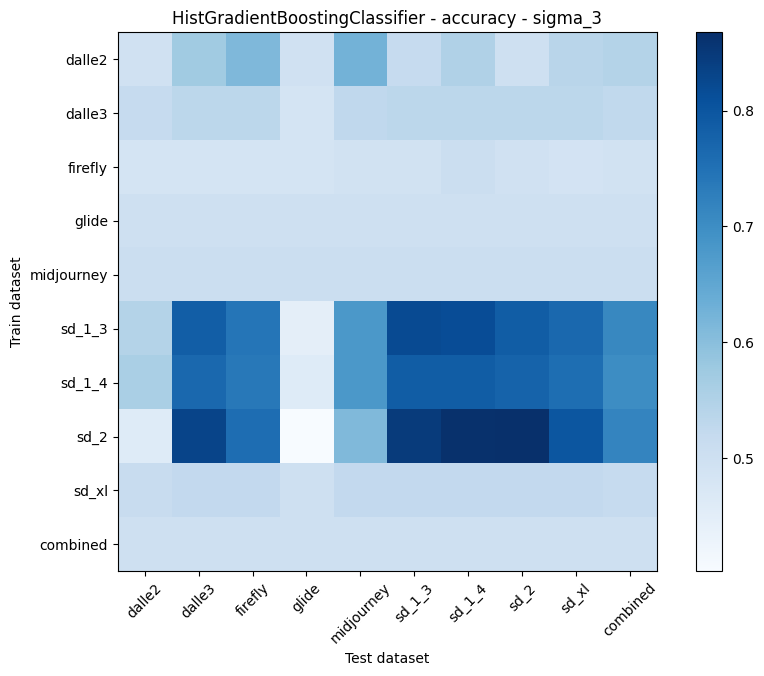

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4950  0.5725   0.6125  0.4950      0.6250  0.5175  0.5500   
dalle3         0.5175  0.5325   0.5325  0.4825      0.5275  0.5325  0.5325   
firefly        0.4850  0.4850   0.4850  0.4850      0.4900  0.4925  0.5050   
glide          0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.4975   
midjourney     0.5075  0.5075   0.5075  0.5075      0.5075  0.5075  0.5075   
sd_1_3         0.5450  0.7850   0.7425  0.4475      0.6800  0.8200  0.8150   
sd_1_4         0.5600  0.7675   0.7375  0.4600      0.6800  0.7875  0.7875   
sd_2           0.4600  0.8300   0.7575  0.4025      0.6100  0.8475  0.8650   
sd_xl          0.5125  0.5225   0.5225  0.4975      0.5225  0.5225  0.5225   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.4975  0.5375  0.544722  
dalle3         0.5325  0.5325  0.524722  
firefly        0.4950  0.4875  0.490000  
glide          0.4975  0.5000  0.499167  
midjourney     0.5075  0.5075  0.507500  
sd_1_3         0.7875  0.7675  0.710000  
sd_1_4         0.7750  0.7550  0.701111  
sd_2           0.8675  0.8000  0.715556  
sd_xl          0.5225  0.5225  0.518611  
combined       0.5000  0.5000  0.500000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4950  0.5725   0.6125  0.4950      0.6250  0.5175  0.5500   
dalle3         0.5175  0.5325   0.5325  0.4825      0.5275  0.5325  0.5325   
firefly        0.4850  0.4850   0.4850  0.4850      0.4900  0.4925  0.5050   
glide          0.5000  0.5000   0.5000  0.4975      0.5000  0.5000  0.4975   
midjourney     0.5075  0.5075   0.5075  0.5075      0.5075  0.5075  0.5075   
sd_1_3         0.5450  0.7850   0.7425  0.4475      0.6800  0.8200  0.8150   
sd_1_4         0.5600  0.7675   0.7375  0.4600      0.6800  0.7875  0.7875   
sd_2           0.4600  0.8300   0.7575  0.4025      0.6100  0.8475  0.8650   
sd_xl          0.5125  0.5225   0.5225  0.4975      0.5225  0.5225  0.5225   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.4975  0.5375  0.544722  
dalle3         0.5325  0.5325  0.524722  
firefly        0.4950  0.4875  0.490000  
glide          0.4975  0.5000  0.499167  
midjourney     0.5075  0.5075  0.507500  
sd_1_3         0.7875  0.7675  0.710000  
sd_1_4         0.7750  0.7550  0.701111  
sd_2           0.8675  0.8000  0.715556  
sd_xl          0.5225  0.5225  0.518611  
combined       0.5000  0.5000  0.500000

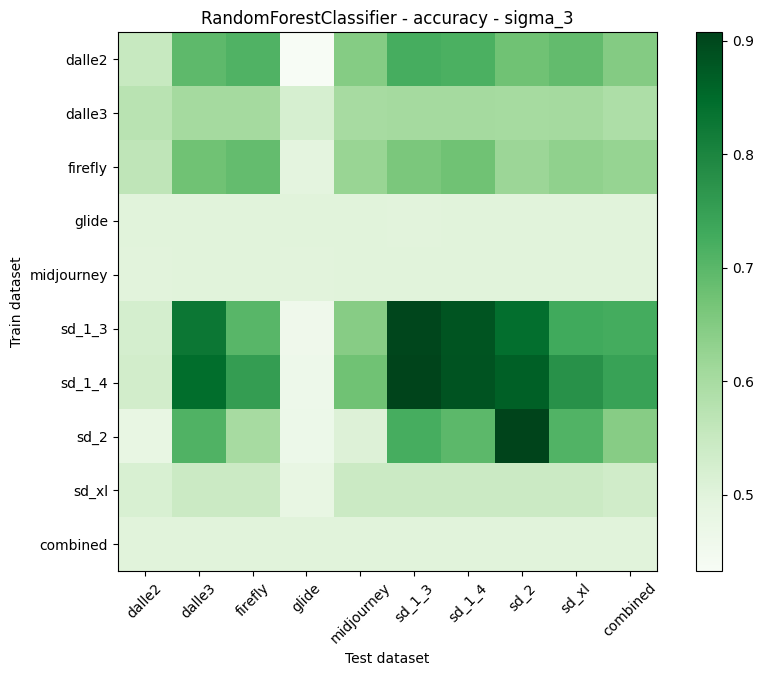

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5500  0.6950   0.7125  0.4325      0.6475  0.7225  0.7175   
dalle3         0.5725  0.6050   0.6050  0.5200      0.6000  0.6050  0.6050   
firefly        0.5625  0.6750   0.6875  0.4925      0.6200  0.6600  0.6750   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.4975  0.5000   
midjourney     0.4975  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.5250  0.8275   0.7025  0.4600      0.6450  0.9025  0.8825   
sd_1_4         0.5300  0.8450   0.7550  0.4625      0.6750  0.9075  0.8850   
sd_2           0.4825  0.7125   0.6000  0.4675      0.5075  0.7225  0.6975   
sd_xl          0.5175  0.5425   0.5425  0.4825      0.5425  0.5425  0.5425   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.6750  0.6900  0.649167  
dalle3         0.6025  0.6050  0.591111  
firefly        0.6175  0.6325  0.624722  
glide          0.5000  0.5000  0.499722  
midjourney     0.5000  0.5000  0.499444  
sd_1_3         0.8425  0.7300  0.724167  
sd_1_4         0.8650  0.7775  0.744722  
sd_2           0.9075  0.7100  0.645278  
sd_xl          0.5425  0.5425  0.533056  
combined       0.5000  0.5000  0.500000

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.5500  0.6950   0.7125  0.4325      0.6475  0.7225  0.7175   
dalle3         0.5725  0.6050   0.6050  0.5200      0.6000  0.6050  0.6050   
firefly        0.5625  0.6750   0.6875  0.4925      0.6200  0.6600  0.6750   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.4975  0.5000   
midjourney     0.4975  0.5000   0.5000  0.4975      0.5000  0.5000  0.5000   
sd_1_3         0.5250  0.8275   0.7025  0.4600      0.6450  0.9025  0.8825   
sd_1_4         0.5300  0.8450   0.7550  0.4625      0.6750  0.9075  0.8850   
sd_2           0.4825  0.7125   0.6000  0.4675      0.5075  0.7225  0.6975   
sd_xl          0.5175  0.5425   0.5425  0.4825      0.5425  0.5425  0.5425   
combined       0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.5000   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.6750  0.6900  0.649167  
dalle3         0.6025  0.6050  0.591111  
firefly        0.6175  0.6325  0.624722  
glide          0.5000  0.5000  0.499722  
midjourney     0.5000  0.5000  0.499444  
sd_1_3         0.8425  0.7300  0.724167  
sd_1_4         0.8650  0.7775  0.744722  
sd_2           0.9075  0.7100  0.645278  
sd_xl          0.5425  0.5425  0.533056  
combined       0.5000  0.5000  0.500000

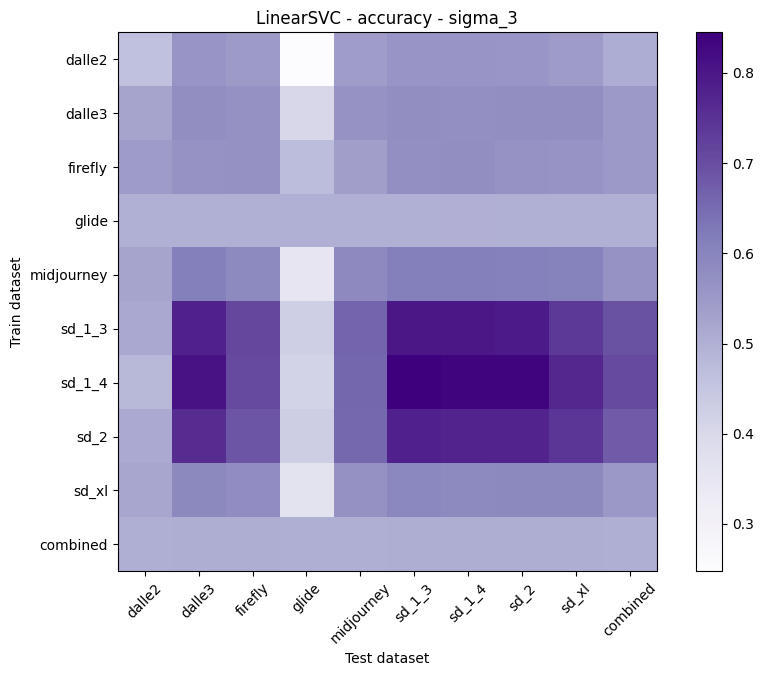

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4600  0.5600   0.5450  0.2475      0.5400  0.5600  0.5600   
dalle3         0.5250  0.5750   0.5675  0.4025      0.5650  0.5750  0.5725   
firefly        0.5425  0.5650   0.5675  0.4700      0.5350  0.5725  0.5750   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.4975   
midjourney     0.5275  0.6125   0.5875  0.3525      0.5850  0.6125  0.6100   
sd_1_3         0.5150  0.7800   0.7100  0.4250      0.6625  0.8000  0.8000   
sd_1_4         0.4800  0.8100   0.7050  0.4150      0.6575  0.8450  0.8350   
sd_2           0.5125  0.7600   0.6875  0.4275      0.6550  0.7800  0.7750   
sd_xl          0.5200  0.5900   0.5775  0.3625      0.5675  0.5925  0.5875   
combined       0.5025  0.5050   0.5050  0.5025      0.5025  0.5050  0.5050   

test_dataset     sd_2   sd_xl  combined  
train_dataset                            
dalle2         0.5575  0.5425  0.508056  
dalle3         0.5750  0.5750  0.548056  
firefly        0.5650  0.5625  0.550556  
glide          0.5000  0.5000  0.499722  
midjourney     0.6075  0.6050  0.566667  
sd_1_3         0.7925  0.7375  0.691389  
sd_1_4         0.8350  0.7700  0.705833  
sd_2           0.7750  0.7400  0.679167  
sd_xl          0.5900  0.5900  0.553056  
combined       0.5050  0.5050  0.504167

test_dataset   dalle2  dalle3  firefly   glide  midjourney  sd_1_3  sd_1_4  \
train_dataset                                                                
dalle2         0.4600  0.5600   0.5450  0.2475      0.5400  0.5600  0.5600   
dalle3         0.5250  0.5750   0.5675  0.4025      0.5650  0.5750  0.5725   
firefly        0.5425  0.5650   0.5675  0.4700      0.5350  0.5725  0.5750   
glide          0.5000  0.5000   0.5000  0.5000      0.5000  0.5000  0.4975   
midjourney     0.5275  0.6125   0.5875  0.3525      0.5850  0.6125  0.6100   
sd_1_3         0.5150  0.7800   0.7100  0.4250      0.6625  0.8000  0.8000   
sd_1_4         0.4800  0.8100   0.7050  0.4150      0.6575  0.8450  0.8350   
sd_2           0.5125  0.7600   0.6875  0.4275      0.6550  0.7800  0.7750   
sd_xl          0.5200  0.5900   0.5775  0.3625      0.5675  0.5925  0.5875   
combined       0.5025  0.5050   0.5050  0.5025      0.5025  0.5050  0.5050   

test_dataset     sd_2   sd_xl   average  
train_dataset                            
dalle2         0.5575  0.5425  0.508056  
dalle3         0.5750  0.5750  0.548056  
firefly        0.5650  0.5625  0.550556  
glide          0.5000  0.5000  0.499722  
midjourney     0.6075  0.6050  0.566667  
sd_1_3         0.7925  0.7375  0.691389  
sd_1_4         0.8350  0.7700  0.705833  
sd_2           0.7750  0.7400  0.679167  
sd_xl          0.5900  0.5900  0.553056  
combined       0.5050  0.5050  0.504167

In [15]:
print("########################### Accuracy ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "accuracy"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)

### MCC - Test

########################### MCC ###########################








 ################ Evaluating models trained on standard and tested on standard. ################


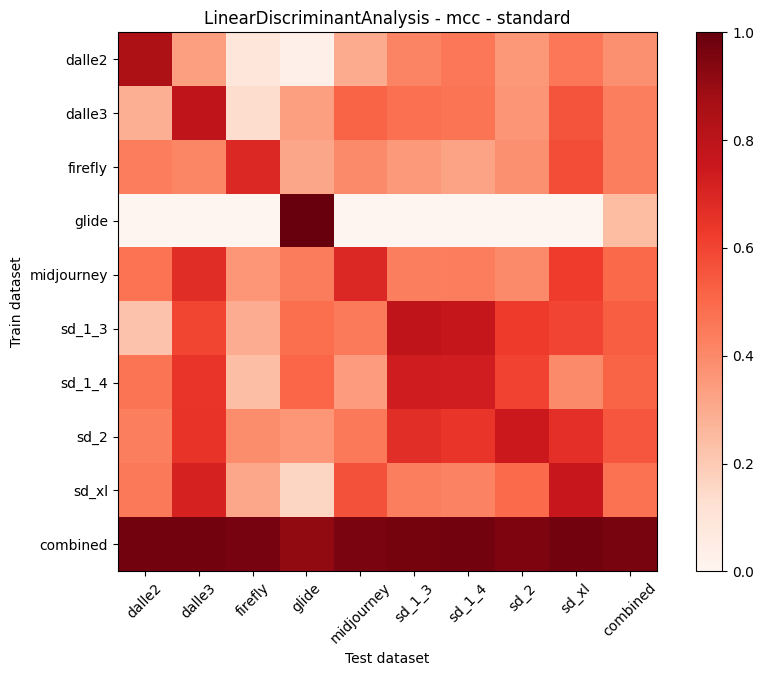

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.845011  0.333297  0.088782  0.034943    0.300000  0.414779   
dalle3         0.287133  0.792253  0.136119  0.338990    0.515073  0.477804   
firefly        0.439019  0.410628  0.689575  0.316309    0.401191  0.354079   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.471915  0.674091  0.362703  0.443203    0.690415  0.433680   
sd_1_3         0.224211  0.595067  0.291864  0.484108    0.446499  0.785770   
sd_1_4         0.468106  0.646367  0.240676  0.511254    0.345531  0.732744   
sd_2           0.437140  0.650521  0.390468  0.362466    0.451184  0.671209   
sd_xl          0.451184  0.713577  0.310824  0.163784    0.565573  0.437140   
combined       0.975305  0.975305  0.965109  0.910729    0.960048  0.970194   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.458466  0.356436  0.458466  0.379646  
dalle3         0.468535  0.366900  0.557522  0.436697  
firefly        0.321041  0.382340  0.575007  0.430066  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.438439  0.400489  0.621119  0.500902  
sd_1_3         0.768697  0.625070  0.600030  0.530104  
sd_1_4         0.727161  0.605189  0.401938  0.515016  
sd_2           0.645395  0.746333  0.666008  0.553685  
sd_xl          0.418454  0.498306  0.757460  0.476245  
combined       0.975305  0.950000  0.975305  0.961732

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.845011  0.333297  0.088782  0.034943    0.300000  0.414779   
dalle3         0.287133  0.792253  0.136119  0.338990    0.515073  0.477804   
firefly        0.439019  0.410628  0.689575  0.316309    0.401191  0.354079   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.471915  0.674091  0.362703  0.443203    0.690415  0.433680   
sd_1_3         0.224211  0.595067  0.291864  0.484108    0.446499  0.785770   
sd_1_4         0.468106  0.646367  0.240676  0.511254    0.345531  0.732744   
sd_2           0.437140  0.650521  0.390468  0.362466    0.451184  0.671209   
sd_xl          0.451184  0.713577  0.310824  0.163784    0.565573  0.437140   
combined       0.975305  0.975305  0.965109  0.910729    0.960048  0.970194   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.458466  0.356436  0.458466  0.365575  
dalle3         0.468535  0.366900  0.557522  0.437814  
firefly        0.321041  0.382340  0.575007  0.432132  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.438439  0.400489  0.621119  0.504006  
sd_1_3         0.768697  0.625070  0.600030  0.535702  
sd_1_4         0.727161  0.605189  0.401938  0.519885  
sd_2           0.645395  0.746333  0.666008  0.557858  
sd_xl          0.418454  0.498306  0.757460  0.479589  
combined       0.975305  0.950000  0.975305  0.961922

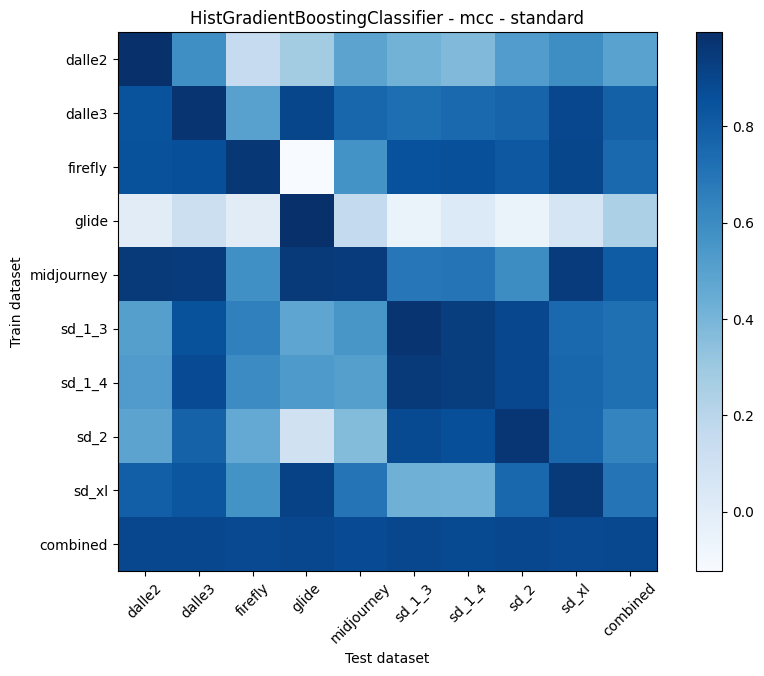

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990050  0.585639  0.153093  0.274272    0.487033  0.413381   
dalle3         0.844232  0.970437  0.499899  0.895908    0.759582  0.725312   
firefly        0.848839  0.862765  0.960192 -0.123404    0.568939  0.853464   
glide          0.000000  0.118002  0.000000  0.995012    0.163239 -0.050063   
midjourney     0.950190  0.945106  0.582357  0.955299    0.945106  0.685458   
sd_1_3         0.507077  0.850644  0.647151  0.478735    0.551145  0.970049   
sd_1_4         0.526299  0.875887  0.600245  0.534522    0.509819  0.955585   
sd_2           0.487130  0.778437  0.458349  0.096477    0.368243  0.877471   
sd_xl          0.793385  0.829586  0.570122  0.915103    0.702301  0.425383   
combined       0.890911  0.890911  0.885373  0.890911    0.874383  0.890911   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.374654  0.518823  0.589562  0.495017  
dalle3         0.750949  0.768261  0.891115  0.784792  
firefly        0.858106  0.821443  0.895908  0.746172  
glide          0.028976 -0.050063  0.067505  0.245943  
midjourney     0.698078  0.594603  0.945106  0.802844  
sd_1_3         0.935292  0.892189  0.754342  0.724006  
sd_1_4         0.935105  0.890401  0.761078  0.723797  
sd_2           0.863504  0.965109  0.756877  0.631501  
sd_xl          0.421103  0.758086  0.955299  0.701362  
combined       0.879864  0.890911  0.885373  0.886601

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.990050  0.585639  0.153093  0.274272    0.487033  0.413381   
dalle3         0.844232  0.970437  0.499899  0.895908    0.759582  0.725312   
firefly        0.848839  0.862765  0.960192 -0.123404    0.568939  0.853464   
glide          0.000000  0.118002  0.000000  0.995012    0.163239 -0.050063   
midjourney     0.950190  0.945106  0.582357  0.955299    0.945106  0.685458   
sd_1_3         0.507077  0.850644  0.647151  0.478735    0.551145  0.970049   
sd_1_4         0.526299  0.875887  0.600245  0.534522    0.509819  0.955585   
sd_2           0.487130  0.778437  0.458349  0.096477    0.368243  0.877471   
sd_xl          0.793385  0.829586  0.570122  0.915103    0.702301  0.425383   
combined       0.890911  0.890911  0.885373  0.890911    0.874383  0.890911   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.374654  0.518823  0.589562  0.487390  
dalle3         0.750949  0.768261  0.891115  0.789521  
firefly        0.858106  0.821443  0.895908  0.727361  
glide          0.028976 -0.050063  0.067505  0.141401  
midjourney     0.698078  0.594603  0.945106  0.811256  
sd_1_3         0.935292  0.892189  0.754342  0.731847  
sd_1_4         0.935105  0.890401  0.761078  0.732105  
sd_2           0.863504  0.965109  0.756877  0.627955  
sd_xl          0.421103  0.758086  0.955299  0.707819  
combined       0.879864  0.890911  0.885373  0.886616

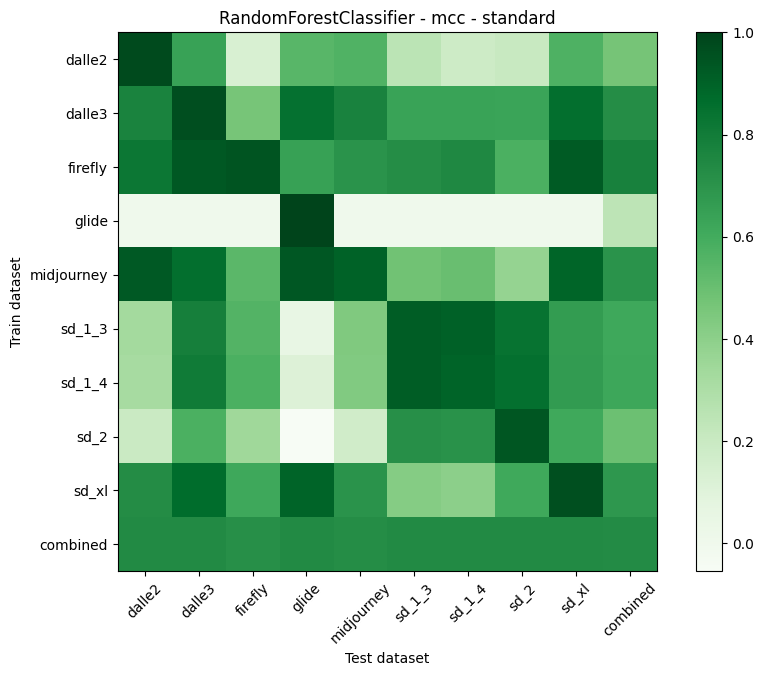

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975305  0.640513  0.131590  0.543807    0.563912  0.250000   
dalle3         0.765466  0.965109  0.462487  0.845129    0.769777  0.636455   
firefly        0.820443  0.930000  0.945106  0.643856    0.702301  0.727832   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.926402  0.855096  0.538195  0.936981    0.900405  0.478843   
sd_1_3         0.328976  0.785677  0.558014  0.051640    0.436322  0.915103   
sd_1_4         0.317147  0.802572  0.578422  0.112173    0.434471  0.915561   
sd_2           0.195724  0.577115  0.342135 -0.054413    0.170523  0.715965   
sd_xl          0.732121  0.866833  0.615061  0.895549    0.702301  0.421103   
combined       0.737836  0.737836  0.718750  0.737836    0.725070  0.737836   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.183176  0.202733  0.567930  0.468447  
dalle3         0.636455  0.632401  0.854282  0.724825  
firefly        0.745053  0.578277  0.925012  0.774651  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.500098  0.374174  0.890178  0.700473  
sd_1_3         0.905011  0.836770  0.662794  0.613586  
sd_1_4         0.895101  0.850383  0.667906  0.619326  
sd_2           0.707330  0.940423  0.610262  0.492937  
sd_xl          0.399479  0.610964  0.960432  0.683128  
combined       0.737836  0.737836  0.737836  0.734273

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.975305  0.640513  0.131590  0.543807    0.563912  0.250000   
dalle3         0.765466  0.965109  0.462487  0.845129    0.769777  0.636455   
firefly        0.820443  0.930000  0.945106  0.643856    0.702301  0.727832   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.926402  0.855096  0.538195  0.936981    0.900405  0.478843   
sd_1_3         0.328976  0.785677  0.558014  0.051640    0.436322  0.915103   
sd_1_4         0.317147  0.802572  0.578422  0.112173    0.434471  0.915561   
sd_2           0.195724  0.577115  0.342135 -0.054413    0.170523  0.715965   
sd_xl          0.732121  0.866833  0.615061  0.895549    0.702301  0.421103   
combined       0.737836  0.737836  0.718750  0.737836    0.725070  0.737836   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.183176  0.202733  0.567930  0.450996  
dalle3         0.636455  0.632401  0.854282  0.729729  
firefly        0.745053  0.578277  0.925012  0.779764  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.500098  0.374174  0.890178  0.711153  
sd_1_3         0.905011  0.836770  0.662794  0.608923  
sd_1_4         0.895101  0.850383  0.667906  0.619304  
sd_2           0.707330  0.940423  0.610262  0.467229  
sd_xl          0.399479  0.610964  0.960432  0.689316  
combined       0.737836  0.737836  0.737836  0.734297

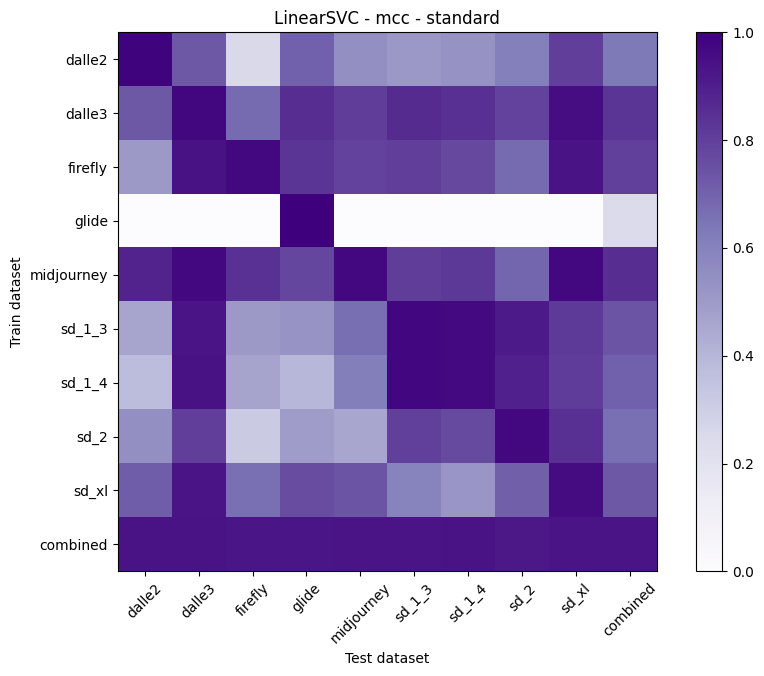

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.727001  0.251002  0.706438    0.546673  0.510892   
dalle3         0.727001  0.980049  0.677980  0.851680    0.807460  0.860710   
firefly        0.502895  0.945295  0.970000  0.829384    0.790169  0.803118   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.882830  0.970049  0.841601  0.779973    0.970049  0.806048   
sd_1_3         0.458259  0.930419  0.503047  0.527158    0.667386  0.975110   
sd_1_4         0.373026  0.940188  0.462373  0.390645    0.615012  0.975110   
sd_2           0.546401  0.804658  0.314772  0.491029    0.454764  0.800364   
sd_xl          0.714638  0.930745  0.661863  0.764605    0.739445  0.590202   
combined       0.936981  0.936981  0.926402  0.926402    0.931679  0.931679   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.534775  0.610010  0.803118  0.628992  
dalle3         0.847189  0.790169  0.955107  0.829875  
firefly        0.773079  0.677980  0.935573  0.797348  
glide          0.000000  0.000000  0.000000  0.242536  
midjourney     0.819269  0.687771  0.970049  0.855190  
sd_1_3         0.965012  0.911140  0.814848  0.740276  
sd_1_4         0.965012  0.892189  0.810441  0.703747  
sd_2           0.766465  0.970049  0.848355  0.661902  
sd_xl          0.518869  0.710534  0.960048  0.727460  
combined       0.936981  0.921152  0.931679  0.931091

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.985111  0.727001  0.251002  0.706438    0.546673  0.510892   
dalle3         0.727001  0.980049  0.677980  0.851680    0.807460  0.860710   
firefly        0.502895  0.945295  0.970000  0.829384    0.790169  0.803118   
glide          0.000000  0.000000  0.000000  1.000000    0.000000  0.000000   
midjourney     0.882830  0.970049  0.841601  0.779973    0.970049  0.806048   
sd_1_3         0.458259  0.930419  0.503047  0.527158    0.667386  0.975110   
sd_1_4         0.373026  0.940188  0.462373  0.390645    0.615012  0.975110   
sd_2           0.546401  0.804658  0.314772  0.491029    0.454764  0.800364   
sd_xl          0.714638  0.930745  0.661863  0.764605    0.739445  0.590202   
combined       0.936981  0.936981  0.926402  0.926402    0.931679  0.931679   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.534775  0.610010  0.803118  0.630558  
dalle3         0.847189  0.790169  0.955107  0.833038  
firefly        0.773079  0.677980  0.935573  0.803055  
glide          0.000000  0.000000  0.000000  0.111111  
midjourney     0.819269  0.687771  0.970049  0.858626  
sd_1_3         0.965012  0.911140  0.814848  0.750264  
sd_1_4         0.965012  0.892189  0.810441  0.713777  
sd_2           0.766465  0.970049  0.848355  0.666317  
sd_xl          0.518869  0.710534  0.960048  0.732328  
combined       0.936981  0.921152  0.931679  0.931104









 ################ Evaluating models trained on standard and tested on sigma_1. ################


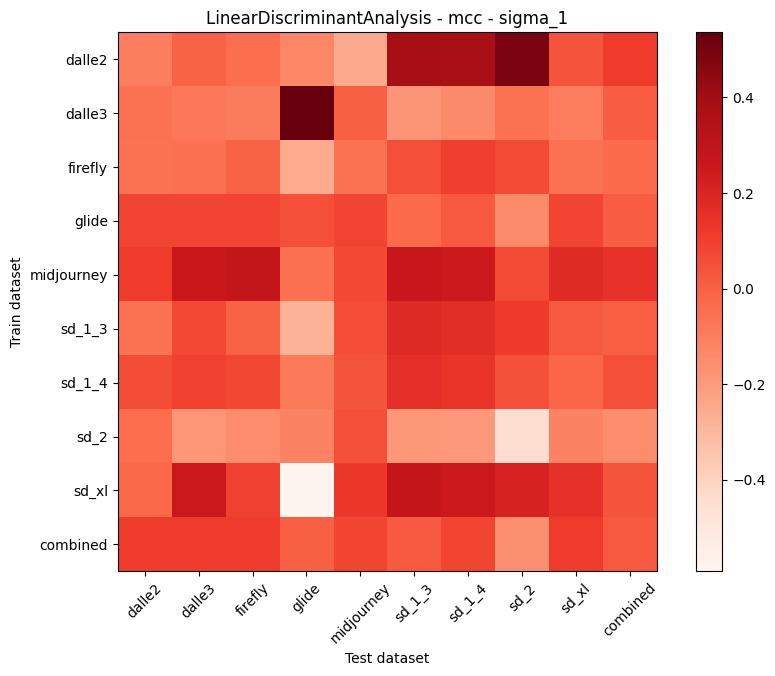

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.100423 -0.006221 -0.044836 -0.130397   -0.251630  0.383980   
dalle3        -0.057639 -0.073159 -0.089205  0.536065    0.000000 -0.179414   
firefly       -0.062125 -0.051137 -0.005833 -0.254825   -0.056647  0.048280   
glide          0.086929  0.086929  0.086929  0.050252    0.086929 -0.035714   
midjourney     0.109536  0.255940  0.281384 -0.049976    0.071287  0.264293   
sd_1_3        -0.060474  0.071715 -0.008071 -0.282503    0.052414  0.175575   
sd_1_4         0.057068  0.091101  0.077260 -0.086317    0.037500  0.157849   
sd_2          -0.037009 -0.182989 -0.148472 -0.118615    0.049217 -0.187900   
sd_xl         -0.025753  0.250000  0.092973 -0.591065    0.125356  0.272837   
combined       0.112509  0.112509  0.112509  0.000000    0.082269  0.016857   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.374605  0.487696  0.036210  0.112328  
dalle3        -0.141056 -0.057639 -0.097442  0.011248  
firefly        0.100000  0.067225 -0.056647 -0.035039  
glide          0.022502 -0.144715  0.086929  0.009494  
midjourney     0.247709  0.065100  0.171205  0.148457  
sd_1_3         0.162255  0.113899  0.025283  0.005475  
sd_1_4         0.134705  0.043957 -0.018032  0.051208  
sd_2          -0.192806 -0.441415 -0.118615 -0.154520  
sd_xl          0.250000  0.207741  0.151186  0.034661  
combined       0.082269 -0.162255  0.112509  0.024960

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.100423 -0.006221 -0.044836 -0.130397   -0.251630  0.383980   
dalle3        -0.057639 -0.073159 -0.089205  0.536065    0.000000 -0.179414   
firefly       -0.062125 -0.051137 -0.005833 -0.254825   -0.056647  0.048280   
glide          0.086929  0.086929  0.086929  0.050252    0.086929 -0.035714   
midjourney     0.109536  0.255940  0.281384 -0.049976    0.071287  0.264293   
sd_1_3        -0.060474  0.071715 -0.008071 -0.282503    0.052414  0.175575   
sd_1_4         0.057068  0.091101  0.077260 -0.086317    0.037500  0.157849   
sd_2          -0.037009 -0.182989 -0.148472 -0.118615    0.049217 -0.187900   
sd_xl         -0.025753  0.250000  0.092973 -0.591065    0.125356  0.272837   
combined       0.112509  0.112509  0.112509  0.000000    0.082269  0.016857   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.374605  0.487696  0.036210  0.083221  
dalle3        -0.141056 -0.057639 -0.097442 -0.017721  
firefly        0.100000  0.067225 -0.056647 -0.030190  
glide          0.022502 -0.144715  0.086929  0.036330  
midjourney     0.247709  0.065100  0.171205  0.157387  
sd_1_3         0.162255  0.113899  0.025283  0.027788  
sd_1_4         0.134705  0.043957 -0.018032  0.055010  
sd_2          -0.192806 -0.441415 -0.118615 -0.153178  
sd_xl          0.250000  0.207741  0.151186  0.081475  
combined       0.082269 -0.162255  0.112509  0.052131

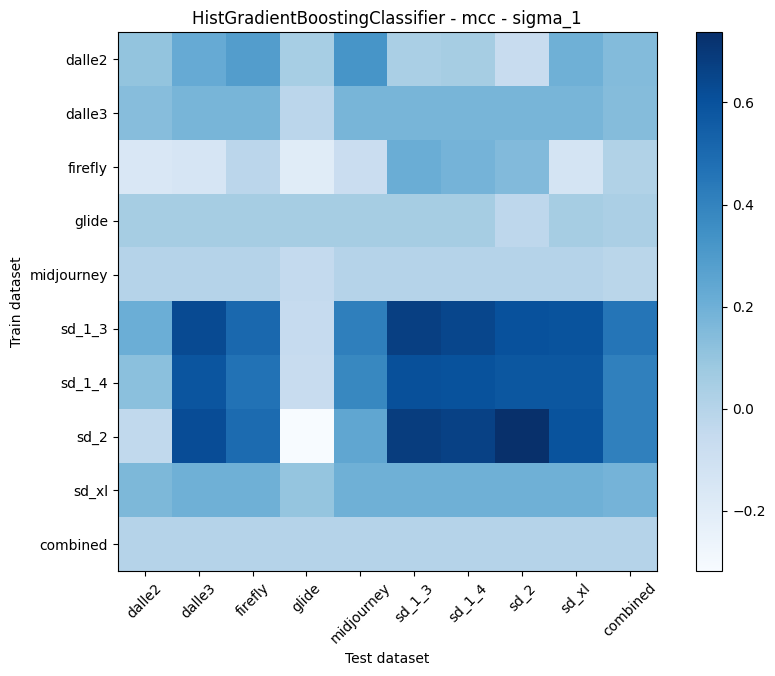

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.105752  0.225000  0.285149  0.045356    0.323316  0.038126   
dalle3         0.136032  0.175863  0.175863 -0.020282    0.175863  0.175863   
firefly       -0.161109 -0.144715 -0.019597 -0.197386   -0.075173  0.210042   
glide          0.050063  0.050063  0.050063  0.050063    0.050063  0.050063   
midjourney     0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.205579  0.626915  0.506853 -0.058373    0.413509  0.672538   
sd_1_4         0.125127  0.586245  0.465307 -0.065694    0.380792  0.608164   
sd_2          -0.039773  0.619010  0.495750 -0.318507    0.244949  0.682500   
sd_xl          0.161109  0.197386  0.197386  0.100882    0.197386  0.197386   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.052469 -0.069886  0.198559  0.146878  
dalle3         0.175863  0.175863  0.175863  0.140132  
firefly        0.181489  0.151186 -0.129287  0.015432  
glide          0.050063 -0.028976  0.050063  0.035230  
midjourney     0.000000  0.000000  0.000000 -0.016669  
sd_1_3         0.646199  0.601781  0.595595  0.454824  
sd_1_4         0.600792  0.579066  0.579066  0.408884  
sd_2           0.664825  0.737386  0.596752  0.410185  
sd_xl          0.197386  0.197386  0.197386  0.180628  
combined       0.000000  0.000000  0.000000  0.000000

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.105752  0.225000  0.285149  0.045356    0.323316  0.038126   
dalle3         0.136032  0.175863  0.175863 -0.020282    0.175863  0.175863   
firefly       -0.161109 -0.144715 -0.019597 -0.197386   -0.075173  0.210042   
glide          0.050063  0.050063  0.050063  0.050063    0.050063  0.050063   
midjourney     0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.205579  0.626915  0.506853 -0.058373    0.413509  0.672538   
sd_1_4         0.125127  0.586245  0.465307 -0.065694    0.380792  0.608164   
sd_2          -0.039773  0.619010  0.495750 -0.318507    0.244949  0.682500   
sd_xl          0.161109  0.197386  0.197386  0.100882    0.197386  0.197386   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.052469 -0.069886  0.198559  0.133760  
dalle3         0.175863  0.175863  0.175863  0.149644  
firefly        0.181489  0.151186 -0.129287 -0.020505  
glide          0.050063 -0.028976  0.050063  0.041281  
midjourney     0.000000  0.000000  0.000000 -0.005563  
sd_1_3         0.646199  0.601781  0.595595  0.467844  
sd_1_4         0.600792  0.579066  0.579066  0.428763  
sd_2           0.664825  0.737386  0.596752  0.409210  
sd_xl          0.197386  0.197386  0.197386  0.182632  
combined       0.000000  0.000000  0.000000  0.000000

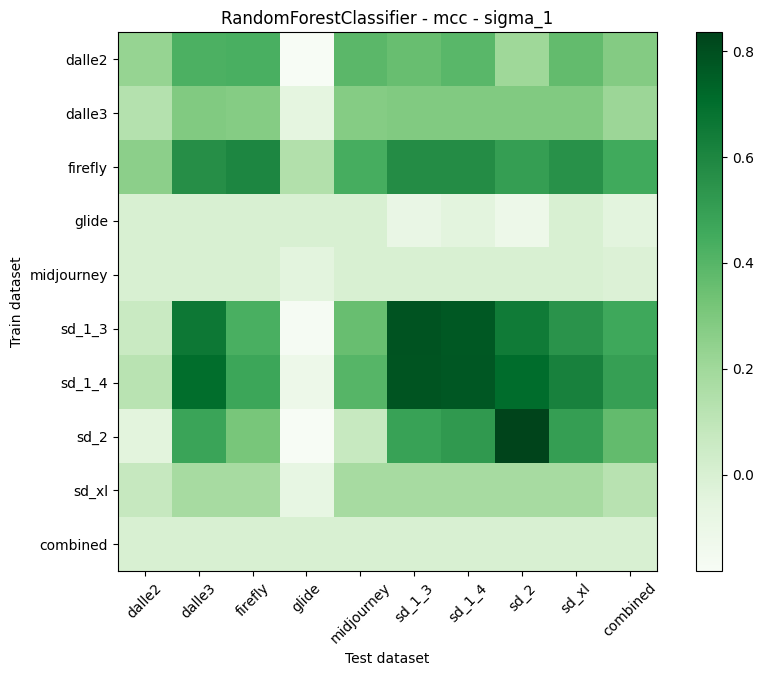

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.227836  0.425323  0.431976 -0.181790    0.386424  0.355209   
dalle3         0.134502  0.289846  0.276454 -0.058886    0.276454  0.289846   
firefly        0.258544  0.568939  0.597411  0.140175    0.438822  0.575967   
glide          0.000000  0.000000  0.000000  0.000000    0.000000 -0.086929   
midjourney     0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.062500  0.660033  0.431570 -0.169251    0.357617  0.786676   
sd_1_4         0.117925  0.701721  0.471462 -0.113604    0.401742  0.783278   
sd_2          -0.044237  0.480384  0.313664 -0.182564    0.068626  0.489140   
sd_xl          0.072357  0.175863  0.175863 -0.073721    0.175863  0.175863   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.392792  0.206021  0.367573  0.280166  
dalle3         0.289846  0.289846  0.289846  0.213226  
firefly        0.575967  0.501605  0.555054  0.457240  
glide         -0.050063 -0.112509  0.000000 -0.050063  
midjourney     0.000000  0.000000  0.000000 -0.016669  
sd_1_3         0.770109  0.645008  0.548029  0.463905  
sd_1_4         0.772068  0.706991  0.620031  0.498006  
sd_2           0.524142  0.835512  0.502266  0.368819  
sd_xl          0.175863  0.175863  0.175863  0.120323  
combined       0.000000  0.000000  0.000000  0.000000

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.227836  0.425323  0.431976 -0.181790    0.386424  0.355209   
dalle3         0.134502  0.289846  0.276454 -0.058886    0.276454  0.289846   
firefly        0.258544  0.568939  0.597411  0.140175    0.438822  0.575967   
glide          0.000000  0.000000  0.000000  0.000000    0.000000 -0.086929   
midjourney     0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.062500  0.660033  0.431570 -0.169251    0.357617  0.786676   
sd_1_4         0.117925  0.701721  0.471462 -0.113604    0.401742  0.783278   
sd_2          -0.044237  0.480384  0.313664 -0.182564    0.068626  0.489140   
sd_xl          0.072357  0.175863  0.175863 -0.073721    0.175863  0.175863   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.392792  0.206021  0.367573  0.290151  
dalle3         0.289846  0.289846  0.289846  0.230862  
firefly        0.575967  0.501605  0.555054  0.468054  
glide         -0.050063 -0.112509  0.000000 -0.027722  
midjourney     0.000000  0.000000  0.000000 -0.005563  
sd_1_3         0.770109  0.645008  0.548029  0.454699  
sd_1_4         0.772068  0.706991  0.620031  0.495735  
sd_2           0.524142  0.835512  0.502266  0.331882  
sd_xl          0.175863  0.175863  0.175863  0.136631  
combined       0.000000  0.000000  0.000000  0.000000

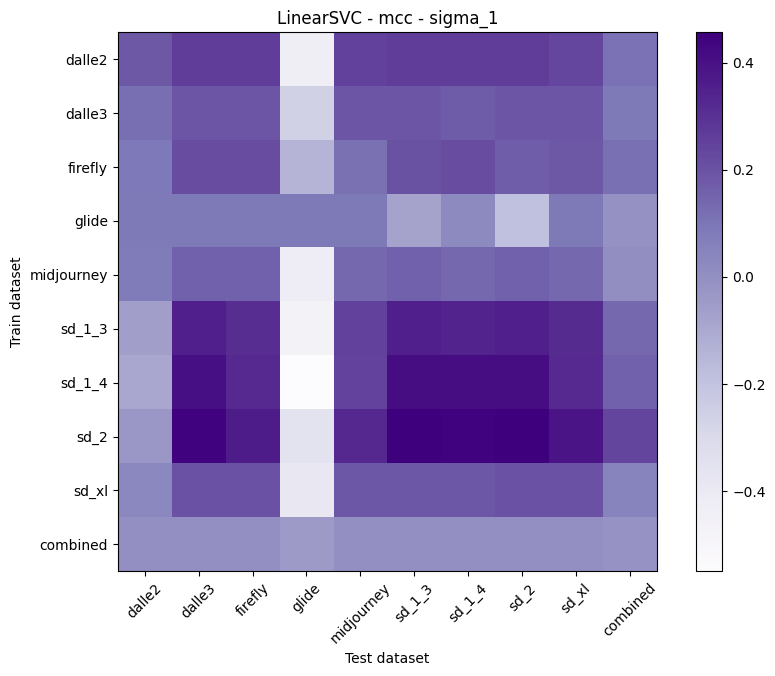

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.184302  0.263664  0.263664 -0.438822    0.249117  0.263664   
dalle3         0.120596  0.190445  0.190445 -0.261099    0.190445  0.190445   
firefly        0.089682  0.217072  0.217072 -0.144098    0.113608  0.199807   
glide          0.086929  0.086929  0.086929  0.086929    0.086929 -0.076436   
midjourney     0.081619  0.160128  0.160128 -0.419079    0.137585  0.160128   
sd_1_3        -0.063722  0.351562  0.307729 -0.467113    0.248739  0.351562   
sd_1_4        -0.095341  0.401857  0.319461 -0.549308    0.247297  0.411814   
sd_2          -0.031250  0.447407  0.362500 -0.350280    0.323900  0.456573   
sd_xl          0.028922  0.204124  0.204124 -0.388127    0.185895  0.185895   
combined       0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.263664  0.263664  0.235159  0.108487  
dalle3         0.171067  0.190445  0.190445  0.085771  
firefly        0.217072  0.168137  0.183533  0.117786  
glide          0.022502 -0.189484  0.086929 -0.008825  
midjourney     0.137585  0.160128  0.137585  0.003854  
sd_1_3         0.340211  0.351562  0.318308  0.138086  
sd_1_4         0.411814  0.411814  0.319461  0.159334  
sd_2           0.447407  0.456573  0.386797  0.239895  
sd_xl          0.185895  0.204124  0.204124  0.049823  
combined       0.000000  0.000000  0.000000 -0.016669

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.184302  0.263664  0.263664 -0.438822    0.249117  0.263664   
dalle3         0.120596  0.190445  0.190445 -0.261099    0.190445  0.190445   
firefly        0.089682  0.217072  0.217072 -0.144098    0.113608  0.199807   
glide          0.086929  0.086929  0.086929  0.086929    0.086929 -0.076436   
midjourney     0.081619  0.160128  0.160128 -0.419079    0.137585  0.160128   
sd_1_3        -0.063722  0.351562  0.307729 -0.467113    0.248739  0.351562   
sd_1_4        -0.095341  0.401857  0.319461 -0.549308    0.247297  0.411814   
sd_2          -0.031250  0.447407  0.362500 -0.350280    0.323900  0.456573   
sd_xl          0.028922  0.204124  0.204124 -0.388127    0.185895  0.185895   
combined       0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.263664  0.263664  0.235159  0.172008  
dalle3         0.171067  0.190445  0.190445  0.130360  
firefly        0.217072  0.168137  0.183533  0.140209  
glide          0.022502 -0.189484  0.086929  0.030906  
midjourney     0.137585  0.160128  0.137585  0.079534  
sd_1_3         0.340211  0.351562  0.318308  0.193204  
sd_1_4         0.411814  0.411814  0.319461  0.208763  
sd_2           0.447407  0.456573  0.386797  0.277736  
sd_xl          0.185895  0.204124  0.204124  0.112775  
combined       0.000000  0.000000  0.000000 -0.005563









 ################ Evaluating models trained on standard and tested on sigma_2. ################


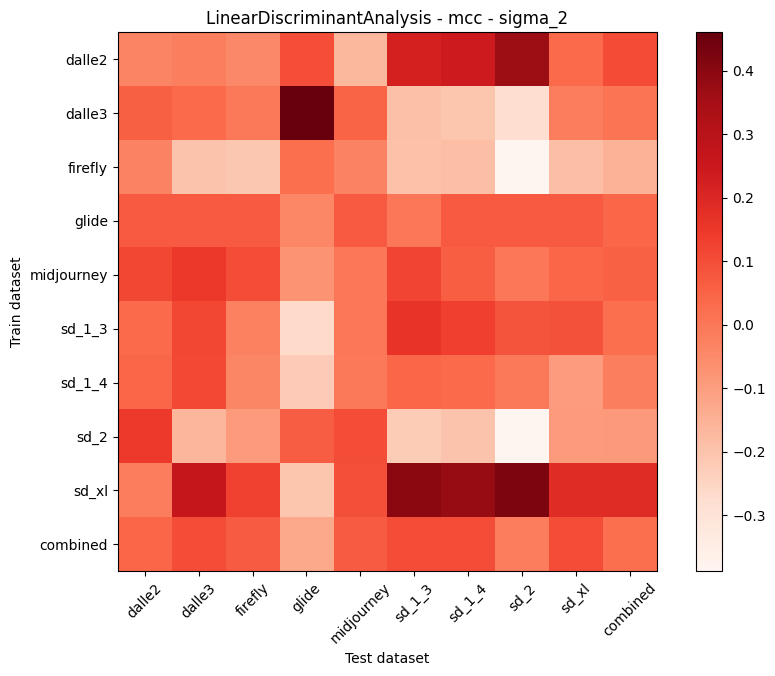

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.034943 -0.017052 -0.044237  0.095861   -0.168430  0.218904   
dalle3         0.059076  0.032580 -0.005524  0.460368    0.048542 -0.189451   
firefly       -0.030183 -0.200361 -0.210516  0.020261   -0.030183 -0.195296   
glide          0.070888  0.070888  0.070888 -0.041135    0.070888  0.000000   
midjourney     0.114708  0.150488  0.100959 -0.073421    0.000000  0.121697   
sd_1_3         0.033085  0.113604 -0.025240 -0.265463    0.000000  0.163543   
sd_1_4         0.039477  0.112022 -0.037156 -0.220380   -0.006341  0.039477   
sd_2           0.145659 -0.163649 -0.090895  0.065007    0.100125 -0.222972   
sd_xl         -0.016045  0.265748  0.127993 -0.204155    0.092952  0.395599   
combined       0.041135  0.100504  0.067505 -0.129287    0.067505  0.100504   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.239777  0.364769  0.031960  0.102422  
dalle3        -0.203444 -0.278313 -0.016659  0.004277  
firefly       -0.185188 -0.385804 -0.185188 -0.154461  
glide          0.070888  0.070888  0.070888  0.040962  
midjourney     0.061379  0.000000  0.042420  0.054297  
sd_1_3         0.129688  0.082895  0.090402  0.024080  
sd_1_4         0.032715 -0.006341 -0.095050 -0.021584  
sd_2          -0.201130 -0.388268 -0.090895 -0.089191  
sd_xl          0.375230  0.421350  0.187263  0.187263  
combined       0.100504 -0.016857  0.100504  0.026038

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.034943 -0.017052 -0.044237  0.095861   -0.168430  0.218904   
dalle3         0.059076  0.032580 -0.005524  0.460368    0.048542 -0.189451   
firefly       -0.030183 -0.200361 -0.210516  0.020261   -0.030183 -0.195296   
glide          0.070888  0.070888  0.070888 -0.041135    0.070888  0.000000   
midjourney     0.114708  0.150488  0.100959 -0.073421    0.000000  0.121697   
sd_1_3         0.033085  0.113604 -0.025240 -0.265463    0.000000  0.163543   
sd_1_4         0.039477  0.112022 -0.037156 -0.220380   -0.006341  0.039477   
sd_2           0.145659 -0.163649 -0.090895  0.065007    0.100125 -0.222972   
sd_xl         -0.016045  0.265748  0.127993 -0.204155    0.092952  0.395599   
combined       0.041135  0.100504  0.067505 -0.129287    0.067505  0.100504   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.239777  0.364769  0.031960  0.076290  
dalle3        -0.203444 -0.278313 -0.016659 -0.010314  
firefly       -0.185188 -0.385804 -0.185188 -0.155829  
glide          0.070888  0.070888  0.070888  0.050565  
midjourney     0.061379  0.000000  0.042420  0.057581  
sd_1_3         0.129688  0.082895  0.090402  0.035835  
sd_1_4         0.032715 -0.006341 -0.095050 -0.015731  
sd_2          -0.201130 -0.388268 -0.090895 -0.094113  
sd_xl          0.375230  0.421350  0.187263  0.182882  
combined       0.100504 -0.016857  0.100504  0.048002

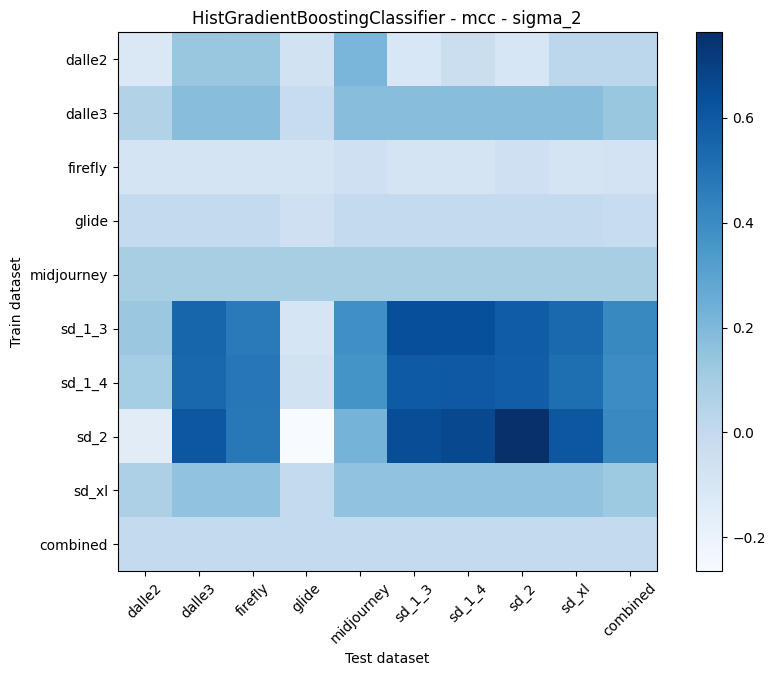

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.116667  0.134508  0.128767 -0.071207    0.210374 -0.107153   
dalle3         0.058767  0.175863  0.175863 -0.020282    0.175863  0.175863   
firefly       -0.086929 -0.086929 -0.086929 -0.086929   -0.050252 -0.086929   
glide          0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
midjourney     0.086929  0.086929  0.086929  0.086929    0.086929  0.086929   
sd_1_3         0.125568  0.551267  0.468109 -0.094663    0.384959  0.641838   
sd_1_4         0.100020  0.544063  0.477977 -0.065694    0.369236  0.593486   
sd_2          -0.150488  0.606709  0.475720 -0.264617    0.221655  0.643907   
sd_xl          0.070492  0.151717  0.151717  0.000000    0.151717  0.151717   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2        -0.038126 -0.097862  0.021455  0.020678  
dalle3         0.175863  0.175863  0.175863  0.130016  
firefly       -0.086929 -0.050252 -0.086929 -0.077687  
glide          0.000000  0.000000  0.000000 -0.016669  
midjourney     0.086929  0.086929  0.086929  0.086929  
sd_1_3         0.641838  0.582639  0.538986  0.412723  
sd_1_4         0.600792  0.579066  0.517046  0.394423  
sd_2           0.665649  0.762840  0.606709  0.407671  
sd_xl          0.151717  0.151717  0.151717  0.118451  
combined       0.000000  0.000000  0.000000  0.000000

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.116667  0.134508  0.128767 -0.071207    0.210374 -0.107153   
dalle3         0.058767  0.175863  0.175863 -0.020282    0.175863  0.175863   
firefly       -0.086929 -0.086929 -0.086929 -0.086929   -0.050252 -0.086929   
glide          0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
midjourney     0.086929  0.086929  0.086929  0.086929    0.086929  0.086929   
sd_1_3         0.125568  0.551267  0.468109 -0.094663    0.384959  0.641838   
sd_1_4         0.100020  0.544063  0.477977 -0.065694    0.369236  0.593486   
sd_2          -0.150488  0.606709  0.475720 -0.264617    0.221655  0.643907   
sd_xl          0.070492  0.151717  0.151717  0.000000    0.151717  0.151717   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2        -0.038126 -0.097862  0.021455  0.007121  
dalle3         0.175863  0.175863  0.175863  0.141059  
firefly       -0.086929 -0.050252 -0.086929 -0.078779  
glide          0.000000  0.000000  0.000000 -0.005563  
midjourney     0.086929  0.086929  0.086929  0.086929  
sd_1_3         0.641838  0.582639  0.538986  0.426727  
sd_1_4         0.600792  0.579066  0.517046  0.412888  
sd_2           0.665649  0.762840  0.606709  0.396454  
sd_xl          0.151717  0.151717  0.151717  0.125834  
combined       0.000000  0.000000  0.000000  0.000000

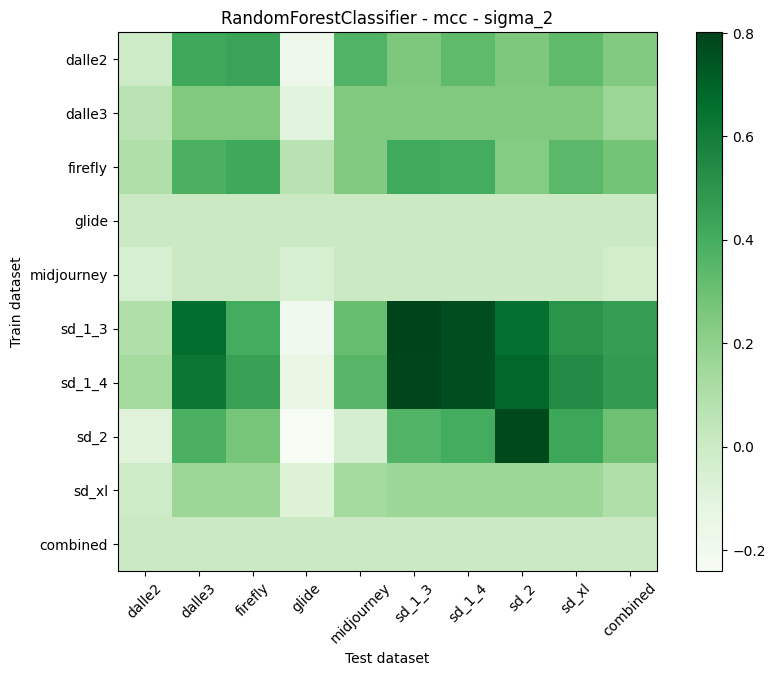

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.010001  0.417156  0.442954 -0.172511    0.367568  0.252702   
dalle3         0.068209  0.246998  0.246998 -0.104310    0.246998  0.246998   
firefly        0.098248  0.378561  0.421464  0.071928    0.237841  0.406894   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney    -0.050063  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.094294  0.657379  0.398264 -0.196347    0.310625  0.801444   
sd_1_4         0.129717  0.630032  0.453710 -0.131685    0.356417  0.793385   
sd_2          -0.089644  0.378620  0.265543 -0.241249   -0.042139  0.369529   
sd_xl         -0.011209  0.160128  0.160128 -0.078386    0.137585  0.160128   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.331896  0.252702  0.331896  0.236939  
dalle3         0.246998  0.246998  0.246998  0.165257  
firefly        0.399713  0.231925  0.344512  0.279586  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.000000  0.000000  0.000000 -0.023577  
sd_1_3         0.765239  0.647930  0.501582  0.461245  
sd_1_4         0.765532  0.685695  0.537974  0.473839  
sd_2           0.401178  0.785010  0.427991  0.294812  
sd_xl          0.160128  0.160128  0.160128  0.092848  
combined       0.000000  0.000000  0.000000  0.000000

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.010001  0.417156  0.442954 -0.172511    0.367568  0.252702   
dalle3         0.068209  0.246998  0.246998 -0.104310    0.246998  0.246998   
firefly        0.098248  0.378561  0.421464  0.071928    0.237841  0.406894   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney    -0.050063  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.094294  0.657379  0.398264 -0.196347    0.310625  0.801444   
sd_1_4         0.129717  0.630032  0.453710 -0.131685    0.356417  0.793385   
sd_2          -0.089644  0.378620  0.265543 -0.241249   -0.042139  0.369529   
sd_xl         -0.011209  0.160128  0.160128 -0.078386    0.137585  0.160128   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.331896  0.252702  0.331896  0.246040  
dalle3         0.246998  0.246998  0.246998  0.188098  
firefly        0.399713  0.231925  0.344512  0.287898  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.000000  0.000000  0.000000 -0.011125  
sd_1_3         0.765239  0.647930  0.501582  0.442268  
sd_1_4         0.765532  0.685695  0.537974  0.468975  
sd_2           0.401178  0.785010  0.427991  0.250538  
sd_xl          0.160128  0.160128  0.160128  0.112084  
combined       0.000000  0.000000  0.000000  0.000000

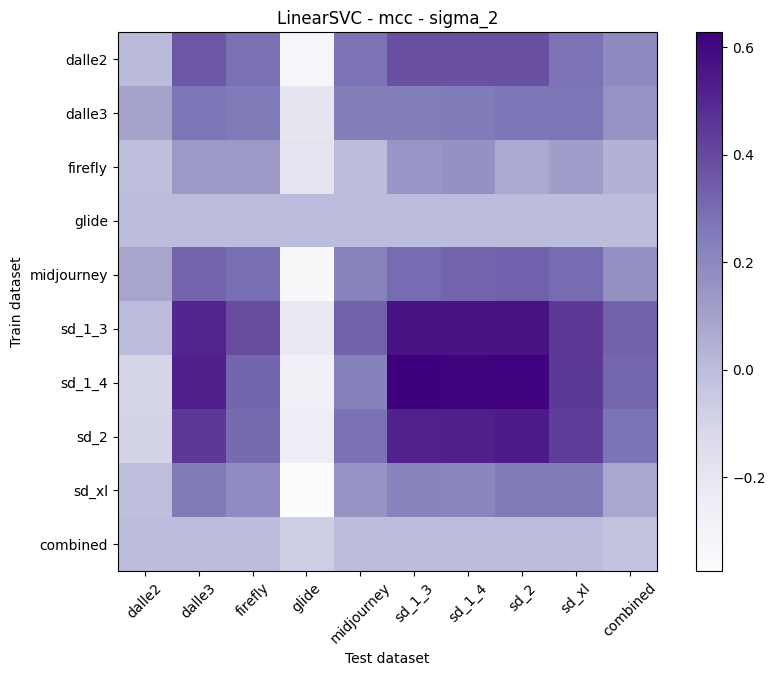

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.005682  0.360244  0.286411 -0.323662    0.277846  0.380424   
dalle3         0.097862  0.269047  0.254755 -0.194731    0.241021  0.241021   
firefly       -0.009965  0.127578  0.127578 -0.187388    0.000000  0.144749   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.087033  0.321459  0.287641 -0.342729    0.217370  0.298630   
sd_1_3         0.005000  0.503903  0.392048 -0.220148    0.326063  0.569690   
sd_1_4        -0.102755  0.525214  0.315147 -0.282359    0.231159  0.627478   
sd_2          -0.100020  0.448871  0.300123 -0.243132    0.282335  0.515122   
sd_xl         -0.007625  0.252646  0.183176 -0.374646    0.158948  0.223100   
combined       0.000000  0.000000  0.000000 -0.070888    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.380424  0.380424  0.277846  0.188739  
dalle3         0.254755  0.269047  0.269047  0.158434  
firefly        0.163239  0.068825  0.111537  0.038624  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.321459  0.333333  0.298630  0.161714  
sd_1_3         0.562106  0.569690  0.449519  0.328004  
sd_1_4         0.613129  0.620273  0.444795  0.313356  
sd_2           0.522851  0.538556  0.434876  0.274523  
sd_xl          0.209258  0.252646  0.252646  0.076884  
combined       0.000000  0.000000  0.000000 -0.023577

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.005682  0.360244  0.286411 -0.323662    0.277846  0.380424   
dalle3         0.097862  0.269047  0.254755 -0.194731    0.241021  0.241021   
firefly       -0.009965  0.127578  0.127578 -0.187388    0.000000  0.144749   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.087033  0.321459  0.287641 -0.342729    0.217370  0.298630   
sd_1_3         0.005000  0.503903  0.392048 -0.220148    0.326063  0.569690   
sd_1_4        -0.102755  0.525214  0.315147 -0.282359    0.231159  0.627478   
sd_2          -0.100020  0.448871  0.300123 -0.243132    0.282335  0.515122   
sd_xl         -0.007625  0.252646  0.183176 -0.374646    0.158948  0.223100   
combined       0.000000  0.000000  0.000000 -0.070888    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.380424  0.380424  0.277846  0.225071  
dalle3         0.254755  0.269047  0.269047  0.189091  
firefly        0.163239  0.068825  0.111537  0.060684  
glide          0.000000  0.000000  0.000000  0.000000  
midjourney     0.321459  0.333333  0.298630  0.202536  
sd_1_3         0.562106  0.569690  0.449519  0.350875  
sd_1_4         0.613129  0.620273  0.444795  0.332453  
sd_2           0.522851  0.538556  0.434876  0.299953  
sd_xl          0.209258  0.252646  0.252646  0.127794  
combined       0.000000  0.000000  0.000000 -0.007876









 ################ Evaluating models trained on standard and tested on sigma_3. ################


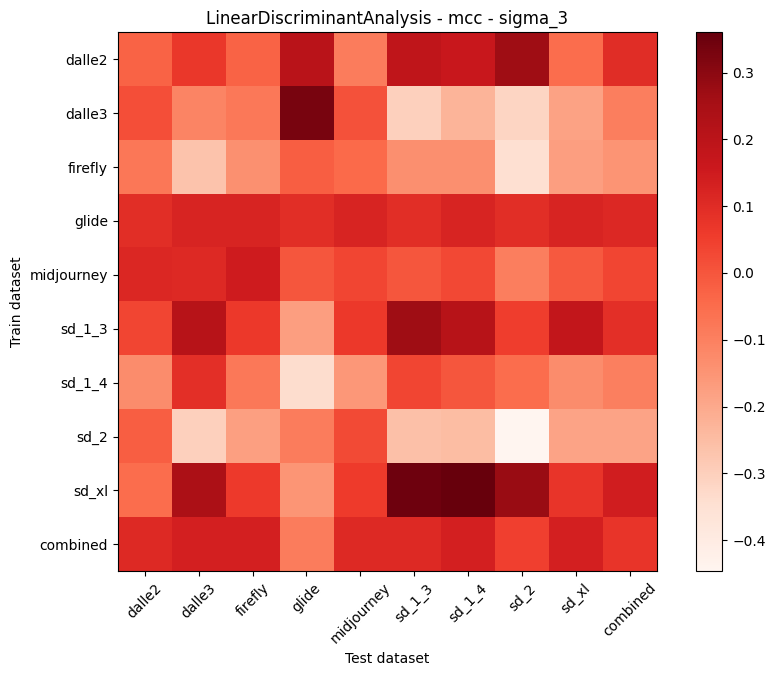

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.029894  0.068209 -0.029894  0.204454   -0.087727  0.187327   
dalle3         0.015000 -0.110801 -0.080326  0.330760    0.010000 -0.304003   
firefly       -0.075114 -0.267448 -0.140007 -0.020122   -0.045163 -0.135002   
glide          0.095329  0.123404  0.123404  0.095329    0.123404  0.095329   
midjourney     0.113306  0.106931  0.146049  0.000000    0.034197  0.000000   
sd_1_3         0.035122  0.210545  0.065598 -0.174471    0.065598  0.267657   
sd_1_4        -0.130397  0.089644 -0.079855 -0.337330   -0.159730  0.033333   
sd_2          -0.020036 -0.302064 -0.175795 -0.090005    0.025139 -0.258997   
sd_xl         -0.049976  0.237875  0.063561 -0.152195    0.058373  0.345350   
combined       0.107143  0.133460  0.133460 -0.087727    0.107143  0.107143   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.163543  0.268261 -0.051640  0.097070  
dalle3        -0.226061 -0.315545 -0.183340 -0.093836  
firefly       -0.135002 -0.347754 -0.175177 -0.147801  
glide          0.123404  0.095329  0.123404  0.110314  
midjourney     0.028410 -0.096468 -0.005583  0.033552  
sd_1_3         0.210545  0.053264  0.180274  0.090899  
sd_1_4         0.000000 -0.052469 -0.130397 -0.098693  
sd_2          -0.248405 -0.446606 -0.186028 -0.185459  
sd_xl          0.360162  0.276837  0.073885  0.140722  
combined       0.133460  0.045862  0.133460  0.075009

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.029894  0.068209 -0.029894  0.204454   -0.087727  0.187327   
dalle3         0.015000 -0.110801 -0.080326  0.330760    0.010000 -0.304003   
firefly       -0.075114 -0.267448 -0.140007 -0.020122   -0.045163 -0.135002   
glide          0.095329  0.123404  0.123404  0.095329    0.123404  0.095329   
midjourney     0.113306  0.106931  0.146049  0.000000    0.034197  0.000000   
sd_1_3         0.035122  0.210545  0.065598 -0.174471    0.065598  0.267657   
sd_1_4        -0.130397  0.089644 -0.079855 -0.337330   -0.159730  0.033333   
sd_2          -0.020036 -0.302064 -0.175795 -0.090005    0.025139 -0.258997   
sd_xl         -0.049976  0.237875  0.063561 -0.152195    0.058373  0.345350   
combined       0.107143  0.133460  0.133460 -0.087727    0.107143  0.107143   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.163543  0.268261 -0.051640  0.076960  
dalle3        -0.226061 -0.315545 -0.183340 -0.096035  
firefly       -0.135002 -0.347754 -0.175177 -0.148977  
glide          0.123404  0.095329  0.123404  0.110926  
midjourney     0.028410 -0.096468 -0.005583  0.036316  
sd_1_3         0.210545  0.053264  0.180274  0.101570  
sd_1_4         0.000000 -0.052469 -0.130397 -0.085245  
sd_2          -0.248405 -0.446606 -0.186028 -0.189200  
sd_xl          0.360162  0.276837  0.073885  0.134875  
combined       0.133460  0.045862  0.133460  0.090378

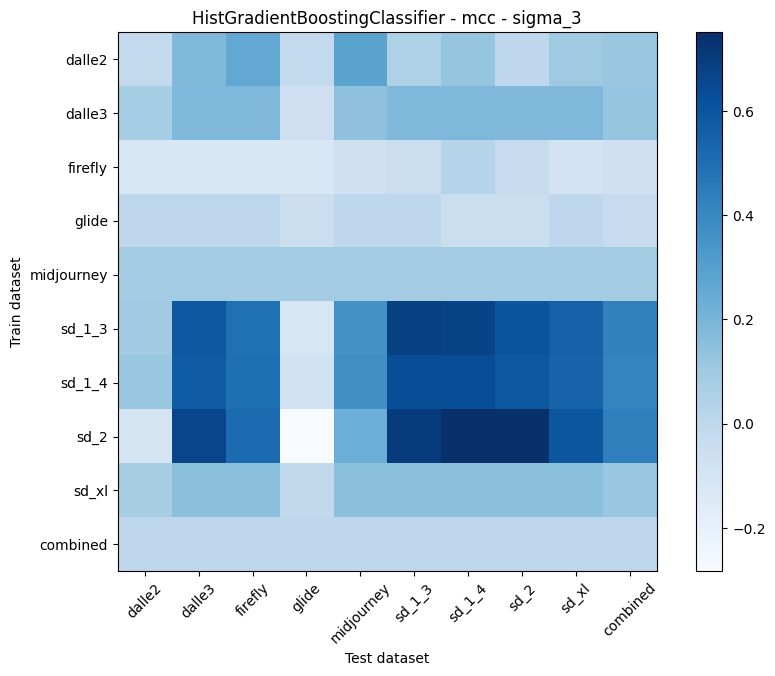

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.014868  0.178784  0.260682 -0.014868    0.284975  0.048678   
dalle3         0.082273  0.183280  0.183280 -0.063607    0.144749  0.183280   
firefly       -0.123404 -0.123404 -0.123404 -0.123404   -0.071429 -0.050572   
glide          0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
midjourney     0.086929  0.086929  0.086929  0.086929    0.086929  0.086929   
sd_1_3         0.091670  0.595595  0.495524 -0.113770    0.361158  0.685994   
sd_1_4         0.120096  0.577115  0.500479 -0.082409    0.367423  0.631992   
sd_2          -0.100959  0.665649  0.515058 -0.283122    0.231400  0.704658   
sd_xl          0.070492  0.151717  0.151717 -0.011753    0.151717  0.151717   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.128767 -0.007374  0.099255  0.116477  
dalle3         0.183280  0.183280  0.183280  0.125742  
firefly        0.027206 -0.032026 -0.095329 -0.071429  
glide         -0.050063 -0.050063  0.000000 -0.028880  
midjourney     0.086929  0.086929  0.086929  0.086929  
sd_1_3         0.672538  0.601781  0.553291  0.424178  
sd_1_4         0.631992  0.597297  0.544436  0.414568  
sd_2           0.745053  0.750949  0.601475  0.433235  
sd_xl          0.151717  0.151717  0.151717  0.116110  
combined       0.000000  0.000000  0.000000  0.000000

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.014868  0.178784  0.260682 -0.014868    0.284975  0.048678   
dalle3         0.082273  0.183280  0.183280 -0.063607    0.144749  0.183280   
firefly       -0.123404 -0.123404 -0.123404 -0.123404   -0.071429 -0.050572   
glide          0.000000  0.000000  0.000000 -0.050063    0.000000  0.000000   
midjourney     0.086929  0.086929  0.086929  0.086929    0.086929  0.086929   
sd_1_3         0.091670  0.595595  0.495524 -0.113770    0.361158  0.685994   
sd_1_4         0.120096  0.577115  0.500479 -0.082409    0.367423  0.631992   
sd_2          -0.100959  0.665649  0.515058 -0.283122    0.231400  0.704658   
sd_xl          0.070492  0.151717  0.151717 -0.011753    0.151717  0.151717   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.128767 -0.007374  0.099255  0.107115  
dalle3         0.183280  0.183280  0.183280  0.140344  
firefly        0.027206 -0.032026 -0.095329 -0.079529  
glide         -0.050063 -0.050063  0.000000 -0.016688  
midjourney     0.086929  0.086929  0.086929  0.086929  
sd_1_3         0.672538  0.601781  0.553291  0.438198  
sd_1_4         0.631992  0.597297  0.544436  0.432047  
sd_2           0.745053  0.750949  0.601475  0.425573  
sd_xl          0.151717  0.151717  0.151717  0.124528  
combined       0.000000  0.000000  0.000000  0.000000

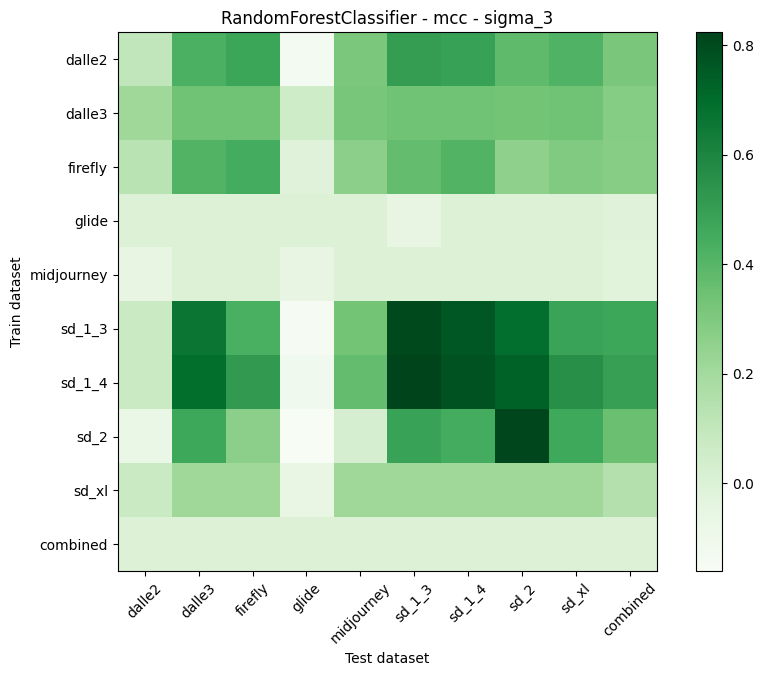

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.100856  0.429741  0.477265 -0.135750    0.311934  0.505690   
dalle3         0.210527  0.342518  0.342518  0.050981    0.319601  0.342518   
firefly        0.130822  0.409756  0.447261 -0.015184    0.263133  0.367089   
glide          0.000000  0.000000  0.000000  0.000000    0.000000 -0.050063   
midjourney    -0.050063  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.071002  0.658641  0.433217 -0.147442    0.328550  0.805816   
sd_1_4         0.075719  0.690138  0.516656 -0.112433    0.369425  0.823705   
sd_2          -0.075173  0.469513  0.263181 -0.161109    0.027260  0.486702   
sd_xl          0.069753  0.210681  0.210681 -0.057698    0.210681  0.210681   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.491353  0.378384  0.416628  0.315843  
dalle3         0.342518  0.330914  0.342518  0.281505  
firefly        0.409756  0.257023  0.294304  0.274785  
glide          0.000000  0.000000  0.000000 -0.016669  
midjourney     0.000000  0.000000  0.000000 -0.023577  
sd_1_3         0.765010  0.686935  0.482211  0.471835  
sd_1_4         0.773879  0.731318  0.558707  0.497623  
sd_2           0.443575  0.815500  0.465204  0.350545  
sd_xl          0.210681  0.210681  0.210681  0.148956  
combined       0.000000  0.000000  0.000000  0.000000

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2         0.100856  0.429741  0.477265 -0.135750    0.311934  0.505690   
dalle3         0.210527  0.342518  0.342518  0.050981    0.319601  0.342518   
firefly        0.130822  0.409756  0.447261 -0.015184    0.263133  0.367089   
glide          0.000000  0.000000  0.000000  0.000000    0.000000 -0.050063   
midjourney    -0.050063  0.000000  0.000000 -0.050063    0.000000  0.000000   
sd_1_3         0.071002  0.658641  0.433217 -0.147442    0.328550  0.805816   
sd_1_4         0.075719  0.690138  0.516656 -0.112433    0.369425  0.823705   
sd_2          -0.075173  0.469513  0.263181 -0.161109    0.027260  0.486702   
sd_xl          0.069753  0.210681  0.210681 -0.057698    0.210681  0.210681   
combined       0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.491353  0.378384  0.416628  0.330678  
dalle3         0.342518  0.330914  0.342518  0.291624  
firefly        0.409756  0.257023  0.294304  0.284885  
glide          0.000000  0.000000  0.000000 -0.005563  
midjourney     0.000000  0.000000  0.000000 -0.011125  
sd_1_3         0.765010  0.686935  0.482211  0.453771  
sd_1_4         0.773879  0.731318  0.558707  0.491902  
sd_2           0.443575  0.815500  0.465204  0.303850  
sd_xl          0.210681  0.210681  0.210681  0.165202  
combined       0.000000  0.000000  0.000000  0.000000

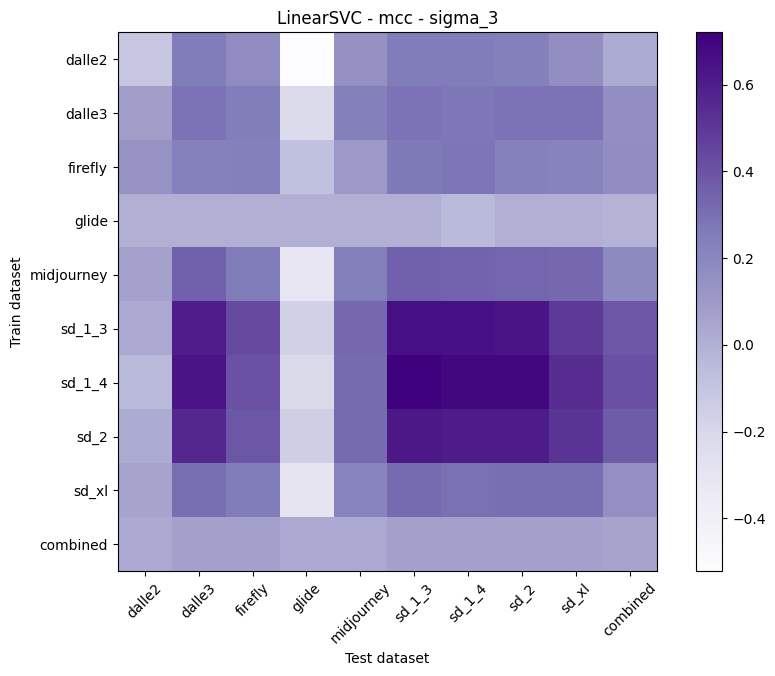

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.109109  0.252646  0.170848 -0.522266    0.147442  0.252646   
dalle3         0.075593  0.284747  0.245343 -0.225925    0.233074  0.284747   
firefly        0.134502  0.227128  0.238882 -0.077260    0.107705  0.263517   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.069076  0.356034  0.254084 -0.305086    0.244966  0.356034   
sd_1_3         0.030443  0.600245  0.430548 -0.160128    0.327569  0.654654   
sd_1_4        -0.044544  0.635572  0.410021 -0.206902    0.316144  0.720983   
sd_2           0.025139  0.564717  0.386788 -0.150815    0.315147  0.620273   
sd_xl          0.053882  0.306942  0.250203 -0.294160    0.209617  0.319262   
combined       0.028976  0.070888  0.070888  0.028976    0.028976  0.070888   

test_dataset     sd_1_4      sd_2     sd_xl  combined  
train_dataset                                          
dalle2         0.252646  0.237543  0.158948  0.025549  
dalle3         0.271146  0.284747  0.284747  0.158822  
firefly        0.276454  0.227128  0.215718  0.165303  
glide         -0.050063  0.000000  0.000000 -0.016669  
midjourney     0.344804  0.333835  0.323115  0.182622  
sd_1_3         0.654654  0.633860  0.494048  0.389336  
sd_1_4         0.695843  0.695843  0.545371  0.411695  
sd_2           0.606045  0.606045  0.512410  0.368056  
sd_xl          0.294973  0.306942  0.306942  0.156769  
combined       0.070888  0.070888  0.070888  0.054714

test_dataset     dalle2    dalle3   firefly     glide  midjourney    sd_1_3  \
train_dataset                                                                 
dalle2        -0.109109  0.252646  0.170848 -0.522266    0.147442  0.252646   
dalle3         0.075593  0.284747  0.245343 -0.225925    0.233074  0.284747   
firefly        0.134502  0.227128  0.238882 -0.077260    0.107705  0.263517   
glide          0.000000  0.000000  0.000000  0.000000    0.000000  0.000000   
midjourney     0.069076  0.356034  0.254084 -0.305086    0.244966  0.356034   
sd_1_3         0.030443  0.600245  0.430548 -0.160128    0.327569  0.654654   
sd_1_4        -0.044544  0.635572  0.410021 -0.206902    0.316144  0.720983   
sd_2           0.025139  0.564717  0.386788 -0.150815    0.315147  0.620273   
sd_xl          0.053882  0.306942  0.250203 -0.294160    0.209617  0.319262   
combined       0.028976  0.070888  0.070888  0.028976    0.028976  0.070888   

test_dataset     sd_1_4      sd_2     sd_xl   average  
train_dataset                                          
dalle2         0.252646  0.237543  0.158948  0.093483  
dalle3         0.271146  0.284747  0.284747  0.193136  
firefly        0.276454  0.227128  0.215718  0.179308  
glide         -0.050063  0.000000  0.000000 -0.005563  
midjourney     0.344804  0.333835  0.323115  0.219651  
sd_1_3         0.654654  0.633860  0.494048  0.407322  
sd_1_4         0.695843  0.695843  0.545371  0.418704  
sd_2           0.606045  0.606045  0.512410  0.387305  
sd_xl          0.294973  0.306942  0.306942  0.194956  
combined       0.070888  0.070888  0.070888  0.056918

In [16]:
print("########################### MCC ###########################")
for perturbed_name, results in perturbed_results.items():
    print(f"\n\n\n\n\n\n\n\n ################ Evaluating models trained on {base_perturbed_name} and tested on {perturbed_name}. ################")
    
    # Create a heatmap of results
    df = pd.DataFrame(results).T
    df.reset_index(inplace=True)
    df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

    metric = "mcc"
    evaluation_data_name = "Test"
    df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)
    df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric, perturbed_name=perturbed_name)